In [1]:
#run for colab only

!git clone https://github.com/hungpham13/federated-learning
%cd federated-learning
!pip install -q -r requirements.txt
!gdown https://drive.google.com/uc?id=1hTHuOaXQbtdDKvvRqvtmGTpT4TAqUvLs
! unzip -qq -o ./images-fd.zip -d ./data
! mv ./data/images-fd ./data/images

Cloning into 'federated-learning'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 165 (delta 102), reused 94 (delta 43), pack-reused 0
Receiving objects: 100% (165/165), 4.23 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (102/102), done.
/content/federated-learning
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.8

In [1]:
import flwr as fl
from config import NUM_CLIENTS, DEVICE, CLASSES, RUN_ID
from model import Net, VGG16
from main import simulate
import matplotlib.pyplot as plt
from utils import plot_tensorboard
from torch.utils.tensorboard import SummaryWriter

from dataloader import load_cifars, load_fitzpatrick

## Visuzalize the dataset

train set loaded, length:  14781
test set loaded, length:  1642
image shape (64, 64, 3)


/home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


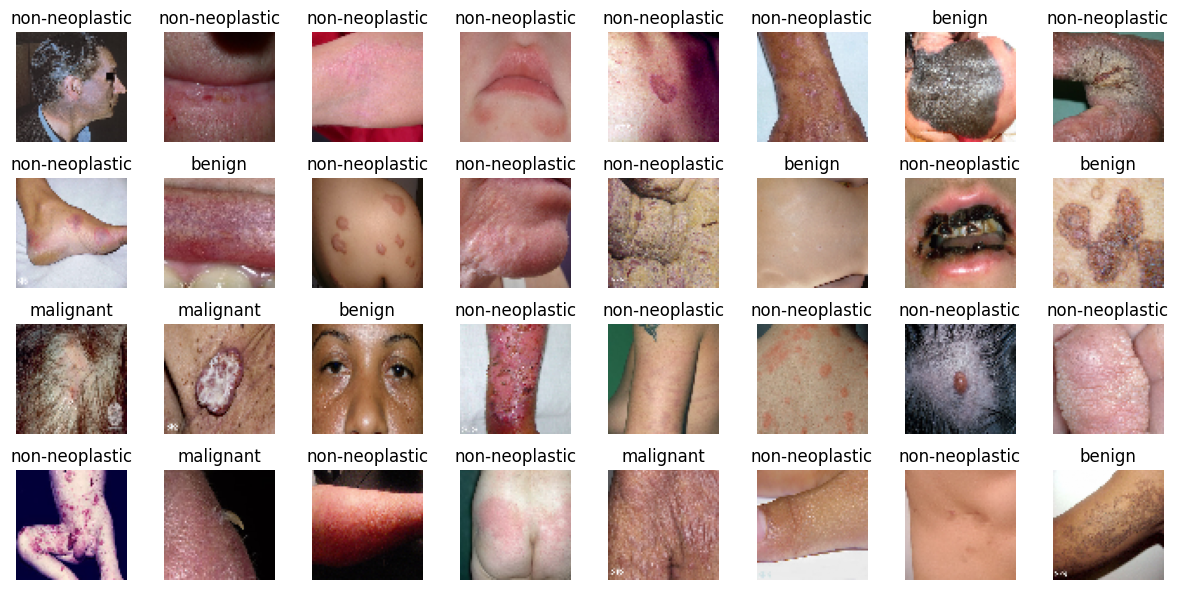

In [3]:
trainloaders, valloaders, testloader = load_fitzpatrick(1, './data/images')
# trainloaders, valloaders, testloader = load_cifars(1)

images, labels = next(iter(valloaders[0]))


# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

print('image shape', images[0].shape)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

## Centralize training

In [2]:
trainloaders, valloaders, testloader = load_fitzpatrick(1, './data/images/')

trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net(focus_labels=[1,2], num_classes=3).to(DEVICE)
tensor_writer = SummaryWriter(RUN_ID)

for epoch in range(30):
    net.train_epoch(trainloader, 1)
    loss, accuracy, precision, confusion_matrix = net.test(testloader)
    plot_tensorboard(tensor_writer, loss, accuracy, precision, confusion_matrix, "centralize-train-validation", epoch)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}, precision {precision}")

loss, accuracy,precision, confusion_matrix = net.test(valloader)
plot_tensorboard(tensor_writer, loss, accuracy, precision, confusion_matrix, "centralize-test", 0)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}\n\tprecision {precision}\n\tconfusion matrix {confusion_matrix}")

train set loaded, length:  14786
test set loaded, length:  1645


/home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1: train loss 0.02381347492337227, accuracy 0.7254283137962128
	precision: {'non-neoplastic': 0.7273207148782143, 'malignant': 0.36363636363636365}
	confusion matrix: [[0.04       0.84       0.12      ]
 [0.1351331  0.72732071 0.13754619]
 [0.36363636 0.27272727 0.36363636]]


/home/hung/PycharmProjects/federated-learning/model.py:79: RuntimeWarning: invalid value encountered in divide
  confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None]


Epoch 1: validation loss 0.023196622919529043, accuracy 0.737386018237082, precision {'non-neoplastic': 0.7457413249211357, 'malignant': 0.5166666666666667}


/home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide
  confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None]


Epoch 1: train loss 0.0228562094271183, accuracy 0.7317403065825068
	precision: {'non-neoplastic': 0.7416420463380501, 'malignant': 0.4461883408071749}
	confusion matrix: [[       nan        nan        nan]
 [0.13116156 0.74164205 0.12719639]
 [0.25560538 0.29820628 0.44618834]]
Epoch 2: validation loss 0.022894298595498037, accuracy 0.7331306990881459, precision {'non-neoplastic': 0.7392120075046904, 'malignant': 0.5217391304347826}
Epoch 1: train loss 0.022511258721351624, accuracy 0.7330177336940187
	precision: {'non-neoplastic': 0.745005875440658, 'malignant': 0.45119705340699817}
	confusion matrix: [[       nan        nan        nan]
 [0.13043478 0.74500588 0.12455934]
 [0.25046041 0.29834254 0.45119705]]
Epoch 3: validation loss 0.02218880836362172, accuracy 0.7355623100303952, precision {'non-neoplastic': 0.742928975487115, 'malignant': 0.5185185185185185}
Epoch 1: train loss 0.02206047624349594, accuracy 0.7382777276825969
	precision: {'non-neoplastic': 0.7508697027197976, 'mal

## Fed Average

In [2]:
strategyConfig = {
    "fraction_fit":0.3,
    "fraction_evaluate":0.3,
    "min_fit_clients":3,
    "min_evaluate_clients":3,
    "min_available_clients":NUM_CLIENTS,
}
loaders = load_fitzpatrick(NUM_CLIENTS, './data/images')

train set loaded, length:  14775
test set loaded, length:  1637


In [3]:
net = Net(focus_labels=[1,2], num_classes=3).to(DEVICE)
simulate(StrategyCls=fl.server.strategy.FedAvg, strategyArgs=strategyConfig, net=net, loaders=loaders, num_rounds=50)

INFO flwr 2023-06-16 16:27:16,911 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-06-16 16:27:18,599	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-16 16:27:19,257 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2304211353.0, 'memory': 4608422708.0, 'CPU': 20.0, 'node:10.10.12.34': 1.0}
INFO flwr 2023-06-16 16:27:19,257 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-16 16:27:19,257 | server.py:269 | Using initial parameters provided by strategy
INFO flwr 2023-06-16 16:27:19,257 | server.py:88 | Evaluating initial parameters
/home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and T

Server-side evaluation loss 0.03390730971159845 / accuracy 0.7269395235186317 / precision {'non-neoplastic': 0.7269395235186317, 'malignant': nan}
(launch_and_fit pid=81203) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=81203)   warnings.warn(


(launch_and_fit pid=81190) Epoch 1: train loss 0.025202175602316856, accuracy 0.7330827067669173
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7330827067669173, 'malignant': nan}
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81190)  [0.13759398 0.73308271 0.12932331]
(launch_and_fit pid=81190)  [       nan        nan        nan]]
(launch_and_fit pid=81191) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide
(launch_and_fit pid=81190)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antia

Server-side evaluation loss 0.024128268823874165 / accuracy 0.7269395235186317 / precision {'non-neoplastic': 0.7269395235186317, 'malignant': nan}
(launch_and_evaluate pid=81203) [Client 7] evaluate, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=81203) Epoch 1: train loss 0.026229407638311386, accuracy 0.7195488721804512 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7195488721804512, 'malignant': nan} [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.1443609  0.71954887 0.13609023] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [       nan        nan        nan]] [repeated 2x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 1] evaluate, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [       nan        nan        nan]]
(launch_and_fit pid=81190)  [       nan        nan        nan]]
(launch_and_fit pid=81190)  [       nan        nan        nan]]
(launch_and_fit pid=81190)  [       nan        nan        nan]]
(launch_and_fit pid=81190)  [       nan        nan        nan]]
(launch_and_fit pid=81191) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.024938594549894333, accuracy 0.7172932330827068
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7172932330827068, 'malignant': nan}
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81203)  [0.14586466 0.7172932

(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81190)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81190) Epoch 2: train loss 0.023668158799409866, accuracy 0.724812030075188 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.724812030075188, 'malignant': nan} [repeated 2x across cluster]
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.14210526 0.72481203 0.13308271] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [       nan        nan        nan]] [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:28:05,125 | server.py:232 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-06-16 16:28:11,027 | server.py:119 | fit progress: (2, 0.023735980872490382, {'accuracy': 0.7269395235186317, 'precision': {'non-neoplastic': 0.7269395235186317, 'malignant': nan}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.13500305, 0.72693952, 0.13805742],
       [       nan,        nan,        nan]])}, 45.58203049199801)
DEBUG flwr 2023-06-16 16:28:11,032 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023735980872490382 / accuracy 0.7269395235186317 / precision {'non-neoplastic': 0.7269395235186317, 'malignant': nan}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=81191) Epoch 2: train loss 0.02439478039741516, accuracy 0.7195488721804512 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7195488721804512, 'malignant': nan} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.1443609  0.71954887 0.13609023] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [       nan        nan        nan]] [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81191)   warnings.warn(
(launch_and_evaluate pid=81191)   warnings.warn(
(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 2] evaluate, config: {'server_round': 2, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_fit pid=81191) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.02328972890973091, accuracy 0.7330827067669173
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7330827067669173, 'malignant': nan}
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81191)  [0.13759398 0.73308271

(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81191) Epoch 2: train loss 0.022793075069785118, accuracy 0.7330827067669173 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7330827067669173, 'malignant': nan} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.13759398 0.73308271 0.12932331] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [       nan        nan        nan]] [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:28:33,403 | server.py:232 | fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7168674698795181, 'malignant': 1.0}
(launch_and_fit pid=81190)  [0.         0.         1.        ]]


INFO flwr 2023-06-16 16:28:39,357 | server.py:119 | fit progress: (3, 0.02348420484516048, {'accuracy': 0.7269395235186317, 'precision': {'non-neoplastic': 0.7269395235186317, 'malignant': nan}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.13500305, 0.72693952, 0.13805742],
       [       nan,        nan,        nan]])}, 73.91240558499703)
DEBUG flwr 2023-06-16 16:28:39,362 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02348420484516048 / accuracy 0.7269395235186317 / precision {'non-neoplastic': 0.7269395235186317, 'malignant': nan}
(launch_and_evaluate pid=81203) [Client 8] evaluate, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=81190) Epoch 2: train loss 0.023670734837651253, accuracy 0.7172932330827068 [repeated 2x across cluster]
(launch_and_fit pid=81203) [Client 8] evaluate, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.15361446 0.71686747 0.12951807] [repeated 2x across cluster]
(launch_and_fit pid=81203) [Client 8] evaluate, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81190)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7233082706766917, 'malignant': nan}
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_evaluate pid=81191) [Client 7] evaluate, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_fit pid=81203)  [       nan        nan        nan]]
(launch_and_fit pid=81191) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81190) Epoch 1: train loss 0.024297114461660385, accuracy 0.7195488721804512
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81190)  [0.1443609  0.71954887 0.13609023]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7255496588324488, 'malignant': 0.36363636363636365}
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.719640179910045, 'malignant': nan} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [       nan        nan        nan]] [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.023461855947971344, accuracy 0.7225563909774436 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.18181818 0.45454545 0.36363636]] [repeated 3x across cluster]


DEBUG flwr 2023-06-16 16:28:59,119 | server.py:232 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-06-16 16:29:04,679 | server.py:119 | fit progress: (4, 0.022871933754581318, {'accuracy': 0.7269395235186317, 'precision': {'non-neoplastic': 0.7276621787025703, 'malignant': 0.3333333333333333}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.13463892, 0.72766218, 0.1376989 ],
       [0.33333333, 0.33333333, 0.33333333]])}, 99.23423101399749)
DEBUG flwr 2023-06-16 16:29:04,683 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022871933754581318 / accuracy 0.7269395235186317 / precision {'non-neoplastic': 0.7276621787025703, 'malignant': 0.3333333333333333}
(launch_and_evaluate pid=81203) [Client 3] evaluate, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7195488721804512, 'malignant': nan} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [       nan        nan        nan]] [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.023482488468289375, accuracy 0.7195488721804512 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.1443609  0.71954887 0.13609023] [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7178329571106095, 'malignant': 1.0}
(launch_and_fit pid=81191)  [0.         0.         1.        ]]
(launch_and_evaluate pid=81191) [Client 5] evaluate, config: {'server_round': 4, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.         0.         1.        ]]
(launch_and_fit pid=81191)  [0.         0.         1.        ]]
(launch_and_fit pid=81191)  [0.         0.         1.        ]]
(launch_and_fit pid=81191) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81203) Epoch 1: train loss 0.023030485957860947, accuracy 0.7353383458646616
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81203)  [0.13056604 0.73811321 0.13132075]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7246376811594203, 'malignant': 0.47368421052631576} [repeated 3x across cluster]
(launch_and_fit pid=81190)  [0.16666667 0.33333333 0.5       ]] [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.02324078418314457, accuracy 0.7210526315789474 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.31578947 0.21052632 0.47368421]] [repeated 3x across cluster]


DEBUG flwr 2023-06-16 16:29:24,350 | server.py:232 | fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=81190) 	confusion matrix: 
(launch_and_fit pid=81190) [[       nan        nan        nan]


INFO flwr 2023-06-16 16:29:30,023 | server.py:119 | fit progress: (5, 0.022684545417201905, {'accuracy': 0.7318265119120342, 'precision': {'non-neoplastic': 0.7331686226065472, 'malignant': 0.6111111111111112}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.13403335, 0.73316862, 0.13279802],
       [0.22222222, 0.16666667, 0.61111111]])}, 124.57821378599692)
DEBUG flwr 2023-06-16 16:29:30,027 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022684545417201905 / accuracy 0.7318265119120342 / precision {'non-neoplastic': 0.7331686226065472, 'malignant': 0.6111111111111112}


(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81190)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7217589082638363, 'malignant': 0.3333333333333333} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.02355908788740635, accuracy 0.717391304347826 [repeated 2x across cluster]
(launch_and_fit pid=81203) [Client 1] evaluate, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.13333333 0.53333333 0.33333333]] [repeated 4x across cluster]


DEBUG flwr 2023-06-16 16:29:31,281 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-16 16:29:31,281 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=81203) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan]
(launch_and_evaluate pid=81191) [Client 6] evaluate, config: {'server_round': 5, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.18518519 0.22222222 0.59259259]]
(launch_and_fit pid=81191)  [0.18518519 0.22222222 0.59259259]]
(launch_and_fit pid=81191)  [0.18518519 0.22222222 0.59259259]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81190) Epoch 1: train loss 0.023481905460357666, accuracy 0.7203007518796992
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7226443768996961, 'malignant': 0.5}
(launch_and_fit pid=81190)  [0.28571429 0.21428571 0.5       ]]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 3x across cluster]
(launch_and_fit pid=81191)  [0.21052632 0.19298246 0.59649123]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.02253713086247444, accuracy 0.7406015037593985 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7470542026708562, 'malignant': 0.5964912280701754} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.21052632 0.19298246 0.59649123]]
(launch_and_fit pid=81190)  [0.35       0.225      0.425     ]]


DEBUG flwr 2023-06-16 16:29:49,865 | server.py:232 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-06-16 16:29:55,383 | server.py:119 | fit progress: (6, 0.02292876940495952, {'accuracy': 0.7379352474037875, 'precision': {'non-neoplastic': 0.7492002559181062, 'malignant': 0.5}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.12987844, 0.74920026, 0.12092131],
       [0.24324324, 0.25675676, 0.5       ]])}, 149.93836809399727)
DEBUG flwr 2023-06-16 16:29:55,387 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02292876940495952 / accuracy 0.7379352474037875 / precision {'non-neoplastic': 0.7492002559181062, 'malignant': 0.5}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.22727273 0.28787879 0.48484848]] [repeated 3x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.02240123227238655, accuracy 0.7255639097744361 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7381329113924051, 'malignant': 0.48484848484848486} [repeated 2x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.28       0.28       0.44      ]]
(launch_and_evaluate pid=81191) [Client 2] evaluate, config: {'server_round': 6, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.28       0.28       0.44      ]]
(launch_and_fit pid=81190)  [0.28       0.28       0.44      ]]
(launch_and_fit pid=81190)  [0.28       0.28       0.44      ]]
(launch_and_fit pid=81190)  [0.28       0.28       0.44      ]]
(launch_and_fit pid=81191) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81190)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81191) Epoch 1: train loss 0.022740211337804794, accuracy 0.7240601503759398
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7400635930047694, 'malignant': 0.4444444444444444}
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81191)  [0.14705882 0.74006359 0.11287758]
(launch_and_fit pid=81191)  [0.26388889 0.29166667 0.44444444]]
(launch_and_fit pid=81203)  [0.27659574 0.29787234 0.42553191]]
(launch_and_fit pid=81190) Epoch 2: train loss 0.022885587066411972, accuracy 0.7293233082706767 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7404520654715511, 'malignant': 0.425531914893617} [repeated 2x across cluster]
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.27659574 0.29787234 0.42553191]] [repeated 3x across cluster]


DEBUG flwr 2023-06-16 16:30:15,398 | server.py:232 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-06-16 16:30:20,928 | server.py:119 | fit progress: (7, 0.02251185708899431, {'accuracy': 0.740989615149664, 'precision': {'non-neoplastic': 0.7586657946370177, 'malignant': 0.49074074074074076}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.12818836, 0.75866579, 0.11314585],
       [0.23148148, 0.27777778, 0.49074074]])}, 175.4834620139991)
DEBUG flwr 2023-06-16 16:30:20,932 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02251185708899431 / accuracy 0.740989615149664 / precision {'non-neoplastic': 0.7586657946370177, 'malignant': 0.49074074074074076}
(launch_and_evaluate pid=81203) [Client 4] evaluate, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=81203) Epoch 2: train loss 0.023096567019820213, accuracy 0.7338345864661654 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7462090981644054, 'malignant': 0.5324675324675324} [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.18181818 0.28571429 0.53246753]] [repeated 4x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 8] evaluate, config: {'server_round': 7, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.16363636 0.21818182 0.61818182]]
(launch_and_fit pid=81191)  [0.16363636 0.21818182 0.61818182]]
(launch_and_fit pid=81191)  [0.16363636 0.21818182 0.61818182]]
(launch_and_fit pid=81191)  [0.16363636 0.21818182 0.61818182]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81190) Epoch 1: train loss 0.02229124866425991, accuracy 0.7443609022556391
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7597145122918318, 'malignant': 0.463768115942029}
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81191)  [0.12570056 0.75580464 0.1184948 ]
(launch_and_fit pid=81191)  [0.18518519 0.22222222 0.59259259]] [repeated 5x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.021741900593042374, accuracy 0.7458646616541353 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.755804643714972, 'malignant': 0.5925925925925926} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:30:40,893 | server.py:232 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-06-16 16:30:46,505 | server.py:119 | fit progress: (8, 0.02234047383670772, {'accuracy': 0.7348808796579108, 'precision': {'non-neoplastic': 0.7446134347275032, 'malignant': 0.4745762711864407}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.12991128, 0.74461343, 0.12547529],
       [0.27118644, 0.25423729, 0.47457627]])}, 201.0600922929989)
DEBUG flwr 2023-06-16 16:30:46,506 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02234047383670772 / accuracy 0.7348808796579108 / precision {'non-neoplastic': 0.7446134347275032, 'malignant': 0.4745762711864407}
(launch_and_evaluate pid=81203) [Client 4] evaluate, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.19277108 0.27710843 0.53012048]] [repeated 4x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.022498024627566338, accuracy 0.7353383458646616 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7489975942261428, 'malignant': 0.5301204819277109} [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 9] evaluate, config: {'server_round': 8, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.31578947 0.21052632 0.47368421]] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.31578947 0.21052632 0.47368421]]
(launch_and_fit pid=81191)  [0.31578947 0.21052632 0.47368421]]
(launch_and_fit pid=81191)  [0.31578947 0.21052632 0.47368421]]
(launch_and_fit pid=81191) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81190) Epoch 1: train loss 0.023406419903039932, accuracy 0.7293853073463268
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7369649805447471, 'malignant': 0.5306122448979592}
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81191)  [0.27272727 0.27272727 0.45454545]] [repeated 6x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.022354984655976295, accuracy 0.7308270676691729 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7402799377916018, 'malignant': 0.45454545454545453} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:31:06,548 | server.py:232 | fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=81203)  [0.15625    0.3125     0.53125   ]]


INFO flwr 2023-06-16 16:31:12,052 | server.py:119 | fit progress: (9, 0.022432732560245746, {'accuracy': 0.740989615149664, 'precision': {'non-neoplastic': 0.7568448500651891, 'malignant': 0.5048543689320388}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.12972621, 0.75684485, 0.11342894],
       [0.21359223, 0.2815534 , 0.50485437]])}, 226.60742419899907)
DEBUG flwr 2023-06-16 16:31:12,057 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022432732560245746 / accuracy 0.740989615149664 / precision {'non-neoplastic': 0.7568448500651891, 'malignant': 0.5048543689320388}
(launch_and_evaluate pid=81203) [Client 0] evaluate, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.12326656 0.74653313 0.13020031] [repeated 3x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.022593103349208832, accuracy 0.7413533834586467 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7465331278890601, 'malignant': 0.53125} [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.32       0.32       0.36      ]]
(launch_and_evaluate pid=81191) [Client 7] evaluate, config: {'server_round': 9, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.32       0.32       0.36      ]]
(launch_and_fit pid=81203)  [0.32       0.32       0.36      ]]
(launch_and_fit pid=81203)  [0.32       0.32       0.36      ]]
(launch_and_fit pid=81203)  [0.32       0.32       0.36      ]]
(launch_and_fit pid=81191) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81190) Epoch 1: train loss 0.023443017154932022, accuracy 0.7195488721804512
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7358044164037855, 'malignant': 0.3870967741935484}
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81190)  [0.13958991 0.73580442 0.12460568]
(launch_and_fit pid=81190)  [0.27419355 0.33870968 0.38709677]]
(launch_and_fit pid=81191)  [0.25714286 0.38571429 0.35714286]]
(launch_and_fit pid=81203) Epoch 2: train loss 0.021811507642269135, accuracy 0.7315789473684211 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7523809523809524, 'malignant': 0.35714285714285715} [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.25714286 0.38571429 0.35714286]] [repeated 3x across cluster]


DEBUG flwr 2023-06-16 16:31:31,639 | server.py:232 | fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=81191)  [0.18421053 0.31578947 0.5       ]]


INFO flwr 2023-06-16 16:31:37,252 | server.py:119 | fit progress: (10, 0.022139419122811272, {'accuracy': 0.7354917532070862, 'precision': {'non-neoplastic': 0.7419760855884204, 'malignant': 0.5208333333333334}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.13152926, 0.74197609, 0.12649465],
       [0.25      , 0.22916667, 0.52083333]])}, 251.80741949299772)
DEBUG flwr 2023-06-16 16:31:37,256 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022139419122811272 / accuracy 0.7354917532070862 / precision {'non-neoplastic': 0.7419760855884204, 'malignant': 0.5208333333333334}
(launch_and_evaluate pid=81203) [Client 6] evaluate, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=81191) Epoch 2: train loss 0.02208212949335575, accuracy 0.7466165413533835 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7615629984051037, 'malignant': 0.5} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.12041467 0.761563   0.11802233] [repeated 3x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 5, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 5] evaluate, config: {'server_round': 10, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.37254902 0.2745098  0.35294118]]
(launch_and_fit pid=81190)  [0.37254902 0.2745098  0.35294118]]
(launch_and_fit pid=81190)  [0.37254902 0.2745098  0.35294118]]
(launch_and_fit pid=81190)  [0.37254902 0.2745098  0.35294118]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 3, round 11] fit, config: {'server_round': 11, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81190)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81203) Epoch 1: train loss 0.022979220375418663, accuracy 0.7293233082706767
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7412314886983632, 'malignant': 0.40425531914893614}
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81190)  [0.33928571 0.23214286 0.42857143]] [repeated 6x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.021034516394138336, accuracy 0.7413533834586467 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7551020408163265, 'malignant': 0.42857142857142855} [repeated 2x across cluster]
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:31:56,627 | server.py:232 | fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=81191) 	confusion matrix: [[1.         0.         0.        ]


INFO flwr 2023-06-16 16:32:02,208 | server.py:119 | fit progress: (11, 0.021870134495057633, {'accuracy': 0.7373243738546121, 'precision': {'non-neoplastic': 0.7530704589528119, 'malignant': 0.4666666666666667}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.12798966, 0.75307046, 0.11893988],
       [0.25555556, 0.27777778, 0.46666667]])}, 276.7626859009979)
DEBUG flwr 2023-06-16 16:32:02,211 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.021870134495057633 / accuracy 0.7373243738546121 / precision {'non-neoplastic': 0.7530704589528119, 'malignant': 0.4666666666666667}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 11, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.28947368 0.26315789 0.44736842]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.022117778658866882, accuracy 0.7285714285714285 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7454110135674381, 'malignant': 0.4473684210526316} [repeated 2x across cluster]
(launch_and_fit pid=81203) [Client 1] evaluate, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 6, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan]
(launch_and_evaluate pid=81191) [Client 0] evaluate, config: {'server_round': 11, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.2027027  0.28378378 0.51351351]] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.2027027  0.28378378 0.51351351]]
(launch_and_fit pid=81191)  [0.2027027  0.28378378 0.51351351]]
(launch_and_fit pid=81191) [Client 2, round 12] fit, config: {'server_round': 12, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81203) Epoch 1: train loss 0.021596666425466537, accuracy 0.7661654135338346
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.778041074249605, 'malignant': 0.53125}
(launch_and_fit pid=81203)  [0.125      0.34375    0.53125   ]]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 3x across cluster]
(launch_and_fit pid=81191)  [0.20833333 0.20833333 0.58333333]] [repeated 5x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.02030841074883938, accuracy 0.7563909774436091 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.766295707472178, 'malignant': 0.5833333333333334} [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:32:22,003 | server.py:232 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-06-16 16:32:27,642 | server.py:119 | fit progress: (12, 0.021875629937714313, {'accuracy': 0.7458766035430666, 'precision': {'non-neoplastic': 0.7681545636242505, 'malignant': 0.5}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.12658228, 0.76815456, 0.10526316],
       [0.22794118, 0.27205882, 0.5       ]])}, 302.19693528199787)
DEBUG flwr 2023-06-16 16:32:27,646 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.021875629937714313 / accuracy 0.7458766035430666 / precision {'non-neoplastic': 0.7681545636242505, 'malignant': 0.5}
(launch_and_evaluate pid=81203) [Client 0] evaluate, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.26315789 0.28070175 0.45614035]] [repeated 4x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.021783903241157532, accuracy 0.7436090225563909 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7564807541241163, 'malignant': 0.45614035087719296} [repeated 2x across cluster]


(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81190)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.225  0.225  0.55  ]]
(launch_and_evaluate pid=81191) [Client 6] evaluate, config: {'server_round': 12, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.225  0.225  0.55  ]]
(launch_and_fit pid=81191)  [0.225  0.225  0.55  ]]
(launch_and_fit pid=81191)  [0.225  0.225  0.55  ]]
(launch_and_fit pid=81191)  [0.225  0.225  0.55  ]]
(launch_and_fit pid=81191) [Client 8, round 13] fit, config: {'server_round': 13, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81190) Epoch 1: train loss 0.020765943452715874, accuracy 0.7631578947368421
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7778656126482213, 'malignant': 0.47692307692307695}
(launch_and_fit pid=81190) 	confusion matrix: [[       nan        nan        nan]
(launch_and_fit pid=81190)  [0.11462451 0.77786561 0.10750988]
(launch_and_fit pid=81190)  [0.16923077 0.35384615 0.47692308]]
(launch_and_fit pid=81191) Epoch 2: train loss 0.02128683216869831, accuracy 0.7406015037593985 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7554479418886199, 'malignant': 0.5384615384615384} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.17582418 0.28571429 0.53846154]] [repeated 4x across cluster]
(launch_and_fit pid=81190)  [0.11594203 0.78824477 0.0958132 ]


DEBUG flwr 2023-06-16 16:32:47,866 | server.py:232 | fit_round 13 received 3 results and 0 failures


(launch_and_fit pid=81203) 	confusion matrix: [[1.         0.         0.        ]


INFO flwr 2023-06-16 16:32:53,494 | server.py:119 | fit progress: (13, 0.021666748081683822, {'accuracy': 0.7397678680513133, 'precision': {'non-neoplastic': 0.7674731182795699, 'malignant': 0.46308724832214765}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.12701613, 0.76747312, 0.10551075],
       [0.2147651 , 0.32214765, 0.46308725]])}, 328.0492114139997)
DEBUG flwr 2023-06-16 16:32:53,498 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.021666748081683822 / accuracy 0.7397678680513133 / precision {'non-neoplastic': 0.7674731182795699, 'malignant': 0.46308724832214765}
(launch_and_evaluate pid=81203) [Client 0] evaluate, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=81203) Epoch 2: train loss 0.021746952086687088, accuracy 0.7308270676691729 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7479871175523349, 'malignant': 0.4827586206896552} [repeated 2x across cluster]
(launch_and_fit pid=81190) [Client 0] evaluate, config: {'server_round': 13, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.25287356 0.26436782 0.48275862]] [repeated 3x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan]
(launch_and_evaluate pid=81191) [Client 5] evaluate, config: {'server_round': 13, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.30612245 0.34693878 0.34693878]]
(launch_and_fit pid=81203)  [0.30612245 0.34693878 0.34693878]]
(launch_and_fit pid=81203)  [0.30612245 0.34693878 0.34693878]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 5, round 14] fit, config: {'server_round': 14, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.0226039607077837, accuracy 0.7278195488721805
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7526188557614827, 'malignant': 0.38202247191011235}


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 3x across cluster]
(launch_and_fit pid=81203)  [0.32       0.25333333 0.42666667]] [repeated 6x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.020853200927376747, accuracy 0.7428571428571429 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7617529880478088, 'malignant': 0.4266666666666667} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[1.         0.         0.        ]


DEBUG flwr 2023-06-16 16:33:13,379 | server.py:232 | fit_round 14 received 3 results and 0 failures


(launch_and_fit pid=81190)  [0.203125   0.203125   0.59375   ]]


INFO flwr 2023-06-16 16:33:18,982 | server.py:119 | fit progress: (14, 0.02138582622050948, {'accuracy': 0.7422113622480146, 'precision': {'non-neoplastic': 0.7596594629993452, 'malignant': 0.5}, 'confusion_matrix': array([[       nan,        nan,        nan],
       [0.12835625, 0.75965946, 0.11198428],
       [0.22727273, 0.27272727, 0.5       ]])}, 353.5373532229969)
DEBUG flwr 2023-06-16 16:33:18,986 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02138582622050948 / accuracy 0.7422113622480146 / precision {'non-neoplastic': 0.7596594629993452, 'malignant': 0.5}
(launch_and_evaluate pid=81203) [Client 9] evaluate, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=81190) [Client 9] evaluate, config: {'server_round': 14, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.12834646 0.74566929 0.12598425] [repeated 3x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.021847723051905632, accuracy 0.7383808095952024 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7456692913385827, 'malignant': 0.59375} [repeated 2x across cluster]


(launch_and_fit pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 2x across cluster]
(launch_and_fit pid=81190)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 2x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

(launch_and_fit pid=81203) [Client 6, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan]
(launch_and_evaluate pid=81191) [Client 7] evaluate, config: {'server_round': 14, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.18309859 0.29577465 0.52112676]] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.18309859 0.29577465 0.52112676]]
(launch_and_fit pid=81191)  [0.18309859 0.29577465 0.52112676]]
(launch_and_fit pid=81191) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.02050541155040264, accuracy 0.7661654135338346
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.78330658105939, 'malignant': 0.5119047619047619}


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide [repeated 4x across cluster]
(launch_and_fit pid=81191)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None] [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the m

(launch_and_fit pid=81190) 	confusion matrix: [[0.33333333 0.66666667 0.        ]
(launch_and_fit pid=81190)  [0.28947368 0.21052632 0.5       ]]
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.13636364 0.22727273 0.63636364]] [repeated 5x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.01902172341942787, accuracy 0.7842105263157895 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7946859903381642, 'malignant': 0.6363636363636364} [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:33:39,417 | server.py:232 | fit_round 15 received 3 results and 0 failures


(launch_and_fit pid=81190) 	confusion matrix: [[0.45454545 0.27272727 0.27272727]
(launch_and_fit pid=81190)  [0.26       0.26       0.48      ]]


INFO flwr 2023-06-16 16:33:45,102 | server.py:119 | fit progress: (15, 0.021629570421825915, {'accuracy': 0.7440439828955406, 'precision': {'non-neoplastic': 0.7744360902255639, 'malignant': 0.4853801169590643}, 'confusion_matrix': array([[0.66666667, 0.33333333, 0.        ],
       [0.12781955, 0.77443609, 0.09774436],
       [0.1871345 , 0.32748538, 0.48538012]])}, 379.65721371199834)
DEBUG flwr 2023-06-16 16:33:45,107 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.021629570421825915 / accuracy 0.7440439828955406 / precision {'non-neoplastic': 0.7744360902255639, 'malignant': 0.4853801169590643}
(launch_and_evaluate pid=81203) [Client 8] evaluate, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=81191) [Client 8] evaluate, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.14191961 0.75717801 0.10090238] [repeated 3x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.020866649225354195, accuracy 0.7338345864661654 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7571780147662018, 'malignant': 0.48} [repeated 2x across cluster]


(launch_and_fit pid=81203)   warnings.warn(
(launch_and_fit pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=81190)   warnings.w

(launch_and_fit pid=81203) [Client 8, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan]
(launch_and_evaluate pid=81191) [Client 9] evaluate, config: {'server_round': 15, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.13541667 0.32291667 0.54166667]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.13541667 0.32291667 0.54166667]]
(launch_and_fit pid=81203)  [0.13541667 0.32291667 0.54166667]]
(launch_and_fit pid=81191) [Client 0, round 16] fit, config: {'server_round': 16, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 4x across cluster]
(launch_and_fit pid=81191)   warnings.warn( [repeated 4x across cluster]
(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in di

(launch_and_fit pid=81190) Epoch 1: train loss 0.021885860711336136, accuracy 0.7360902255639098
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7583130575831306, 'malignant': 0.4631578947368421}
(launch_and_fit pid=81190) 	confusion matrix: [[0.         0.5        0.5       ]
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.14705882 0.2254902  0.62745098]] [repeated 6x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.020617322996258736, accuracy 0.7541353383458647 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7646579804560261, 'malignant': 0.6274509803921569} [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:34:03,308 | server.py:232 | fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=81190) 	confusion matrix: [[0.75       0.         0.25      ]


INFO flwr 2023-06-16 16:34:08,776 | server.py:119 | fit progress: (16, 0.02150194782925293, {'accuracy': 0.74282223579719, 'precision': {'non-neoplastic': 0.7704253882511817, 'malignant': 0.47058823529411764}, 'confusion_matrix': array([[1.        , 0.        , 0.        ],
       [0.12559082, 0.77042539, 0.10398379],
       [0.20915033, 0.32026144, 0.47058824]])}, 403.33147845299754)
DEBUG flwr 2023-06-16 16:34:08,782 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02150194782925293 / accuracy 0.74282223579719 / precision {'non-neoplastic': 0.7704253882511817, 'malignant': 0.47058823529411764}
(launch_and_evaluate pid=81203) [Client 2] evaluate, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.25882353 0.25882353 0.48235294]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.020018234848976135, accuracy 0.7488721804511278 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7666934835076428, 'malignant': 0.4823529411764706} [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 2] evaluate, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_fit pid=81191)   warnings.warn(
(launch_and_fit pid=81191)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=81190)   warnings.w

(launch_and_fit pid=81203) [Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[       nan        nan        nan]
(launch_and_evaluate pid=81191) [Client 7] evaluate, config: {'server_round': 16, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.21348315 0.2247191  0.56179775]] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.21348315 0.2247191  0.56179775]]
(launch_and_fit pid=81191)  [0.21348315 0.2247191  0.56179775]]
(launch_and_fit pid=81191) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 4x across cluster]
(launch_and_fit pid=81191)   warnings.warn( [repeated 4x across cluster]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in di

(launch_and_fit pid=81190) Epoch 1: train loss 0.02152952365577221, accuracy 0.7360902255639098
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7526358475263585, 'malignant': 0.5232558139534884}
(launch_and_fit pid=81190) 	confusion matrix: [[0.54545455 0.45454545 0.        ]
(launch_and_fit pid=81191)  [0.22988506 0.16091954 0.6091954 ]]
(launch_and_fit pid=81191)  [0.12560386 0.77697262 0.09742351] [repeated 5x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.019454611465334892, accuracy 0.7661654135338346 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7769726247987118, 'malignant': 0.6091954022988506} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[1.         0.         0.        ] [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:34:28,445 | server.py:232 | fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=81203) 	confusion matrix: [[0.5        0.33333333 0.16666667]


INFO flwr 2023-06-16 16:34:33,963 | server.py:119 | fit progress: (17, 0.02150179197239162, {'accuracy': 0.7403787416004887, 'precision': {'non-neoplastic': 0.7762430939226519, 'malignant': 0.46195652173913043}, 'confusion_matrix': array([[0.6       , 0.4       , 0.        ],
       [0.12638122, 0.77624309, 0.09737569],
       [0.19021739, 0.34782609, 0.46195652]])}, 428.51849446399865)
DEBUG flwr 2023-06-16 16:34:33,967 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02150179197239162 / accuracy 0.7403787416004887 / precision {'non-neoplastic': 0.7762430939226519, 'malignant': 0.46195652173913043}
(launch_and_evaluate pid=81203) [Client 0] evaluate, config: {'server_round': 17, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.2038835  0.22330097 0.57281553]] [repeated 4x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.019654326140880585, accuracy 0.7466165413533835 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7649006622516556, 'malignant': 0.5728155339805825} [repeated 2x across cluster]
(launch_and_fit pid=81190) [Client 0] evaluate, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=81190)   warnings.warn(
(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/model

(launch_and_fit pid=81203) [Client 2, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[       nan        nan        nan]
(launch_and_evaluate pid=81191) [Client 6] evaluate, config: {'server_round': 17, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.17924528 0.27358491 0.54716981]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.17924528 0.27358491 0.54716981]]
(launch_and_fit pid=81203)  [0.17924528 0.27358491 0.54716981]]
(launch_and_fit pid=81191) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 2} [repeated 2x across cluster]


(launch_and_fit pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:52: RuntimeWarning: invalid value encountered in divide
(launch_and_fit pid=81203)   confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None]
(launch_and_fit pid=81191) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antia

(launch_and_fit pid=81190) Epoch 1: train loss 0.02234257012605667, accuracy 0.7421052631578947
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7561168113654302, 'malignant': 0.45}
(launch_and_fit pid=81190) 	confusion matrix: [[0.66666667 0.         0.33333333]
(launch_and_fit pid=81190)  [0.2        0.35       0.45      ]]
(launch_and_fit pid=81191) 	confusion matrix: [[0.5        0.25       0.25      ]
(launch_and_fit pid=81203)  [0.15740741 0.2037037  0.63888889]] [repeated 5x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.018105316907167435, accuracy 0.7744360902255639 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7861842105263158, 'malignant': 0.6388888888888888} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.15740741 0.2037037  0.63888889]]
(launch_and_fit pid=81190) 	confusion matrix: [[0.33333333 0.33333333 0.33333333]


DEBUG flwr 2023-06-16 16:34:53,693 | server.py:232 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-06-16 16:34:59,183 | server.py:119 | fit progress: (18, 0.021066114188114462, {'accuracy': 0.7495418448381185, 'precision': {'non-neoplastic': 0.7577519379844961, 'malignant': 0.5952380952380952}, 'confusion_matrix': array([[0.8       , 0.2       , 0.        ],
       [0.12855297, 0.75775194, 0.11369509],
       [0.21428571, 0.19047619, 0.5952381 ]])}, 453.7384337279982)
DEBUG flwr 2023-06-16 16:34:59,187 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.021066114188114462 / accuracy 0.7495418448381185 / precision {'non-neoplastic': 0.7577519379844961, 'malignant': 0.5952380952380952}
(launch_and_evaluate pid=81203) [Client 9] evaluate, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.23809524 0.21428571 0.54761905]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.021034779027104378, accuracy 0.7390977443609023 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7548387096774194, 'malignant': 0.5476190476190477} [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 9] evaluate, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81203)   warnings.warn(
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=81190)   warnings.warn(
(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/model

(launch_and_fit pid=81203) [Client 5, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[0.33333333 0.33333333 0.33333333]
(launch_and_fit pid=81191)  [0.12965964 0.76904376 0.1012966 ]
(launch_and_fit pid=81191)  [0.23333333 0.26666667 0.5       ]]
(launch_and_evaluate pid=81191) [Client 2] evaluate, config: {'server_round': 18, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.23333333 0.26666667 0.5       ]]
(launch_and_fit pid=81191)  [0.23333333 0.26666667 0.5       ]]
(launch_and_fit pid=81191) [Client 0, round 19] fit, config: {'server_round': 19, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.02158486470580101, accuracy 0.7421052631578947
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7630718954248366, 'malignant': 0.49019607843137253}
(launch_and_fit pid=81203) 	confusion matrix: [[0.75       0.25       0.        ]
(launch_and_

DEBUG flwr 2023-06-16 16:35:18,595 | server.py:232 | fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=81190)  [0.16       0.26       0.58      ]]


INFO flwr 2023-06-16 16:35:24,144 | server.py:119 | fit progress: (19, 0.020665932153155327, {'accuracy': 0.7562614538790471, 'precision': {'non-neoplastic': 0.7719414893617021, 'malignant': 0.5537190082644629}, 'confusion_matrix': array([[0.83333333, 0.        , 0.16666667],
       [0.12367021, 0.77194149, 0.1043883 ],
       [0.20661157, 0.23966942, 0.55371901]])}, 478.6992352349989)
DEBUG flwr 2023-06-16 16:35:24,148 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020665932153155327 / accuracy 0.7562614538790471 / precision {'non-neoplastic': 0.7719414893617021, 'malignant': 0.5537190082644629}
(launch_and_evaluate pid=81203) [Client 3] evaluate, config: {'server_round': 19, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[0.66666667 0.2        0.13333333] [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.02003520168364048, accuracy 0.7488755622188905 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7637407711238721, 'malignant': 0.58} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.12305168 0.76374077 0.11320755] [repeated 3x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 5x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 5x across cluster]
(launch_and_evaluate pid=81191)   warnings.warn(
(launch_and_evaluate pid=81191)   warnings.warn(
(launch_and_evaluate pid=

(launch_and_fit pid=81203) [Client 6, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.5        0.5        0.        ]
(launch_and_evaluate pid=81191) [Client 2] evaluate, config: {'server_round': 19, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.12328767 0.2739726  0.60273973]]
(launch_and_fit pid=81203)  [0.12328767 0.2739726  0.60273973]]
(launch_and_fit pid=81203)  [0.12328767 0.2739726  0.60273973]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 5, round 20] fit, config: {'server_round': 20, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.022712068632245064, accuracy 0.724812030075188
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7428115015974441, 'malignant': 0.4027777777777778}
(launch_and_fit pid=81190) 	confusion matrix: [[0.83333333 0.         0.16666667]
(launch_and_fit pid=81203) 	confusion matrix: [

DEBUG flwr 2023-06-16 16:35:43,226 | server.py:232 | fit_round 20 received 3 results and 0 failures


(launch_and_fit pid=81190) 	confusion matrix: [[0.6        0.25       0.15      ]
(launch_and_fit pid=81191) 	confusion matrix: [[0.53846154 0.38461538 0.07692308]


INFO flwr 2023-06-16 16:35:48,730 | server.py:119 | fit progress: (20, 0.020463945174552203, {'accuracy': 0.7574832009773976, 'precision': {'non-neoplastic': 0.7738492328218812, 'malignant': 0.5813953488372093}, 'confusion_matrix': array([[0.55555556, 0.33333333, 0.11111111],
       [0.12608406, 0.77384923, 0.10006671],
       [0.20930233, 0.20930233, 0.58139535]])}, 503.28522422899914)
DEBUG flwr 2023-06-16 16:35:48,734 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020463945174552203 / accuracy 0.7574832009773976 / precision {'non-neoplastic': 0.7738492328218812, 'malignant': 0.5813953488372093}
(launch_and_evaluate pid=81203) [Client 9] evaluate, config: {'server_round': 20, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.1984127  0.22222222 0.57936508]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.018588844686746597, accuracy 0.7616541353383459 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7860780984719864, 'malignant': 0.5793650793650794} [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
(launch_and_evaluate pid=81191)   warnings.warn(
(launch_and_evaluate pid=81191)   warnings.warn(
(launch_and_evaluate pid=

(launch_and_fit pid=81203) [Client 1, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[0.52380952 0.19047619 0.28571429]
(launch_and_evaluate pid=81191) [Client 5] evaluate, config: {'server_round': 20, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.24242424 0.24242424 0.51515152]] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.24242424 0.24242424 0.51515152]]
(launch_and_fit pid=81191)  [0.24242424 0.24242424 0.51515152]]
(launch_and_fit pid=81191) [Client 3, round 21] fit, config: {'server_round': 21, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.022414056584239006, accuracy 0.7383458646616541
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7546408393866021, 'malignant': 0.5625}
(launch_and_fit pid=81203)  [0.2375     0.2        0.5625    ]]
(launch_and_fit pid=81191) 	confusion matrix: [[0.68421053 0.15789474 0.1578

DEBUG flwr 2023-06-16 16:36:08,088 | server.py:232 | fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=81203)  [0.13300892 0.76155718 0.1054339 ]


INFO flwr 2023-06-16 16:36:13,646 | server.py:119 | fit progress: (21, 0.02050446493638749, {'accuracy': 0.7593158216249236, 'precision': {'non-neoplastic': 0.7678688524590164, 'malignant': 0.631578947368421}, 'confusion_matrix': array([[0.70588235, 0.05882353, 0.23529412],
       [0.12590164, 0.76786885, 0.10622951],
       [0.17894737, 0.18947368, 0.63157895]])}, 528.2011854799966)
DEBUG flwr 2023-06-16 16:36:13,652 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02050446493638749 / accuracy 0.7593158216249236 / precision {'non-neoplastic': 0.7678688524590164, 'malignant': 0.631578947368421}
(launch_and_evaluate pid=81203) [Client 6] evaluate, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.44444444 0.44444444 0.11111111] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.27272727 0.15909091 0.56818182]] [repeated 3x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.02034585364162922, accuracy 0.7466165413533835 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7615571776155717, 'malignant': 0.5681818181818182} [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:36:14,701 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[0.53125    0.21875    0.25      ]
(launch_and_fit pid=81191)  [0.12903226 0.77667494 0.0942928 ]
(launch_and_evaluate pid=81191) [Client 0] evaluate, config: {'server_round': 21, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.17977528 0.20224719 0.61797753]]
(launch_and_fit pid=81191)  [0.17977528 0.20224719 0.61797753]]
(launch_and_fit pid=81191)  [0.17977528 0.20224719 0.61797753]]
(launch_and_fit pid=81191) [Client 5, round 22] fit, config: {'server_round': 22, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.021519292145967484, accuracy 0.7428785607196402
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7604251839738349, 'malignant': 0.5416666666666666}
(launch_and_fit pid=81190) 	confusion matrix: [[0.6        0.13333333 0.26666667]
(launch_and_

DEBUG flwr 2023-06-16 16:36:32,945 | server.py:232 | fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=81190) 	confusion matrix: [[0.61538462 0.15384615 0.23076923]


INFO flwr 2023-06-16 16:36:38,569 | server.py:119 | fit progress: (22, 0.020077276572120866, {'accuracy': 0.7678680513133781, 'precision': {'non-neoplastic': 0.7914067914067914, 'malignant': 0.5786163522012578}, 'confusion_matrix': array([[0.65714286, 0.17142857, 0.17142857],
       [0.11988912, 0.79140679, 0.08870409],
       [0.1572327 , 0.26415094, 0.57861635]])}, 553.1237110809998)
DEBUG flwr 2023-06-16 16:36:38,572 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020077276572120866 / accuracy 0.7678680513133781 / precision {'non-neoplastic': 0.7914067914067914, 'malignant': 0.5786163522012578}
(launch_and_evaluate pid=81203) [Client 6] evaluate, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=81203) Epoch 2: train loss 0.01970912702381611, accuracy 0.7714285714285715 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7811228641171685, 'malignant': 0.6506024096385542} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.1686747  0.18072289 0.65060241]] [repeated 4x across cluster]
(launch_and_fit pid=81203) [Client 6] evaluate, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:36:39,548 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 9, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[0.625      0.25       0.125     ]
(launch_and_evaluate pid=81191) [Client 7] evaluate, config: {'server_round': 22, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.11235955 0.29213483 0.59550562]]
(launch_and_fit pid=81190)  [0.11235955 0.29213483 0.59550562]]
(launch_and_fit pid=81190)  [0.11235955 0.29213483 0.59550562]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.02008194662630558, accuracy 0.7563718140929535
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7736006683375104, 'malignant': 0.6236559139784946}
(launch_and_fit pid=81191) 	confusion matrix: [[0.34482759 0.34482759 0.31034483]
(launch_and_fit pid=81203)  [0.15       0.15833

DEBUG flwr 2023-06-16 16:36:57,872 | server.py:232 | fit_round 23 received 3 results and 0 failures


(launch_and_fit pid=81203) 	confusion matrix: [[0.80952381 0.0952381  0.0952381 ]


INFO flwr 2023-06-16 16:37:03,309 | server.py:119 | fit progress: (23, 0.020157477134018317, {'accuracy': 0.7574832009773976, 'precision': {'non-neoplastic': 0.7954545454545454, 'malignant': 0.5153061224489796}, 'confusion_matrix': array([[0.57575758, 0.3030303 , 0.12121212],
       [0.11860795, 0.79545455, 0.0859375 ],
       [0.17857143, 0.30612245, 0.51530612]])}, 577.8644765389981)
DEBUG flwr 2023-06-16 16:37:03,313 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020157477134018317 / accuracy 0.7574832009773976 / precision {'non-neoplastic': 0.7954545454545454, 'malignant': 0.5153061224489796}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.17272727 0.17272727 0.65454545]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.01840289495885372, accuracy 0.7729323308270677 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.7872881355932203, 'malignant': 0.6545454545454545} [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 1] evaluate, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/model.py:79: RuntimeWarning: invalid value en

(launch_and_fit pid=81203) [Client 8, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.5        0.33333333 0.16666667]
(launch_and_fit pid=81203)  [0.12709832 0.74740208 0.1254996 ]
(launch_and_evaluate pid=81191) [Client 2] evaluate, config: {'server_round': 23, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.1369863  0.34246575 0.52054795]]
(launch_and_fit pid=81203)  [0.1369863  0.34246575 0.52054795]]
(launch_and_fit pid=81203)  [0.1369863  0.34246575 0.52054795]]
(launch_and_fit pid=81191) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.02080531045794487, accuracy 0.7533834586466165
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7762180016515277, 'malignant': 0.5280898876404494}
(launch_and_fit pid=81190) 	confusion matrix: [[0.5        0.3        0.2       ]
(launch_and_f

DEBUG flwr 2023-06-16 16:37:23,054 | server.py:232 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-06-16 16:37:28,636 | server.py:119 | fit progress: (24, 0.020053793634666344, {'accuracy': 0.7648136835675016, 'precision': {'non-neoplastic': 0.7952314165497896, 'malignant': 0.543010752688172}, 'confusion_matrix': array([[0.68      , 0.16      , 0.16      ],
       [0.11991585, 0.79523142, 0.08485273],
       [0.17741935, 0.27956989, 0.54301075]])}, 603.190930875)
DEBUG flwr 2023-06-16 16:37:28,640 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.020053793634666344 / accuracy 0.7648136835675016 / precision {'non-neoplastic': 0.7952314165497896, 'malignant': 0.543010752688172}
(launch_and_evaluate pid=81203) [Client 5] evaluate, config: {'server_round': 24, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[0.65671642 0.26865672 0.07462687] [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.016689985990524292, accuracy 0.7902255639097744 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8024263431542461, 'malignant': 0.7431192660550459} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.13761468 0.11926606 0.74311927]] [repeated 4x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
(launch_and_evaluate pid=81190) /home/hung/PycharmProjects/federated-learning/model.py:79: RuntimeWarning: invalid value en

(launch_and_fit pid=81203) [Client 0, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 3] evaluate, config: {'server_round': 24, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.20588235 0.25490196 0.53921569]]
(launch_and_fit pid=81203)  [0.20588235 0.25490196 0.53921569]]
(launch_and_fit pid=81203)  [0.20588235 0.25490196 0.53921569]]
(launch_and_fit pid=81203)  [0.20588235 0.25490196 0.53921569]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.020010272040963173, accuracy 0.7571428571428571
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.7742461287693562, 'malignant': 0.6022727272727273}
(launch_and_fit pid=81190) 	confusion matrix: [[0.26666667 0.53333333 0.2       ]
(launch_and_fit pid=81191) 	confusion matrix: [[0.47058824 0.294

DEBUG flwr 2023-06-16 16:37:48,316 | server.py:232 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-06-16 16:37:53,909 | server.py:119 | fit progress: (25, 0.02000420215148786, {'accuracy': 0.7684789248625534, 'precision': {'non-neoplastic': 0.8066618392469225, 'malignant': 0.5614035087719298}, 'confusion_matrix': array([[0.56470588, 0.24705882, 0.18823529],
       [0.11078928, 0.80666184, 0.08254888],
       [0.11695906, 0.32163743, 0.56140351]])}, 628.4640135019981)
DEBUG flwr 2023-06-16 16:37:53,913 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02000420215148786 / accuracy 0.7684789248625534 / precision {'non-neoplastic': 0.8066618392469225, 'malignant': 0.5614035087719298}
(launch_and_evaluate pid=81203) [Client 3] evaluate, config: {'server_round': 25, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.16964286 0.125      0.70535714]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.017167210578918457, accuracy 0.7924812030075188 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8024158757549612, 'malignant': 0.7053571428571429} [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 3] evaluate, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:37:54,927 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 8, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.4        0.44       0.16      ]
(launch_and_evaluate pid=81191) [Client 8] evaluate, config: {'server_round': 25, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.16666667 0.29166667 0.54166667]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.16666667 0.29166667 0.54166667]]
(launch_and_fit pid=81203)  [0.16666667 0.29166667 0.54166667]]
(launch_and_fit pid=81191) [Client 6, round 26] fit, config: {'server_round': 26, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.01872783899307251, accuracy 0.7894736842105263
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8047579983593109, 'malignant': 0.648936170212766}
(launch_and_fit pid=81191) 	confusion matrix: [[0.47058824 0.35294118 0.17647059]
(launch_and_fit pid=81190)  [0.11809686 0.780798

DEBUG flwr 2023-06-16 16:38:12,867 | server.py:232 | fit_round 26 received 3 results and 0 failures


(launch_and_fit pid=81190)  [0.09210526 0.82017544 0.0877193 ]


INFO flwr 2023-06-16 16:38:18,379 | server.py:119 | fit progress: (26, 0.01966008030574498, {'accuracy': 0.7697006719609041, 'precision': {'non-neoplastic': 0.8018531717747683, 'malignant': 0.5815217391304348}, 'confusion_matrix': array([[0.56      , 0.32      , 0.12      ],
       [0.11760513, 0.80185317, 0.0805417 ],
       [0.15217391, 0.26630435, 0.58152174]])}, 652.9343357459984)
DEBUG flwr 2023-06-16 16:38:18,383 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01966008030574498 / accuracy 0.7697006719609041 / precision {'non-neoplastic': 0.8018531717747683, 'malignant': 0.5815217391304348}
(launch_and_evaluate pid=81203) [Client 8] evaluate, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.11016949 0.11016949 0.77966102]] [repeated 3x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.015487809665501118, accuracy 0.8133433283358321 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.8201754385964912, 'malignant': 0.7796610169491526} [repeated 2x across cluster]
(launch_and_fit pid=81190) [Client 8] evaluate, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:38:19,428 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 1, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[0.47058824 0.26470588 0.26470588]
(launch_and_evaluate pid=81191) [Client 6] evaluate, config: {'server_round': 26, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.25609756 0.31707317 0.42682927]] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.25609756 0.31707317 0.42682927]]
(launch_and_fit pid=81191)  [0.25609756 0.31707317 0.42682927]]
(launch_and_fit pid=81191) [Client 3, round 27] fit, config: {'server_round': 27, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.019305534660816193, accuracy 0.7616541353383459
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7800338409475466, 'malignant': 0.6122448979591837}
(launch_and_fit pid=81203) 	confusion matrix: [[0.62       0.24       0.14      ]
(launch_and_fit pid=81203)  [0.12351946 0.7800

DEBUG flwr 2023-06-16 16:38:37,868 | server.py:232 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-06-16 16:38:43,299 | server.py:119 | fit progress: (27, 0.019059286531909764, {'accuracy': 0.7794746487477092, 'precision': {'non-neoplastic': 0.8098995695839312, 'malignant': 0.5819209039548022}, 'confusion_matrix': array([[0.66666667, 0.18181818, 0.15151515],
       [0.10903874, 0.80989957, 0.08106169],
       [0.14124294, 0.27683616, 0.5819209 ]])}, 677.8543373079992)
DEBUG flwr 2023-06-16 16:38:43,303 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.019059286531909764 / accuracy 0.7794746487477092 / precision {'non-neoplastic': 0.8098995695839312, 'malignant': 0.5819209039548022}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]


(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 27, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[0.75581395 0.18604651 0.05813953] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.12295082 0.1147541  0.76229508]] [repeated 4x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.015771841630339622, accuracy 0.8120300751879699 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.82174688057041, 'malignant': 0.7622950819672131} [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:38:44,572 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-06-16 16:38:44,573 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=81203) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[0.625      0.25       0.125     ]
(launch_and_evaluate pid=81191) [Client 6] evaluate, config: {'server_round': 27, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.23584906 0.20754717 0.55660377]] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.23584906 0.20754717 0.55660377]]
(launch_and_fit pid=81190)  [0.23584906 0.20754717 0.55660377]]
(launch_and_fit pid=81191) [Client 9, round 28] fit, config: {'server_round': 28, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.0196686964482069, accuracy 0.7609022556390977
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.7786195286195287, 'malignant': 0.6125}
(launch_and_fit pid=81203) 	confusion matrix: [[0.61290323 0.20967742 0.17741935]
(launch_and_fit pid=81203)  [0.11868687 0.77861953 0.1026936

DEBUG flwr 2023-06-16 16:39:03,098 | server.py:232 | fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=81191)  [0.0797491  0.84050179 0.0797491 ]


INFO flwr 2023-06-16 16:39:08,628 | server.py:119 | fit progress: (28, 0.018860126022310904, {'accuracy': 0.7788637751985339, 'precision': {'non-neoplastic': 0.8197203826342899, 'malignant': 0.6125}, 'confusion_matrix': array([[0.53389831, 0.27966102, 0.18644068],
       [0.10228109, 0.81972038, 0.07799853],
       [0.11875   , 0.26875   , 0.6125    ]])}, 703.1829602239995)
DEBUG flwr 2023-06-16 16:39:08,632 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018860126022310904 / accuracy 0.7788637751985339 / precision {'non-neoplastic': 0.8197203826342899, 'malignant': 0.6125}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.1037037  0.12592593 0.77037037]] [repeated 3x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.014049787074327469, accuracy 0.835832083958021 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8405017921146953, 'malignant': 0.7703703703703704} [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 1] evaluate, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:39:09,874 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[0.46666667 0.38666667 0.14666667]
(launch_and_evaluate pid=81191) [Client 8] evaluate, config: {'server_round': 28, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.15957447 0.17021277 0.67021277]] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.15957447 0.17021277 0.67021277]]
(launch_and_fit pid=81190)  [0.15957447 0.17021277 0.67021277]]
(launch_and_fit pid=81191) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.01803997904062271, accuracy 0.7992481203007519
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8187919463087249, 'malignant': 0.6989247311827957}
(launch_and_fit pid=81190) 	confusion matrix: [[0.67948718 0.21794872 0.1025641 ]
(launch_and_fit pid=81203) 	confusion matrix: [

DEBUG flwr 2023-06-16 16:39:28,055 | server.py:232 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-06-16 16:39:33,670 | server.py:119 | fit progress: (29, 0.018919685535774628, {'accuracy': 0.7819181429444105, 'precision': {'non-neoplastic': 0.8210838901262064, 'malignant': 0.5679611650485437}, 'confusion_matrix': array([[0.67857143, 0.21428571, 0.10714286],
       [0.10467706, 0.82108389, 0.07423905],
       [0.11165049, 0.32038835, 0.56796117]])}, 728.2256809489991)
DEBUG flwr 2023-06-16 16:39:33,675 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018919685535774628 / accuracy 0.7819181429444105 / precision {'non-neoplastic': 0.8210838901262064, 'malignant': 0.5679611650485437}
(launch_and_evaluate pid=81203) [Client 3] evaluate, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.7768595  0.16528926 0.05785124] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.08870968 0.08870968 0.82258065]] [repeated 3x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.013158819638192654, accuracy 0.843609022556391 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8534562211981567, 'malignant': 0.8225806451612904} [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:39:34,751 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 8, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 4] evaluate, config: {'server_round': 29, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.14893617 0.26595745 0.58510638]]
(launch_and_fit pid=81203)  [0.14893617 0.26595745 0.58510638]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.14893617 0.26595745 0.58510638]]
(launch_and_fit pid=81203)  [0.14893617 0.26595745 0.58510638]]
(launch_and_fit pid=81191) [Client 6, round 30] fit, config: {'server_round': 30, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.017441092059016228, accuracy 0.7827067669172932
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.8110720562390158, 'malignant': 0.6585365853658537}
(launch_and_fit pid=81190) 	confusion matrix: [[0.53623188 0.30434783 0.15942029]
(launch_and_fit pid=81203)  [0.13533835 0.17293233 0.69172932]] 

DEBUG flwr 2023-06-16 16:39:52,058 | server.py:232 | fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=81190)  [0.09214092 0.84823848 0.0596206 ]
(launch_and_fit pid=81190)  [0.140625   0.0859375  0.7734375 ]]


INFO flwr 2023-06-16 16:39:57,515 | server.py:119 | fit progress: (30, 0.0193373034221775, {'accuracy': 0.7849725106902871, 'precision': {'non-neoplastic': 0.8066337332392378, 'malignant': 0.639751552795031}, 'confusion_matrix': array([[0.66101695, 0.23728814, 0.10169492],
       [0.11079746, 0.80663373, 0.08256881],
       [0.1552795 , 0.20496894, 0.63975155]])}, 752.0700563959981)
DEBUG flwr 2023-06-16 16:39:57,519 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0193373034221775 / accuracy 0.7849725106902871 / precision {'non-neoplastic': 0.8066337332392378, 'malignant': 0.639751552795031}
(launch_and_evaluate pid=81203) [Client 6] evaluate, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_fit pid=81191) [Client 6] evaluate, config: {'server_round': 30, 'local_epochs': 2}
(launch_and_fit pid=81191) Epoch 2: train loss 0.011735722422599792, accuracy 0.8661654135338346 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8755555555555555, 'malignant': 0.8270676691729323} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[0.79166667 0.16666667 0.04166667] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 6] evaluate, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:39:58,772 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 9, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.09802158 0.83183453 0.07014388]
(launch_and_fit pid=81190)  [0.16239316 0.12820513 0.70940171]]
(launch_and_evaluate pid=81191) [Client 2] evaluate, config: {'server_round': 30, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.16239316 0.12820513 0.70940171]]
(launch_and_fit pid=81190)  [0.16239316 0.12820513 0.70940171]]
(launch_and_fit pid=81190)  [0.16239316 0.12820513 0.70940171]]
(launch_and_fit pid=81191) [Client 2, round 31] fit, config: {'server_round': 31, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.019876034930348396, accuracy 0.7646616541353384
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.790363482671175, 'malignant': 0.6203703703703703}
(launch_and_fit pid=81191) 	confusion matrix: [[0.38461538 0.53846154 0.07692308]
(launch_and_fit pid=81203) 	con

DEBUG flwr 2023-06-16 16:40:16,971 | server.py:232 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-06-16 16:40:22,421 | server.py:119 | fit progress: (31, 0.018900171550367398, {'accuracy': 0.790470372632865, 'precision': {'non-neoplastic': 0.8248337028824834, 'malignant': 0.66}, 'confusion_matrix': array([[0.58955224, 0.29850746, 0.1119403 ],
       [0.09238729, 0.8248337 , 0.08277901],
       [0.11333333, 0.22666667, 0.66      ]])}, 776.9765216679989)
DEBUG flwr 2023-06-16 16:40:22,426 | server.py:168 | evaluate_round 31: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018900171550367398 / accuracy 0.790470372632865 / precision {'non-neoplastic': 0.8248337028824834, 'malignant': 0.66}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.0754717  0.10691824 0.81761006]] [repeated 4x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.011963823810219765, accuracy 0.8605697151424287 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8707865168539326, 'malignant': 0.8176100628930818} [repeated 2x across cluster]
(launch_and_fit pid=81203) [Client 1] evaluate, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:40:23,648 | server.py:182 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 8, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.62121212 0.25757576 0.12121212]
(launch_and_evaluate pid=81191) [Client 4] evaluate, config: {'server_round': 31, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.10483871 0.33064516 0.56451613]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.10483871 0.33064516 0.56451613]]
(launch_and_fit pid=81203)  [0.10483871 0.33064516 0.56451613]]
(launch_and_fit pid=81191) [Client 9, round 32] fit, config: {'server_round': 32, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.017419712617993355, accuracy 0.7842105263157895
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.8112701252236136, 'malignant': 0.6754385964912281}
(launch_and_fit pid=81190)  [0.14035088 0.18421053 0.6754386 ]]
(launch_and_fit pid=81203) 	confusion matrix: [[0.7875     0.112

DEBUG flwr 2023-06-16 16:40:42,008 | server.py:232 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-06-16 16:40:47,727 | server.py:119 | fit progress: (32, 0.01871122562746923, {'accuracy': 0.7874160048869884, 'precision': {'non-neoplastic': 0.8308157099697885, 'malignant': 0.5953488372093023}, 'confusion_matrix': array([[0.62244898, 0.29591837, 0.08163265],
       [0.10120846, 0.83081571, 0.06797583],
       [0.12093023, 0.28372093, 0.59534884]])}, 802.2821429849973)
DEBUG flwr 2023-06-16 16:40:47,731 | server.py:168 | evaluate_round 32: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01871122562746923 / accuracy 0.7874160048869884 / precision {'non-neoplastic': 0.8308157099697885, 'malignant': 0.5953488372093023}
(launch_and_evaluate pid=81203) [Client 3] evaluate, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=81190) [Client 3] evaluate, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=81191) [Client 3] evaluate, config: {'server_round': 32, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.03225806 0.08387097 0.88387097]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.010929127223789692, accuracy 0.881559220389805 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8830188679245283, 'malignant': 0.8838709677419355} [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:40:48,754 | server.py:182 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 4, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[0.53658537 0.30487805 0.15853659]
(launch_and_evaluate pid=81191) [Client 7] evaluate, config: {'server_round': 32, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.17708333 0.3125     0.51041667]] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.17708333 0.3125     0.51041667]]
(launch_and_fit pid=81190)  [0.17708333 0.3125     0.51041667]]
(launch_and_fit pid=81191) [Client 7, round 33] fit, config: {'server_round': 33, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.019559960812330246, accuracy 0.762406015037594
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8028933092224232, 'malignant': 0.5806451612903226}
(launch_and_fit pid=81203) 	confusion matrix: [[0.54       0.34       0.12      ]
(launch_and_fit pid=81190) 	confusion matrix: [

DEBUG flwr 2023-06-16 16:41:07,096 | server.py:232 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-06-16 16:41:12,645 | server.py:119 | fit progress: (33, 0.01759673614070848, {'accuracy': 0.7971899816737935, 'precision': {'non-neoplastic': 0.8170731707317073, 'malignant': 0.6948051948051948}, 'confusion_matrix': array([[0.66292135, 0.19101124, 0.14606742],
       [0.10688666, 0.81707317, 0.07604017],
       [0.08441558, 0.22077922, 0.69480519]])}, 827.2005366729973)
DEBUG flwr 2023-06-16 16:41:12,649 | server.py:168 | evaluate_round 33: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01759673614070848 / accuracy 0.7971899816737935 / precision {'non-neoplastic': 0.8170731707317073, 'malignant': 0.6948051948051948}
(launch_and_evaluate pid=81203) [Client 2] evaluate, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.73404255 0.18085106 0.08510638] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.125      0.11764706 0.75735294]] [repeated 4x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.014066385105252266, accuracy 0.8203007518796992 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8354545454545454, 'malignant': 0.7573529411764706} [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:41:13,938 | server.py:182 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 3, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 3] evaluate, config: {'server_round': 33, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.20689655 0.19827586 0.59482759]]
(launch_and_fit pid=81190)  [0.20689655 0.19827586 0.59482759]] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.20689655 0.19827586 0.59482759]]
(launch_and_fit pid=81190)  [0.20689655 0.19827586 0.59482759]]
(launch_and_fit pid=81191) [Client 1, round 34] fit, config: {'server_round': 34, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.01733463816344738, accuracy 0.7736842105263158
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8066248880931065, 'malignant': 0.6}
(launch_and_fit pid=81203) 	confusion matrix: [[0.60227273 0.27272727 0.125     ]
(launch_and_fit pid=81203)  [0.168      0.232      0.6       ]]
(launch_and_fit 

DEBUG flwr 2023-06-16 16:41:32,307 | server.py:232 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-06-16 16:41:37,846 | server.py:119 | fit progress: (34, 0.018182046069702727, {'accuracy': 0.7959682345754429, 'precision': {'non-neoplastic': 0.8298662704309064, 'malignant': 0.6883116883116883}, 'confusion_matrix': array([[0.58394161, 0.2919708 , 0.12408759],
       [0.0936107 , 0.82986627, 0.07652303],
       [0.0974026 , 0.21428571, 0.68831169]])}, 852.401341929999)
DEBUG flwr 2023-06-16 16:41:37,850 | server.py:168 | evaluate_round 34: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018182046069702727 / accuracy 0.7959682345754429 / precision {'non-neoplastic': 0.8298662704309064, 'malignant': 0.6883116883116883}
(launch_and_evaluate pid=81203) [Client 5] evaluate, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.05755396 0.04316547 0.89928058]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.009353970177471638, accuracy 0.8924812030075188 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8956937799043062, 'malignant': 0.8992805755395683} [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 5] evaluate, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:41:39,117 | server.py:182 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 2, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[0.49295775 0.38028169 0.12676056]
(launch_and_fit pid=81190)  [0.09536308 0.83902012 0.0656168 ]
(launch_and_evaluate pid=81191) [Client 2] evaluate, config: {'server_round': 34, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.10344828 0.18103448 0.71551724]]
(launch_and_fit pid=81190)  [0.10344828 0.18103448 0.71551724]]
(launch_and_fit pid=81190)  [0.10344828 0.18103448 0.71551724]]
(launch_and_fit pid=81191) [Client 7, round 35] fit, config: {'server_round': 35, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.015418098308146, accuracy 0.806015037593985
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8322869955156951, 'malignant': 0.7165354330708661}
(launch_and_fit pid=81203)  [0.09775785 0.832287   0.06995516]
(launch_and_fit pid=81203)  [0.1181

DEBUG flwr 2023-06-16 16:41:57,433 | server.py:232 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-06-16 16:42:02,842 | server.py:119 | fit progress: (35, 0.017878189710268687, {'accuracy': 0.807574832009774, 'precision': {'non-neoplastic': 0.8248017303532804, 'malignant': 0.7048192771084337}, 'confusion_matrix': array([[0.72619048, 0.17857143, 0.0952381 ],
       [0.10237924, 0.82480173, 0.07281903],
       [0.10843373, 0.18674699, 0.70481928]])}, 877.3974666639988)
DEBUG flwr 2023-06-16 16:42:02,846 | server.py:168 | evaluate_round 35: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017878189710268687 / accuracy 0.807574832009774 / precision {'non-neoplastic': 0.8248017303532804, 'malignant': 0.7048192771084337}
(launch_and_evaluate pid=81203) [Client 8] evaluate, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[0.72222222 0.13888889 0.13888889] [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.0145907923579216, accuracy 0.824812030075188 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8386243386243386, 'malignant': 0.7580645161290323} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.09677419 0.14516129 0.75806452]] [repeated 4x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:42:03,817 | server.py:182 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 4, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 7] evaluate, config: {'server_round': 35, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.17557252 0.14503817 0.67938931]]
(launch_and_fit pid=81190)  [0.17557252 0.14503817 0.67938931]]
(launch_and_fit pid=81190)  [0.17557252 0.14503817 0.67938931]]
(launch_and_fit pid=81190)  [0.17557252 0.14503817 0.67938931]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 2, round 36] fit, config: {'server_round': 36, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.014514841139316559, accuracy 0.8157894736842105
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.842057761732852, 'malignant': 0.7209302325581395}
(launch_and_fit pid=81191) 	confusion matrix: [[0.6344086  0.2688172  0.09677419]
(launch_and_fit pid=81190)  [0.06421152 0.88479698 0.0509915 ]
(l

DEBUG flwr 2023-06-16 16:42:22,041 | server.py:232 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-06-16 16:42:27,560 | server.py:119 | fit progress: (36, 0.01838985016306654, {'accuracy': 0.8014660965180208, 'precision': {'non-neoplastic': 0.8427914110429447, 'malignant': 0.63}, 'confusion_matrix': array([[0.65413534, 0.26315789, 0.08270677],
       [0.08895706, 0.84279141, 0.06825153],
       [0.09      , 0.28      , 0.63      ]])}, 902.1148091389987)
DEBUG flwr 2023-06-16 16:42:27,563 | server.py:168 | evaluate_round 36: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01838985016306654 / accuracy 0.8014660965180208 / precision {'non-neoplastic': 0.8427914110429447, 'malignant': 0.63}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.06870229 0.0610687  0.87022901]] [repeated 3x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.01179188210517168, accuracy 0.8654135338345864 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8720602069614299, 'malignant': 0.8702290076335878} [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[0.80882353 0.125      0.06617647] [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:42:28,767 | server.py:182 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 4, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.1953125  0.2265625  0.578125  ]]
(launch_and_evaluate pid=81191) [Client 0] evaluate, config: {'server_round': 36, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.1953125  0.2265625  0.578125  ]]
(launch_and_fit pid=81191)  [0.1953125  0.2265625  0.578125  ]]
(launch_and_fit pid=81191)  [0.1953125  0.2265625  0.578125  ]]
(launch_and_fit pid=81191)  [0.1953125  0.2265625  0.578125  ]]
(launch_and_fit pid=81191) [Client 0, round 37] fit, config: {'server_round': 37, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.018268197774887085, accuracy 0.7766917293233083
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.8078260869565217, 'malignant': 0.6448598130841121}
(launch_and_fit pid=81190) 	confusion matrix: [[0.47945205 0.34246575 0.17808219]
(launch_and_fit pid=81190)  [

DEBUG flwr 2023-06-16 16:42:47,002 | server.py:232 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-06-16 16:42:52,487 | server.py:119 | fit progress: (37, 0.016897125457508506, {'accuracy': 0.8142944410507025, 'precision': {'non-neoplastic': 0.8282608695652174, 'malignant': 0.7169811320754716}, 'confusion_matrix': array([[0.7755102 , 0.14285714, 0.08163265],
       [0.09637681, 0.82826087, 0.07536232],
       [0.0754717 , 0.20754717, 0.71698113]])}, 927.0424423839977)
DEBUG flwr 2023-06-16 16:42:52,491 | server.py:168 | evaluate_round 37: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.016897125457508506 / accuracy 0.8142944410507025 / precision {'non-neoplastic': 0.8282608695652174, 'malignant': 0.7169811320754716}
(launch_and_evaluate pid=81203) [Client 2] evaluate, config: {'server_round': 37, 'local_epochs': 2}
(launch_and_fit pid=81203) Epoch 2: train loss 0.009587700478732586, accuracy 0.8894736842105263 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8973862536302033, 'malignant': 0.891156462585034} [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[0.83333333 0.12       0.04666667] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.06122449 0.04761905 0.89115646]] [repeated 4x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:42:53,901 | server.py:182 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 7, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 0] evaluate, config: {'server_round': 37, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.15909091 0.24242424 0.59848485]]
(launch_and_fit pid=81190)  [0.15909091 0.24242424 0.59848485]]
(launch_and_fit pid=81190)  [0.15909091 0.24242424 0.59848485]]
(launch_and_fit pid=81190)  [0.15909091 0.24242424 0.59848485]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 4, round 38] fit, config: {'server_round': 38, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.01561083272099495, accuracy 0.8097744360902256
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8358608385370205, 'malignant': 0.7416666666666667}
(launch_and_fit pid=81203) 	confusion matrix: [[0.57303371 0.26966292 0.15730337]
(launch_and_fit pid=81190)  [0.0942029  0.08695652 0.81884058]] [

DEBUG flwr 2023-06-16 16:43:12,351 | server.py:232 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-06-16 16:43:17,854 | server.py:119 | fit progress: (38, 0.017391804066385956, {'accuracy': 0.8051313378130727, 'precision': {'non-neoplastic': 0.8562401263823065, 'malignant': 0.6521739130434783}, 'confusion_matrix': array([[0.60365854, 0.28658537, 0.1097561 ],
       [0.08609795, 0.85624013, 0.05766193],
       [0.06280193, 0.28502415, 0.65217391]])}, 952.4095068609968)
DEBUG flwr 2023-06-16 16:43:17,858 | server.py:168 | evaluate_round 38: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017391804066385956 / accuracy 0.8051313378130727 / precision {'non-neoplastic': 0.8562401263823065, 'malignant': 0.6521739130434783}
(launch_and_evaluate pid=81203) [Client 0] evaluate, config: {'server_round': 38, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.05031447 0.03773585 0.91194969]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.007421940099447966, accuracy 0.9195488721804511 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.9220907297830375, 'malignant': 0.9119496855345912} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[0.91082803 0.07006369 0.01910828] [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:43:19,103 | server.py:182 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 0, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 3] evaluate, config: {'server_round': 38, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.14179104 0.11940299 0.73880597]] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.14179104 0.11940299 0.73880597]]
(launch_and_fit pid=81191)  [0.14179104 0.11940299 0.73880597]]
(launch_and_fit pid=81191)  [0.14179104 0.11940299 0.73880597]]
(launch_and_fit pid=81191) [Client 2, round 39] fit, config: {'server_round': 39, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.013855312950909138, accuracy 0.8308270676691729
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8601851851851852, 'malignant': 0.7111111111111111}
(launch_and_fit pid=81203) 	confusion matrix: [[0.69565217 0.2        0.10434783]
(launch_and_fit pid=81203)  [0.06       0.10666667 0.83333333]] 

DEBUG flwr 2023-06-16 16:43:37,345 | server.py:232 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-06-16 16:43:42,887 | server.py:119 | fit progress: (39, 0.018195472361841943, {'accuracy': 0.8179596823457544, 'precision': {'non-neoplastic': 0.8414814814814815, 'malignant': 0.7212121212121212}, 'confusion_matrix': array([[0.68852459, 0.17213115, 0.13934426],
       [0.09185185, 0.84148148, 0.06666667],
       [0.07878788, 0.2       , 0.72121212]])}, 977.4421339379987)
DEBUG flwr 2023-06-16 16:43:42,891 | server.py:168 | evaluate_round 39: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.018195472361841943 / accuracy 0.8179596823457544 / precision {'non-neoplastic': 0.8414814814814815, 'malignant': 0.7212121212121212}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 39, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.04861111 0.02777778 0.92361111]] [repeated 4x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.008765362203121185, accuracy 0.9037593984962407 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.9088263821532493, 'malignant': 0.9236111111111112} [repeated 2x across cluster]
(launch_and_fit pid=81190) 	confusion matrix: [[0.8516129  0.10322581 0.04516129] [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:43:44,161 | server.py:182 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 7, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=81190) 	confusion matrix: [[0.75892857 0.17857143 0.0625    ]
(launch_and_evaluate pid=81191) [Client 0] evaluate, config: {'server_round': 39, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.10067114 0.06040268 0.83892617]] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.10067114 0.06040268 0.83892617]]
(launch_and_fit pid=81190)  [0.10067114 0.06040268 0.83892617]]
(launch_and_fit pid=81191) [Client 3, round 40] fit, config: {'server_round': 40, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.014611855149269104, accuracy 0.8240601503759398
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.8536139066788655, 'malignant': 0.7092198581560284}
(launch_and_fit pid=81203) 	confusion matrix: [[0.65625    0.19791667 0.14583333]
(launch_and_fit pid=81190)  [0.0375     0.0375

DEBUG flwr 2023-06-16 16:44:02,375 | server.py:232 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-06-16 16:44:07,871 | server.py:119 | fit progress: (40, 0.017527876573142004, {'accuracy': 0.8179596823457544, 'precision': {'non-neoplastic': 0.8522205206738132, 'malignant': 0.6914893617021277}, 'confusion_matrix': array([[0.67132867, 0.23776224, 0.09090909],
       [0.08422665, 0.85222052, 0.06355283],
       [0.07978723, 0.2287234 , 0.69148936]])}, 1002.4258325009978)
DEBUG flwr 2023-06-16 16:44:07,875 | server.py:168 | evaluate_round 40: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017527876573142004 / accuracy 0.8179596823457544 / precision {'non-neoplastic': 0.8522205206738132, 'malignant': 0.6914893617021277}
(launch_and_evaluate pid=81203) [Client 4] evaluate, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.06535948 0.05228758 0.88235294]] [repeated 4x across cluster]
(launch_and_fit pid=81203) Epoch 2: train loss 0.008593162521719933, accuracy 0.9007518796992481 [repeated 2x across cluster]
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.9033771106941839, 'malignant': 0.8823529411764706} [repeated 2x across cluster]
(launch_and_fit pid=81203) 	confusion matrix: [[0.9009009  0.07207207 0.02702703] [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:44:08,943 | server.py:182 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 2, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 8] evaluate, config: {'server_round': 40, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.11029412 0.15441176 0.73529412]] [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.11029412 0.15441176 0.73529412]]
(launch_and_fit pid=81190)  [0.11029412 0.15441176 0.73529412]]
(launch_and_fit pid=81190)  [0.11029412 0.15441176 0.73529412]]
(launch_and_fit pid=81191) [Client 7, round 41] fit, config: {'server_round': 41, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203) Epoch 1: train loss 0.009189230389893055, accuracy 0.8917293233082707
(launch_and_fit pid=81203) 	precision: {'non-neoplastic': 0.9100580270793037, 'malignant': 0.8589743589743589}
(launch_and_fit pid=81203) 	confusion matrix: [[0.79285714 0.17857143 0.02857143]
(launch_and_fit pid=81191)  [0.06778087 0.87836583 0.0538533 ]
(

DEBUG flwr 2023-06-16 16:44:27,099 | server.py:232 | fit_round 41 received 3 results and 0 failures
INFO flwr 2023-06-16 16:44:32,571 | server.py:119 | fit progress: (41, 0.01880360534443095, {'accuracy': 0.8161270616982285, 'precision': {'non-neoplastic': 0.8624213836477987, 'malignant': 0.62882096069869}, 'confusion_matrix': array([[0.69852941, 0.22058824, 0.08088235],
       [0.08176101, 0.86242138, 0.05581761],
       [0.09606987, 0.27510917, 0.62882096]])}, 1027.126160552998)
DEBUG flwr 2023-06-16 16:44:32,575 | server.py:168 | evaluate_round 41: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01880360534443095 / accuracy 0.8161270616982285 / precision {'non-neoplastic': 0.8624213836477987, 'malignant': 0.62882096069869}
(launch_and_evaluate pid=81203) [Client 1] evaluate, config: {'server_round': 41, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.04347826 0.05590062 0.90062112]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.00669253570958972, accuracy 0.9270676691729324 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.933074684772066, 'malignant': 0.9006211180124224} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix: [[0.91304348 0.05797101 0.02898551] [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:44:33,782 | server.py:182 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 8, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 8] evaluate, config: {'server_round': 41, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.14728682 0.34108527 0.51162791]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.14728682 0.34108527 0.51162791]]
(launch_and_fit pid=81203)  [0.14728682 0.34108527 0.51162791]]
(launch_and_fit pid=81203)  [0.14728682 0.34108527 0.51162791]]
(launch_and_fit pid=81191) [Client 2, round 42] fit, config: {'server_round': 42, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.00790225900709629, accuracy 0.893984962406015
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.9135922330097087, 'malignant': 0.8417721518987342}
(launch_and_fit pid=81191) 	confusion matrix: [[0.80985915 0.16901408 0.02112676]
(launch_and_fit pid=81191)  [0.04951456 0.91359223 0.0368932 ]
(la

DEBUG flwr 2023-06-16 16:44:51,936 | server.py:232 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-06-16 16:44:57,418 | server.py:119 | fit progress: (42, 0.01780902443677824, {'accuracy': 0.8149053145998778, 'precision': {'non-neoplastic': 0.8610675039246468, 'malignant': 0.6467889908256881}, 'confusion_matrix': array([[0.66206897, 0.24137931, 0.09655172],
       [0.08320251, 0.8610675 , 0.05572998],
       [0.08715596, 0.26605505, 0.64678899]])}, 1051.9730050489998)
DEBUG flwr 2023-06-16 16:44:57,419 | server.py:168 | evaluate_round 42: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01780902443677824 / accuracy 0.8149053145998778 / precision {'non-neoplastic': 0.8610675039246468, 'malignant': 0.6467889908256881}
(launch_and_evaluate pid=81203) [Client 2] evaluate, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.03311258 0.02649007 0.94039735]] [repeated 4x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.007090382277965546, accuracy 0.924812030075188 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.9228515625, 'malignant': 0.9403973509933775} [repeated 2x across cluster]
(launch_and_fit pid=81190) 	confusion matrix: [[0.92258065 0.0516129  0.02580645] [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:44:58,687 | server.py:182 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 5, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.11206897 0.22413793 0.6637931 ]]
(launch_and_evaluate pid=81191) [Client 5] evaluate, config: {'server_round': 42, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.11206897 0.22413793 0.6637931 ]]
(launch_and_fit pid=81203)  [0.11206897 0.22413793 0.6637931 ]]
(launch_and_fit pid=81203)  [0.11206897 0.22413793 0.6637931 ]]
(launch_and_fit pid=81203)  [0.11206897 0.22413793 0.6637931 ]]
(launch_and_fit pid=81191) [Client 6, round 43] fit, config: {'server_round': 43, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.01765100099146366, accuracy 0.8052631578947368
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8430335097001763, 'malignant': 0.680672268907563}
(launch_and_fit pid=81191) 	confusion matrix: [[0.44155844 0.4025974  0.15584416]
(launch_and_fit pid=81191)  [0.

DEBUG flwr 2023-06-16 16:45:16,840 | server.py:232 | fit_round 43 received 3 results and 0 failures


(launch_and_fit pid=81190)  [0.04681275 0.92828685 0.0249004 ]


INFO flwr 2023-06-16 16:45:22,300 | server.py:119 | fit progress: (43, 0.016473087837729574, {'accuracy': 0.8356750152718387, 'precision': {'non-neoplastic': 0.8727556596409055, 'malignant': 0.7239583333333334}, 'confusion_matrix': array([[0.67682927, 0.22560976, 0.09756098],
       [0.07181889, 0.87275566, 0.05542545],
       [0.09375   , 0.18229167, 0.72395833]])}, 1076.8550365019983)
DEBUG flwr 2023-06-16 16:45:22,304 | server.py:168 | evaluate_round 43: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.016473087837729574 / accuracy 0.8356750152718387 / precision {'non-neoplastic': 0.8727556596409055, 'malignant': 0.7239583333333334}
(launch_and_evaluate pid=81203) [Client 7] evaluate, config: {'server_round': 43, 'local_epochs': 2}
(launch_and_fit pid=81190) Epoch 2: train loss 0.007020742166787386, accuracy 0.9225563909774436 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.9282868525896414, 'malignant': 0.9130434782608695} [repeated 2x across cluster]
(launch_and_fit pid=81190)  [0.05590062 0.0310559  0.91304348]] [repeated 3x across cluster]
(launch_and_fit pid=81190) [Client 7] evaluate, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:45:23,358 | server.py:182 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 5, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.74125874 0.15384615 0.1048951 ]
(launch_and_evaluate pid=81191) [Client 8] evaluate, config: {'server_round': 43, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.06521739 0.13768116 0.79710145]]
(launch_and_fit pid=81203)  [0.06521739 0.13768116 0.79710145]]
(launch_and_fit pid=81203)  [0.06521739 0.13768116 0.79710145]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 4, round 44] fit, config: {'server_round': 44, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.007088730577379465, accuracy 0.912781954887218
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.9217391304347826, 'malignant': 0.9078947368421053}
(launch_and_fit pid=81190) 	confusion matrix: [[0.85314685 0.11888112 0.02797203]
(launch_and_fit pid=81203)  [0.04968944 0.04347

DEBUG flwr 2023-06-16 16:45:41,554 | server.py:232 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-06-16 16:45:46,990 | server.py:119 | fit progress: (44, 0.01953027628148265, {'accuracy': 0.8222357971899816, 'precision': {'non-neoplastic': 0.8567049808429119, 'malignant': 0.6906077348066298}, 'confusion_matrix': array([[0.68211921, 0.1986755 , 0.1192053 ],
       [0.07969349, 0.85670498, 0.06360153],
       [0.07734807, 0.2320442 , 0.69060773]])}, 1101.5449256229986)
DEBUG flwr 2023-06-16 16:45:46,995 | server.py:168 | evaluate_round 44: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01953027628148265 / accuracy 0.8222357971899816 / precision {'non-neoplastic': 0.8567049808429119, 'malignant': 0.6906077348066298}
(launch_and_evaluate pid=81203) [Client 9] evaluate, config: {'server_round': 44, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.01796407 0.03592814 0.94610778]] [repeated 5x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.004919534549117088, accuracy 0.9518796992481203 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.9570990806945863, 'malignant': 0.9461077844311377} [repeated 2x across cluster]
(launch_and_fit pid=81191) 	confusion matrix:  [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:45:48,031 | server.py:182 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 6, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.54       0.29       0.17      ]
(launch_and_evaluate pid=81191) [Client 0] evaluate, config: {'server_round': 44, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.09022556 0.18796992 0.72180451]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.09022556 0.18796992 0.72180451]]
(launch_and_fit pid=81203)  [0.09022556 0.18796992 0.72180451]]
(launch_and_fit pid=81191) [Client 3, round 45] fit, config: {'server_round': 45, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.017876913771033287, accuracy 0.7819548872180451
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8230414746543778, 'malignant': 0.6102941176470589}
(launch_and_fit pid=81191) 	confusion matrix: [[0.58715596 0.24770642 0.16513761]
(launch_and_fit pid=81203)  [0.04895105 0.0349

DEBUG flwr 2023-06-16 16:46:06,195 | server.py:232 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-06-16 16:46:11,795 | server.py:119 | fit progress: (45, 0.017641303447520653, {'accuracy': 0.8265119120342089, 'precision': {'non-neoplastic': 0.8844262295081967, 'malignant': 0.6985645933014354}, 'confusion_matrix': array([[0.61538462, 0.29326923, 0.09134615],
       [0.06557377, 0.88442623, 0.05      ],
       [0.06220096, 0.23923445, 0.69856459]])}, 1126.3498332009985)
DEBUG flwr 2023-06-16 16:46:11,798 | server.py:168 | evaluate_round 45: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017641303447520653 / accuracy 0.8265119120342089 / precision {'non-neoplastic': 0.8844262295081967, 'malignant': 0.6985645933014354}
(launch_and_evaluate pid=81203) [Client 4] evaluate, config: {'server_round': 45, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.03954802 0.02824859 0.93220339]] [repeated 4x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.003763738088309765, accuracy 0.9578947368421052 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.9641025641025641, 'malignant': 0.9322033898305084} [repeated 2x across cluster]
(launch_and_fit pid=81190) 	confusion matrix: [[0.9494382  0.03932584 0.01123596] [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:46:13,115 | server.py:182 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 8, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.48863636 0.38636364 0.125     ]
(launch_and_evaluate pid=81191) [Client 1] evaluate, config: {'server_round': 45, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.14379085 0.2745098  0.58169935]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.14379085 0.2745098  0.58169935]]
(launch_and_fit pid=81203)  [0.14379085 0.2745098  0.58169935]]
(launch_and_fit pid=81191) [Client 0, round 46] fit, config: {'server_round': 46, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 1: train loss 0.013856709003448486, accuracy 0.8330827067669173
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8755980861244019, 'malignant': 0.6903225806451613}
(launch_and_fit pid=81191) 	confusion matrix: [[0.66153846 0.26923077 0.06923077]
(launch_and_fit pid=81203)  [0.07006369 0.1019

DEBUG flwr 2023-06-16 16:46:30,324 | server.py:232 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-06-16 16:46:35,841 | server.py:119 | fit progress: (46, 0.01574806731578848, {'accuracy': 0.8430054978619426, 'precision': {'non-neoplastic': 0.8640850417615793, 'malignant': 0.7542857142857143}, 'confusion_matrix': array([[0.75862069, 0.13103448, 0.11034483],
       [0.07668945, 0.86408504, 0.05922551],
       [0.05714286, 0.18857143, 0.75428571]])}, 1150.3957054079983)
DEBUG flwr 2023-06-16 16:46:35,846 | server.py:168 | evaluate_round 46: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.01574806731578848 / accuracy 0.8430054978619426 / precision {'non-neoplastic': 0.8640850417615793, 'malignant': 0.7542857142857143}
(launch_and_evaluate pid=81203) [Client 5] evaluate, config: {'server_round': 46, 'local_epochs': 2}
(launch_and_fit pid=81190)  [0.03067485 0.03067485 0.93865031]] [repeated 4x across cluster]
(launch_and_fit pid=81190) Epoch 2: train loss 0.006218806374818087, accuracy 0.9413533834586466 [repeated 2x across cluster]
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.9407699901283317, 'malignant': 0.9386503067484663} [repeated 2x across cluster]
(launch_and_fit pid=81190) 	confusion matrix: [[0.94805195 0.03896104 0.01298701] [repeated 2x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:46:36,880 | server.py:182 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 7, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}
(launch_and_evaluate pid=81191) [Client 9] evaluate, config: {'server_round': 46, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.07194245 0.15827338 0.76978417]] [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.07194245 0.15827338 0.76978417]]
(launch_and_fit pid=81203)  [0.07194245 0.15827338 0.76978417]]
(launch_and_fit pid=81203)  [0.07194245 0.15827338 0.76978417]]
(launch_and_fit pid=81191) [Client 4, round 47] fit, config: {'server_round': 47, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.01292768307030201, accuracy 0.8406015037593985
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.8682692307692308, 'malignant': 0.7549668874172185}
(launch_and_fit pid=81190) 	confusion matrix: [[0.72661871 0.22302158 0.05035971]
(launch_and_fit pid=81191) 	confusion matrix: [[0.88304094 0.1169

DEBUG flwr 2023-06-16 16:46:55,186 | server.py:232 | fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=81190) 	confusion matrix: [[0.90419162 0.06586826 0.02994012]
(launch_and_fit pid=81190)  [0.025      0.0375     0.9375    ]]


INFO flwr 2023-06-16 16:47:00,705 | server.py:119 | fit progress: (47, 0.017100566478130946, {'accuracy': 0.8393402565668907, 'precision': {'non-neoplastic': 0.8899755501222494, 'malignant': 0.7397959183673469}, 'confusion_matrix': array([[0.64018692, 0.27102804, 0.08878505],
       [0.0594947 , 0.88997555, 0.05052975],
       [0.05612245, 0.20408163, 0.73979592]])}, 1175.2599511769986)
DEBUG flwr 2023-06-16 16:47:00,709 | server.py:168 | evaluate_round 47: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017100566478130946 / accuracy 0.8393402565668907 / precision {'non-neoplastic': 0.8899755501222494, 'malignant': 0.7397959183673469}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]


(launch_and_evaluate pid=81203) [Client 3] evaluate, config: {'server_round': 47, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.00609756 0.01219512 0.98170732]] [repeated 3x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.0033225533552467823, accuracy 0.9676691729323308 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.9711637487126673, 'malignant': 0.9817073170731707} [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 3] evaluate, config: {'server_round': 47, 'local_epochs': 2}


DEBUG flwr 2023-06-16 16:47:01,947 | server.py:182 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-06-16 16:47:01,948 | server.py:218 | fit_round 48: strategy sampled 3 clients (out of 10)


(launch_and_fit pid=81203) [Client 8, round 48] fit, config: {'server_round': 48, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.53448276 0.32758621 0.13793103]
(launch_and_fit pid=81203)  [0.13125    0.25625    0.6125    ]]
(launch_and_evaluate pid=81191) [Client 7] evaluate, config: {'server_round': 47, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.13125    0.25625    0.6125    ]]
(launch_and_fit pid=81203)  [0.13125    0.25625    0.6125    ]]
(launch_and_fit pid=81203)  [0.13125    0.25625    0.6125    ]]
(launch_and_fit pid=81191) [Client 7, round 48] fit, config: {'server_round': 48, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.014682160690426826, accuracy 0.8278195488721805
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.858508604206501, 'malignant': 0.7210884353741497}
(launch_and_fit pid=81190)  [0.07648184 0.8585086  0.06500956]
(launch_and_fit pid=81190)  [0.

DEBUG flwr 2023-06-16 16:47:20,042 | server.py:232 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-06-16 16:47:25,641 | server.py:119 | fit progress: (48, 0.015512681041065337, {'accuracy': 0.8442272449602932, 'precision': {'non-neoplastic': 0.8784530386740331, 'malignant': 0.7376237623762376}, 'confusion_matrix': array([[0.71428571, 0.22619048, 0.05952381],
       [0.06866614, 0.87845304, 0.05288082],
       [0.06930693, 0.19306931, 0.73762376]])}, 1200.1957229209984)
DEBUG flwr 2023-06-16 16:47:25,645 | server.py:168 | evaluate_round 48: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.015512681041065337 / accuracy 0.8442272449602932 / precision {'non-neoplastic': 0.8784530386740331, 'malignant': 0.7376237623762376}
(launch_and_evaluate pid=81203) [Client 3] evaluate, config: {'server_round': 48, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[0.93835616 0.04109589 0.02054795] [repeated 2x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.004030793439596891, accuracy 0.9593984962406015 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.9603567888999008, 'malignant': 0.9714285714285714} [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.00571429 0.02285714 0.97142857]] [repeated 4x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:47:26,666 | server.py:182 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 2, round 49] fit, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=81203)  [0.08125    0.075      0.84375   ]]
(launch_and_evaluate pid=81191) [Client 8] evaluate, config: {'server_round': 48, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.08125    0.075      0.84375   ]]
(launch_and_fit pid=81203)  [0.08125    0.075      0.84375   ]]
(launch_and_fit pid=81203)  [0.08125    0.075      0.84375   ]]
(launch_and_fit pid=81203)  [0.08125    0.075      0.84375   ]]
(launch_and_fit pid=81191) [Client 1, round 49] fit, config: {'server_round': 49, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.011557496152818203, accuracy 0.8541353383458646
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.8783783783783784, 'malignant': 0.7733333333333333}
(launch_and_fit pid=81190) 	confusion matrix: [[0.76388889 0.15972222 0.07638889]
(launch_and_fit pid=81190)  [

DEBUG flwr 2023-06-16 16:47:45,218 | server.py:232 | fit_round 49 received 3 results and 0 failures


(launch_and_fit pid=81191) 	confusion matrix: [[0.93567251 0.06432749 0.        ]


INFO flwr 2023-06-16 16:47:50,689 | server.py:119 | fit progress: (49, 0.017183268013784052, {'accuracy': 0.855222968845449, 'precision': {'non-neoplastic': 0.8805620608899297, 'malignant': 0.765}, 'confusion_matrix': array([[0.76282051, 0.16666667, 0.07051282],
       [0.07103825, 0.88056206, 0.04839969],
       [0.055     , 0.18      , 0.765     ]])}, 1225.2439407369966)
DEBUG flwr 2023-06-16 16:47:50,693 | server.py:168 | evaluate_round 49: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.017183268013784052 / accuracy 0.855222968845449 / precision {'non-neoplastic': 0.8805620608899297, 'malignant': 0.765}
(launch_and_evaluate pid=81203) [Client 7] evaluate, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=81191) Epoch 2: train loss 0.004755524452775717, accuracy 0.9511278195488722 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.9516129032258065, 'malignant': 0.9640718562874252} [repeated 2x across cluster]
(launch_and_fit pid=81190) [Client 7] evaluate, config: {'server_round': 49, 'local_epochs': 2}
(launch_and_fit pid=81191)  [0.0239521  0.01197605 0.96407186]] [repeated 4x across cluster]


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]
DEBUG flwr 2023-06-16 16:47:51,605 | server.py:182 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-06

(launch_and_fit pid=81203) [Client 3, round 50] fit, config: {'server_round': 50, 'local_epochs': 2}
(launch_and_fit pid=81203) 	confusion matrix: [[0.83536585 0.11585366 0.04878049]
(launch_and_evaluate pid=81191) [Client 0] evaluate, config: {'server_round': 49, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81203)  [0.04347826 0.10559006 0.85093168]]
(launch_and_fit pid=81203)  [0.04347826 0.10559006 0.85093168]]
(launch_and_fit pid=81203)  [0.04347826 0.10559006 0.85093168]] [repeated 2x across cluster]
(launch_and_fit pid=81191) [Client 9, round 50] fit, config: {'server_round': 50, 'local_epochs': 2} [repeated 2x across cluster]
(launch_and_fit pid=81190) Epoch 1: train loss 0.011633533053100109, accuracy 0.849624060150376
(launch_and_fit pid=81190) 	precision: {'non-neoplastic': 0.8791946308724832, 'malignant': 0.76}
(launch_and_fit pid=81190)  [0.1        0.14       0.76      ]]
(launch_and_fit pid=81203) 	confusion matrix: [[0.96590909 0.02840909 0.0056818

DEBUG flwr 2023-06-16 16:48:09,888 | server.py:232 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-06-16 16:48:15,447 | server.py:119 | fit progress: (50, 0.014656988499946687, {'accuracy': 0.8576664630421503, 'precision': {'non-neoplastic': 0.8822152886115444, 'malignant': 0.8121546961325967}, 'confusion_matrix': array([[0.72413793, 0.1954023 , 0.08045977],
       [0.06708268, 0.88221529, 0.05070203],
       [0.04972376, 0.13812155, 0.8121547 ]])}, 1250.0018136049985)
DEBUG flwr 2023-06-16 16:48:15,451 | server.py:168 | evaluate_round 50: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.014656988499946687 / accuracy 0.8576664630421503 / precision {'non-neoplastic': 0.8822152886115444, 'malignant': 0.8121546961325967}


(launch_and_evaluate pid=81203) /home/hung/PycharmProjects/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True). [repeated 6x across cluster]
(launch_and_evaluate pid=81203)   warnings.warn( [repeated 6x across cluster]


(launch_and_evaluate pid=81203) [Client 7] evaluate, config: {'server_round': 50, 'local_epochs': 2}
(launch_and_fit pid=81191) 	confusion matrix: [[0.79069767 0.17054264 0.03875969] [repeated 2x across cluster]
(launch_and_fit pid=81191)  [0.06666667 0.08484848 0.84848485]] [repeated 4x across cluster]
(launch_and_fit pid=81191) Epoch 2: train loss 0.011191747151315212, accuracy 0.8740629685157422 [repeated 2x across cluster]
(launch_and_fit pid=81191) 	precision: {'non-neoplastic': 0.8884615384615384, 'malignant': 0.8484848484848485} [repeated 2x across cluster]


DEBUG flwr 2023-06-16 16:48:16,534 | server.py:182 | evaluate_round 50 received 3 results and 0 failures
INFO flwr 2023-06-16 16:48:16,534 | server.py:147 | FL finished in 1251.0896020989967
INFO flwr 2023-06-16 16:48:16,535 | app.py:218 | app_fit: losses_distributed [(1, 0.02510372331353272), (2, 0.025140731287527127), (3, 0.02574568284071492), (4, 0.02507790916360695), (5, 0.024505976984560356), (6, 0.02475998934164069), (7, 0.025453376391577343), (8, 0.023939451527060732), (9, 0.025119184771903245), (10, 0.023815015935810886), (11, 0.026341847416494982), (12, 0.024784207208897253), (13, 0.02620813757383905), (14, 0.022910826473929554), (15, 0.02356165261804353), (16, 0.02447120706780968), (17, 0.02510868543399975), (18, 0.023581317397004694), (19, 0.025396461051607887), (20, 0.024780109928374185), (21, 0.025788826872161722), (22, 0.022971896222389206), (23, 0.025362533109824562), (24, 0.027216420827809378), (25, 0.02661540590716598), (26, 0.025518664427084715), (27, 0.02772930805104

In [ ]:
net = VGG16(focus_labels=[1,2], num_classes=3).to(DEVICE)
simulate(StrategyCls=fl.server.strategy.FedAvg, strategyArgs=strategyConfig, net=net, loaders=loaders, num_rounds=50)

INFO flwr 2023-06-12 02:57:20,387 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-06-12 02:57:23,030	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-12 02:57:24,620 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3933420748.0, 'memory': 7866841499.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3933420748.0, 'memory': 7866841499.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-06-12 02:57:24,623 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-12 02:57:24,625 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-12 02:57:24,627 | server.py:88 |

Server-side evaluation loss 0.035149140168402905 / accuracy 0.1363914373088685 / precision {'non-neoplastic': None, 'malignant': 0.1363914373088685}


(pid=3189) 2023-06-12 02:57:58.212572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3189) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_fit pid=3189) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=3189)   warnings.warn(


(launch_and_fit pid=3189) Epoch 1: train loss 0.03132092207670212, accuracy 0.706015037593985
(launch_and_fit pid=3189) 	precision: {'non-neoplastic': 0.7378872120730738, 'malignant': 0.15625}


(pid=3366) 2023-06-12 02:58:28.462773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3366) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_fit pid=3366) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=3366)   warnings.warn(


(launch_and_fit pid=3366) Epoch 1: train loss 0.03050493821501732, accuracy 0.7218045112781954
(launch_and_fit pid=3366) 	precision: {'non-neoplastic': 0.7535657686212361, 'malignant': 0.14035087719298245}


(pid=3544) 2023-06-12 02:59:00.438804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3544) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_fit pid=3544) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=3544)   warnings.warn(


(launch_and_fit pid=3544) Epoch 1: train loss 0.0363130196928978, accuracy 0.681203007518797
(launch_and_fit pid=3544) 	precision: {'non-neoplastic': 0.7168, 'malignant': 0.1016949152542373}


DEBUG flwr 2023-06-12 02:59:29,083 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-12 02:59:29,475 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-06-12 02:59:54,676 | server.py:119 | fit progress: (1, 0.02490680582297322, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 119.49133414099992)
INFO:flwr:fit progress: (1, 0.02490680582297322, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 119.49133414099992)
DEBUG flwr 2023-06-12 02:59:54,681 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02490680582297322 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=3839) 2023-06-12 02:59:58.892815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3839) [Client 7] evaluate, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_evaluate pid=3839) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=3839)   warnings.warn(
(pid=3920) 2023-06-12 03:00:07.230938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3920) [Client 8] evaluate, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_evaluate pid=3920)   warnings.warn(
(launch_and_evaluate pid=3920)   warnings.warn(
(pid=4001) 2023-06-12 03:00:17.636895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4001) [Client 2] evaluate, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_evaluate pid=4001) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=4001)   warnings.warn(
DEBUG flwr 2023-06-12 03:00:24,709 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:00:24,712 | server.py:218 | fit_

(launch_and_fit pid=4088) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_fit pid=4088) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=4088)   warnings.warn(


(launch_and_fit pid=4088) Epoch 1: train loss 0.030235912650823593, accuracy 0.7263157894736842
(launch_and_fit pid=4088) 	precision: {'non-neoplastic': 0.7334851936218679, 'malignant': 0.0}
(launch_and_fit pid=4088) Epoch 2: train loss 0.025956783443689346, accuracy 0.7278195488721805
(launch_and_fit pid=4088) 	precision: {'non-neoplastic': 0.7342444950645406, 'malignant': 0.0}


(pid=4383) 2023-06-12 03:01:24.971296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4383) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_fit pid=4383) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=4383)   warnings.warn(


(launch_and_fit pid=4383) Epoch 1: train loss 0.02845100685954094, accuracy 0.7263157894736842
(launch_and_fit pid=4383) 	precision: {'non-neoplastic': 0.7362385321100917, 'malignant': 0.09090909090909091}
(launch_and_fit pid=4383) Epoch 2: train loss 0.025458863005042076, accuracy 0.7315789473684211
(launch_and_fit pid=4383) 	precision: {'non-neoplastic': 0.735249621785174, 'malignant': 0.3333333333333333}


(pid=4654) 2023-06-12 03:02:18.451605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4654) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_fit pid=4654) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=4654)   warnings.warn(


(launch_and_fit pid=4654) Epoch 1: train loss 0.029250722378492355, accuracy 0.6977443609022557
(launch_and_fit pid=4654) 	precision: {'non-neoplastic': 0.7075978511128166, 'malignant': 0.29411764705882354}


DEBUG flwr 2023-06-12 03:03:10,731 | server.py:232 | fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=4654) Epoch 2: train loss 0.02821803279221058, accuracy 0.6969924812030075
(launch_and_fit pid=4654) 	precision: {'non-neoplastic': 0.7071865443425076, 'malignant': 0.06666666666666667}


DEBUG:flwr:fit_round 2 received 3 results and 0 failures
INFO flwr 2023-06-12 03:03:33,431 | server.py:119 | fit progress: (2, 0.02476655317738151, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 338.2468086319999)
INFO:flwr:fit progress: (2, 0.02476655317738151, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 338.2468086319999)
DEBUG flwr 2023-06-12 03:03:33,437 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02476655317738151 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=5045) 2023-06-12 03:03:36.131454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5045) [Client 3] evaluate, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_evaluate pid=5045) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=5045)   warnings.warn(
(pid=5136) 2023-06-12 03:03:47.616465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5136) [Client 8] evaluate, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_evaluate pid=5136)   warnings.warn(
(launch_and_evaluate pid=5136)   warnings.warn(
(pid=5213) 2023-06-12 03:03:58.466974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5213) [Client 1] evaluate, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_evaluate pid=5213) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=5213)   warnings.warn(
DEBUG flwr 2023-06-12 03:04:05,585 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:04:05,591 | server.py:218 | fit_

(launch_and_fit pid=5307) [Client 9, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_fit pid=5307) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=5307)   warnings.warn(


(launch_and_fit pid=5307) Epoch 1: train loss 0.02830049768090248, accuracy 0.7017937219730942
(launch_and_fit pid=5307) 	precision: {'non-neoplastic': 0.7093111279333838, 'malignant': 0.2}
(launch_and_fit pid=5307) Epoch 2: train loss 0.026592550799250603, accuracy 0.6995515695067265
(launch_and_fit pid=5307) 	precision: {'non-neoplastic': 0.7105666156202144, 'malignant': 0.23076923076923078}


(pid=5557) 2023-06-12 03:04:55.982553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5557) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_fit pid=5557) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=5557)   warnings.warn(


(launch_and_fit pid=5557) Epoch 1: train loss 0.02810870297253132, accuracy 0.724812030075188
(launch_and_fit pid=5557) 	precision: {'non-neoplastic': 0.7371252882398155, 'malignant': 0.09090909090909091}
(launch_and_fit pid=5557) Epoch 2: train loss 0.0250952560454607, accuracy 0.7330827067669173
(launch_and_fit pid=5557) 	precision: {'non-neoplastic': 0.7352941176470589, 'malignant': 0.0}


(pid=5852) 2023-06-12 03:05:53.516215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5852) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_fit pid=5852) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=5852)   warnings.warn(


(launch_and_fit pid=5852) Epoch 1: train loss 0.030301548540592194, accuracy 0.706015037593985
(launch_and_fit pid=5852) 	precision: {'non-neoplastic': 0.7159264931087289, 'malignant': 0.2857142857142857}


DEBUG flwr 2023-06-12 03:06:48,455 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=5852) Epoch 2: train loss 0.027778562158346176, accuracy 0.7052631578947368
(launch_and_fit pid=5852) 	precision: {'non-neoplastic': 0.7187981510015409, 'malignant': 0.20833333333333334}


INFO flwr 2023-06-12 03:07:10,880 | server.py:119 | fit progress: (3, 0.02471875254896438, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 555.6955882729999)
INFO:flwr:fit progress: (3, 0.02471875254896438, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 555.6955882729999)
DEBUG flwr 2023-06-12 03:07:10,888 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02471875254896438 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=6249) 2023-06-12 03:07:13.474653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6249) [Client 1] evaluate, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_evaluate pid=6249) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=6249)   warnings.warn(
(pid=6330) 2023-06-12 03:07:25.531208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=6330) /usr/local/lib/python3.10/dist-packages/torchvision/trans

(launch_and_evaluate pid=6330) [Client 9] evaluate, config: {'server_round': 3, 'local_epochs': 2}


(pid=6419) 2023-06-12 03:07:34.328776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6419) [Client 3] evaluate, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_evaluate pid=6419)   warnings.warn(
(launch_and_evaluate pid=6419)   warnings.warn(
DEBUG flwr 2023-06-12 03:07:42,762 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:07:42,768 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=6509) 2023-06-12 03:07:45.330454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6509) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}


(launch_and_fit pid=6509) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=6509)   warnings.warn(


(launch_and_fit pid=6509) Epoch 1: train loss 0.028814541175961494, accuracy 0.6973094170403588
(launch_and_fit pid=6509) 	precision: {'non-neoplastic': 0.7091603053435115, 'malignant': 0.15789473684210525}
(launch_and_fit pid=6509) Epoch 2: train loss 0.026370130479335785, accuracy 0.703288490284006
(launch_and_fit pid=6509) 	precision: {'non-neoplastic': 0.7094339622641509, 'malignant': 0.0}


(pid=6756) 2023-06-12 03:08:31.787311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6756) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}


(launch_and_fit pid=6756) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=6756)   warnings.warn(


(launch_and_fit pid=6756) Epoch 1: train loss 0.026775922626256943, accuracy 0.7293233082706767
(launch_and_fit pid=6756) 	precision: {'non-neoplastic': 0.7352048558421851, 'malignant': 0.0}
(launch_and_fit pid=6756) Epoch 2: train loss 0.02563903108239174, accuracy 0.7323308270676692
(launch_and_fit pid=6756) 	precision: {'non-neoplastic': 0.7360060514372163, 'malignant': 0.16666666666666666}


(pid=7020) 2023-06-12 03:09:22.769487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=7020) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=7020)   warnings.warn(


(launch_and_fit pid=7020) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=7020) Epoch 1: train loss 0.025925733149051666, accuracy 0.7406015037593985
(launch_and_fit pid=7020) 	precision: {'non-neoplastic': 0.7488584474885844, 'malignant': 0.14285714285714285}


DEBUG flwr 2023-06-12 03:10:16,889 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=7020) Epoch 2: train loss 0.02461128868162632, accuracy 0.750375939849624
(launch_and_fit pid=7020) 	precision: {'non-neoplastic': 0.7509405568096313, 'malignant': 0.0}


INFO flwr 2023-06-12 03:10:40,069 | server.py:119 | fit progress: (4, 0.024682819551648714, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 764.8846296469999)
INFO:flwr:fit progress: (4, 0.024682819551648714, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 764.8846296469999)
DEBUG flwr 2023-06-12 03:10:40,075 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024682819551648714 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=7419) 2023-06-12 03:10:42.681063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=7419) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=7419)   warnings.warn(


(launch_and_evaluate pid=7419) [Client 6] evaluate, config: {'server_round': 4, 'local_epochs': 2}


(pid=7494) 2023-06-12 03:10:53.610597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=7494) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=7494)   warnings.warn(


(launch_and_evaluate pid=7494) [Client 3] evaluate, config: {'server_round': 4, 'local_epochs': 2}


(pid=7583) 2023-06-12 03:11:02.580546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7583) [Client 2] evaluate, config: {'server_round': 4, 'local_epochs': 2}


(launch_and_evaluate pid=7583)   warnings.warn(
(launch_and_evaluate pid=7583)   warnings.warn(
DEBUG flwr 2023-06-12 03:11:11,293 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:11:11,297 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=7671) 2023-06-12 03:11:13.939226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7671) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_fit pid=7671) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=7671)   warnings.warn(


(launch_and_fit pid=7671) Epoch 1: train loss 0.026183711364865303, accuracy 0.7308270676691729
(launch_and_fit pid=7671) 	precision: {'non-neoplastic': 0.7359635811836115, 'malignant': 0.0}
(launch_and_fit pid=7671) Epoch 2: train loss 0.024914482608437538, accuracy 0.7338345864661654
(launch_and_fit pid=7671) 	precision: {'non-neoplastic': 0.7360482654600302, 'malignant': None}


(pid=7942) 2023-06-12 03:12:08.588637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7942) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_fit pid=7942) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=7942)   warnings.warn(


(launch_and_fit pid=7942) Epoch 1: train loss 0.025377962738275528, accuracy 0.7315789473684211
(launch_and_fit pid=7942) 	precision: {'non-neoplastic': 0.7371212121212121, 'malignant': 0.0}
(launch_and_fit pid=7942) Epoch 2: train loss 0.02614125795662403, accuracy 0.7323308270676692
(launch_and_fit pid=7942) 	precision: {'non-neoplastic': 0.7382397572078907, 'malignant': 0.0}


(pid=8217) 2023-06-12 03:13:04.164016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8217) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_fit pid=8217) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=8217)   warnings.warn(


(launch_and_fit pid=8217) Epoch 1: train loss 0.02572847530245781, accuracy 0.737593984962406
(launch_and_fit pid=8217) 	precision: {'non-neoplastic': 0.7413010590015129, 'malignant': 0.2}


DEBUG flwr 2023-06-12 03:13:56,435 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=8217) Epoch 2: train loss 0.024265523999929428, accuracy 0.7398496240601504
(launch_and_fit pid=8217) 	precision: {'non-neoplastic': 0.7424471299093656, 'malignant': 0.2}


INFO flwr 2023-06-12 03:14:18,271 | server.py:119 | fit progress: (5, 0.02467419672814349, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 983.0866478969999)
INFO:flwr:fit progress: (5, 0.02467419672814349, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 983.0866478969999)
DEBUG flwr 2023-06-12 03:14:18,282 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02467419672814349 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=8586) 2023-06-12 03:14:22.562435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8586) [Client 3] evaluate, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_evaluate pid=8586) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=8586)   warnings.warn(
(pid=8667) 2023-06-12 03:14:31.035477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8667) [Client 5] evaluate, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_evaluate pid=8667)   warnings.warn(
(launch_and_evaluate pid=8667)   warnings.warn(
(pid=8746) 2023-06-12 03:14:41.426469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=8746) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=8746)   warning

(launch_and_evaluate pid=8746) [Client 2] evaluate, config: {'server_round': 5, 'local_epochs': 2}


DEBUG flwr 2023-06-12 03:14:48,118 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:14:48,121 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=8828) 2023-06-12 03:14:52.809662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8828) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_fit pid=8828) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=8828)   warnings.warn(


(launch_and_fit pid=8828) Epoch 1: train loss 0.02530239336192608, accuracy 0.7338345864661654
(launch_and_fit pid=8828) 	precision: {'non-neoplastic': 0.7354935945742276, 'malignant': 0.0}
(launch_and_fit pid=8828) Epoch 2: train loss 0.026750467717647552, accuracy 0.7263157894736842
(launch_and_fit pid=8828) 	precision: {'non-neoplastic': 0.7355182926829268, 'malignant': 0.125}


(pid=9091) 2023-06-12 03:15:43.420878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9091) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_fit pid=9091) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=9091)   warnings.warn(


(launch_and_fit pid=9091) Epoch 1: train loss 0.02624369226396084, accuracy 0.7142857142857143
(launch_and_fit pid=9091) 	precision: {'non-neoplastic': 0.7164404223227753, 'malignant': 0.0}
(launch_and_fit pid=9091) Epoch 2: train loss 0.025718437507748604, accuracy 0.7142857142857143
(launch_and_fit pid=9091) 	precision: {'non-neoplastic': 0.7164404223227753, 'malignant': None}


(pid=9378) 2023-06-12 03:16:40.241898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9378) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_fit pid=9378) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=9378)   warnings.warn(


(launch_and_fit pid=9378) Epoch 1: train loss 0.026614094153046608, accuracy 0.7052631578947368
(launch_and_fit pid=9378) 	precision: {'non-neoplastic': 0.708554125662377, 'malignant': 0.2222222222222222}


DEBUG flwr 2023-06-12 03:17:30,637 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=9378) Epoch 2: train loss 0.027379117906093597, accuracy 0.7015037593984963
(launch_and_fit pid=9378) 	precision: {'non-neoplastic': 0.7068181818181818, 'malignant': 0.0}


INFO flwr 2023-06-12 03:17:53,765 | server.py:119 | fit progress: (6, 0.02467699335255754, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1198.58086901)
INFO:flwr:fit progress: (6, 0.02467699335255754, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1198.58086901)
DEBUG flwr 2023-06-12 03:17:53,770 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02467699335255754 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=9762) 2023-06-12 03:17:56.535360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=9762) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=9762)   warnings.warn(


(launch_and_evaluate pid=9762) [Client 8] evaluate, config: {'server_round': 6, 'local_epochs': 2}


(pid=9839) 2023-06-12 03:18:06.736368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9839) [Client 6] evaluate, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_evaluate pid=9839) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=9839)   warnings.warn(
(pid=9924) 2023-06-12 03:18:15.972285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9924) [Client 2] evaluate, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_evaluate pid=9924)   warnings.warn(
(launch_and_evaluate pid=9924)   warnings.warn(
DEBUG flwr 2023-06-12 03:18:24,875 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:18:24,882 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=10015) 2023-06-12 03:18:27.518401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10015) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_fit pid=10015) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=10015)   warnings.warn(


(launch_and_fit pid=10015) Epoch 1: train loss 0.02567862719297409, accuracy 0.7323308270676692
(launch_and_fit pid=10015) 	precision: {'non-neoplastic': 0.7382039573820396, 'malignant': 0.2857142857142857}
(launch_and_fit pid=10015) Epoch 2: train loss 0.02447124384343624, accuracy 0.7345864661654136
(launch_and_fit pid=10015) 	precision: {'non-neoplastic': 0.7362471740768651, 'malignant': None}


(pid=10277) 2023-06-12 03:19:17.802984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10277) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_fit pid=10277) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=10277)   warnings.warn(


(launch_and_fit pid=10277) Epoch 1: train loss 0.026640629395842552, accuracy 0.7112781954887218
(launch_and_fit pid=10277) 	precision: {'non-neoplastic': 0.7169954476479514, 'malignant': 0.125}
(launch_and_fit pid=10277) Epoch 2: train loss 0.025324849411845207, accuracy 0.7157894736842105
(launch_and_fit pid=10277) 	precision: {'non-neoplastic': 0.7184905660377359, 'malignant': 0.0}


(pid=10553) 2023-06-12 03:20:12.059780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10553) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_fit pid=10553) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=10553)   warnings.warn(


(launch_and_fit pid=10553) Epoch 1: train loss 0.026670869439840317, accuracy 0.7
(launch_and_fit pid=10553) 	precision: {'non-neoplastic': 0.7066869300911854, 'malignant': 0.07692307692307693}


DEBUG flwr 2023-06-12 03:21:03,294 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=10553) Epoch 2: train loss 0.026038922369480133, accuracy 0.706766917293233
(launch_and_fit pid=10553) 	precision: {'non-neoplastic': 0.7083647324792766, 'malignant': 0.0}


INFO flwr 2023-06-12 03:21:24,976 | server.py:119 | fit progress: (7, 0.02478498801907997, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1409.791743841)
INFO:flwr:fit progress: (7, 0.02478498801907997, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1409.791743841)
DEBUG flwr 2023-06-12 03:21:24,984 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02478498801907997 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=10936) 2023-06-12 03:21:27.623421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10936) [Client 6] evaluate, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_evaluate pid=10936) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=10936)   warnings.warn(
(pid=11021) 2023-06-12 03:21:38.127585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11021) [Client 1] evaluate, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_evaluate pid=11021) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=11021)   warnings.warn(
(pid=11098) 2023-06-12 03:21:48.620669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11098) [Client 2] evaluate, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_evaluate pid=11098) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=11098)   warnings.warn(
DEBUG flwr 2023-06-12 03:21:56,787 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:21:56,795 | server.py:218 | fi

(launch_and_fit pid=11192) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_fit pid=11192) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=11192)   warnings.warn(


(launch_and_fit pid=11192) Epoch 1: train loss 0.02547553740441799, accuracy 0.7338345864661654
(launch_and_fit pid=11192) 	precision: {'non-neoplastic': 0.7360482654600302, 'malignant': 0.0}
(launch_and_fit pid=11192) Epoch 2: train loss 0.024844639003276825, accuracy 0.7353383458646616
(launch_and_fit pid=11192) 	precision: {'non-neoplastic': 0.7358916478555305, 'malignant': None}


(pid=11454) 2023-06-12 03:22:49.462781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11454) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_fit pid=11454) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=11454)   warnings.warn(


(launch_and_fit pid=11454) Epoch 1: train loss 0.026465944945812225, accuracy 0.7002989536621823
(launch_and_fit pid=11454) 	precision: {'non-neoplastic': 0.7071698113207547, 'malignant': 0.0}
(launch_and_fit pid=11454) Epoch 2: train loss 0.026309097185730934, accuracy 0.7062780269058296
(launch_and_fit pid=11454) 	precision: {'non-neoplastic': 0.709556057185854, 'malignant': 0.5}


(pid=11714) 2023-06-12 03:23:39.212408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11714) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_fit pid=11714) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=11714)   warnings.warn(


(launch_and_fit pid=11714) Epoch 1: train loss 0.02509721741080284, accuracy 0.7308270676691729
(launch_and_fit pid=11714) 	precision: {'non-neoplastic': 0.735249621785174, 'malignant': 0.0}
(launch_and_fit pid=11714) Epoch 2: train loss 0.02451305463910103, accuracy 0.7353383458646616
(launch_and_fit pid=11714) 	precision: {'non-neoplastic': 0.7358916478555305, 'malignant': 0.0}


DEBUG flwr 2023-06-12 03:24:33,892 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures
INFO flwr 2023-06-12 03:24:55,208 | server.py:119 | fit progress: (8, 0.024703712419632377, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1620.0235740519997)
INFO:flwr:fit progress: (8, 0.024703712419632377, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1620.0235740519997)
DEBUG flwr 2023-06-12 03:24:55,216 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024703712419632377 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=12107) 2023-06-12 03:24:57.923830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12107) [Client 6] evaluate, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_evaluate pid=12107) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=12107)   warnings.warn(
(pid=12192) 2023-06-12 03:25:08.346885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12192) [Client 1] evaluate, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_evaluate pid=12192) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=12192)   warnings.warn(
(pid=12268) 2023-06-12 03:25:18.527042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12268) [Client 2] evaluate, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_evaluate pid=12268) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=12268)   warnings.warn(
DEBUG flwr 2023-06-12 03:25:26,953 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:25:26,961 | server.py:218 | fi

(launch_and_fit pid=12363) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_fit pid=12363) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=12363)   warnings.warn(


(launch_and_fit pid=12363) Epoch 1: train loss 0.0245064664632082, accuracy 0.7338345864661654
(launch_and_fit pid=12363) 	precision: {'non-neoplastic': 0.7382753403933434, 'malignant': 0.0}
(launch_and_fit pid=12363) Epoch 2: train loss 0.02458655647933483, accuracy 0.7390977443609023
(launch_and_fit pid=12363) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


(pid=12633) 2023-06-12 03:26:23.237713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12633) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_fit pid=12633) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=12633)   warnings.warn(


(launch_and_fit pid=12633) Epoch 1: train loss 0.026324152946472168, accuracy 0.7127819548872181
(launch_and_fit pid=12633) 	precision: {'non-neoplastic': 0.7176381529144588, 'malignant': None}
(launch_and_fit pid=12633) Epoch 2: train loss 0.02559315413236618, accuracy 0.7142857142857143
(launch_and_fit pid=12633) 	precision: {'non-neoplastic': 0.7164404223227753, 'malignant': 0.0}


(pid=12931) 2023-06-12 03:27:20.527423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12931) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_fit pid=12931) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=12931)   warnings.warn(


(launch_and_fit pid=12931) Epoch 1: train loss 0.025371791794896126, accuracy 0.718796992481203
(launch_and_fit pid=12931) 	precision: {'non-neoplastic': 0.7198795180722891, 'malignant': None}


DEBUG flwr 2023-06-12 03:28:10,805 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=12931) Epoch 2: train loss 0.02566559985280037, accuracy 0.7180451127819549
(launch_and_fit pid=12931) 	precision: {'non-neoplastic': 0.7196684250188395, 'malignant': 0.0}


INFO flwr 2023-06-12 03:28:32,936 | server.py:119 | fit progress: (9, 0.0246985393015252, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1837.7510967529997)
INFO:flwr:fit progress: (9, 0.0246985393015252, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1837.7510967529997)
DEBUG flwr 2023-06-12 03:28:32,940 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0246985393015252 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=13313) 2023-06-12 03:28:36.995804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=13313) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=13313)   warnings.warn(


(launch_and_evaluate pid=13313) [Client 2] evaluate, config: {'server_round': 9, 'local_epochs': 2}


(pid=13394) 2023-06-12 03:28:45.540866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13394) [Client 6] evaluate, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_evaluate pid=13394)   warnings.warn(
(launch_and_evaluate pid=13394)   warnings.warn(
(pid=13479) 2023-06-12 03:28:56.687691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13479) [Client 9] evaluate, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_evaluate pid=13479) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=13479)   warnings.warn(
DEBUG flwr 2023-06-12 03:29:03,595 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:29:03,598 | server.py:218 | fi

(launch_and_fit pid=13565) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_fit pid=13565) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=13565)   warnings.warn(


(launch_and_fit pid=13565) Epoch 1: train loss 0.02469940297305584, accuracy 0.7338345864661654
(launch_and_fit pid=13565) 	precision: {'non-neoplastic': 0.7354935945742276, 'malignant': 0.0}
(launch_and_fit pid=13565) Epoch 2: train loss 0.024413520470261574, accuracy 0.7360902255639098
(launch_and_fit pid=13565) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}


(pid=13863) 2023-06-12 03:30:05.561085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13863) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_fit pid=13863) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=13863)   warnings.warn(


(launch_and_fit pid=13863) Epoch 1: train loss 0.02451399900019169, accuracy 0.7390977443609023
(launch_and_fit pid=13863) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}
(launch_and_fit pid=13863) Epoch 2: train loss 0.024261388927698135, accuracy 0.7390977443609023
(launch_and_fit pid=13863) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


(pid=14144) 2023-06-12 03:31:01.140510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14144) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_fit pid=14144) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=14144)   warnings.warn(


(launch_and_fit pid=14144) Epoch 1: train loss 0.025964856147766113, accuracy 0.7085201793721974
(launch_and_fit pid=14144) 	precision: {'non-neoplastic': 0.709992486851991, 'malignant': None}
(launch_and_fit pid=14144) Epoch 2: train loss 0.02628513239324093, accuracy 0.7070254110612855
(launch_and_fit pid=14144) 	precision: {'non-neoplastic': 0.7091454272863568, 'malignant': 0.0}


DEBUG flwr 2023-06-12 03:31:44,867 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures
INFO flwr 2023-06-12 03:32:07,191 | server.py:119 | fit progress: (10, 0.024579289728712962, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2052.006232361)
INFO:flwr:fit progress: (10, 0.024579289728712962, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2052.006232361)
DEBUG flwr 2023-06-12 03:32:07,198 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024579289728712962 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=14499) 2023-06-12 03:32:09.802338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14499) [Client 8] evaluate, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_evaluate pid=14499) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=14499)   warnings.warn(
(pid=14576) 2023-06-12 03:32:20.854552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14576) [Client 5] evaluate, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_evaluate pid=14576) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=14576)   warnings.warn(
(pid=14659) 2023-06-12 03:32:28.875161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14659) [Client 2] evaluate, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_evaluate pid=14659)   warnings.warn(
(launch_and_evaluate pid=14659)   warnings.warn(
DEBUG flwr 2023-06-12 03:32:37,705 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:32:37,711 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 11: strategy sampled 3 clients (out of 10)
(pid=14747) 2023-06-12 03:32:40.318119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14747) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_fit pid=14747) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=14747)   warnings.warn(


(launch_and_fit pid=14747) Epoch 1: train loss 0.025688759982585907, accuracy 0.7203007518796992
(launch_and_fit pid=14747) 	precision: {'non-neoplastic': 0.7203007518796992, 'malignant': None}
(launch_and_fit pid=14747) Epoch 2: train loss 0.024725735187530518, accuracy 0.7195488721804512
(launch_and_fit pid=14747) 	precision: {'non-neoplastic': 0.7206325301204819, 'malignant': 0.0}


(pid=15029) 2023-06-12 03:33:33.752983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15029) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_fit pid=15029) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=15029)   warnings.warn(


(launch_and_fit pid=15029) Epoch 1: train loss 0.02463764138519764, accuracy 0.737593984962406
(launch_and_fit pid=15029) 	precision: {'non-neoplastic': 0.7387048192771084, 'malignant': None}
(launch_and_fit pid=15029) Epoch 2: train loss 0.02406122349202633, accuracy 0.7383458646616541
(launch_and_fit pid=15029) 	precision: {'non-neoplastic': 0.7389014296463506, 'malignant': 0.0}


(pid=15295) 2023-06-12 03:34:28.023966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15295) [Client 6, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_fit pid=15295) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=15295)   warnings.warn(


(launch_and_fit pid=15295) Epoch 1: train loss 0.024314237758517265, accuracy 0.7398496240601504
(launch_and_fit pid=15295) 	precision: {'non-neoplastic': 0.7415222305953278, 'malignant': None}


DEBUG flwr 2023-06-12 03:35:18,082 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG:flwr:fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=15295) Epoch 2: train loss 0.024072248488664627, accuracy 0.7398496240601504
(launch_and_fit pid=15295) 	precision: {'non-neoplastic': 0.7418867924528302, 'malignant': None}


INFO flwr 2023-06-12 03:35:39,507 | server.py:119 | fit progress: (11, 0.024412960233309217, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2264.322412802)
INFO:flwr:fit progress: (11, 0.024412960233309217, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2264.322412802)
DEBUG flwr 2023-06-12 03:35:39,514 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024412960233309217 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=15679) 2023-06-12 03:35:42.500196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15679) [Client 5] evaluate, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_evaluate pid=15679) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=15679)   warnings.warn(
(pid=15764) 2023-06-12 03:35:53.148323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15764) [Client 0] evaluate, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_evaluate pid=15764)   warnings.warn(
(launch_and_evaluate pid=15764)   warnings.warn(
(pid=15843) 2023-06-12 03:36:03.922134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15843) [Client 3] evaluate, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_evaluate pid=15843) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=15843)   warnings.warn(
DEBUG flwr 2023-06-12 03:36:10,684 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:36:10,691 | server.py:218 | 

(launch_and_fit pid=15931) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_fit pid=15931)   warnings.warn(
(launch_and_fit pid=15931)   warnings.warn(


(launch_and_fit pid=15931) Epoch 1: train loss 0.025645671412348747, accuracy 0.7090225563909774
(launch_and_fit pid=15931) 	precision: {'non-neoplastic': 0.7172256097560976, 'malignant': 0.07692307692307693}
(launch_and_fit pid=15931) Epoch 2: train loss 0.02505970373749733, accuracy 0.7172932330827068
(launch_and_fit pid=15931) 	precision: {'non-neoplastic': 0.7183734939759037, 'malignant': 0.0}


(pid=16212) 2023-06-12 03:37:09.180254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=16212) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=16212)   warnings.warn(


(launch_and_fit pid=16212) [Client 8, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=16212) Epoch 1: train loss 0.02358497492969036, accuracy 0.7451127819548872
(launch_and_fit pid=16212) 	precision: {'non-neoplastic': 0.753998476770754, 'malignant': 0.0}
(launch_and_fit pid=16212) Epoch 2: train loss 0.02351965382695198, accuracy 0.7511278195488722
(launch_and_fit pid=16212) 	precision: {'non-neoplastic': 0.7522590361445783, 'malignant': 0.0}


(pid=16503) 2023-06-12 03:38:03.737972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16503) [Client 0, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_fit pid=16503) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=16503)   warnings.warn(


(launch_and_fit pid=16503) Epoch 1: train loss 0.026072070002555847, accuracy 0.7157894736842105
(launch_and_fit pid=16503) 	precision: {'non-neoplastic': 0.7168674698795181, 'malignant': None}


DEBUG flwr 2023-06-12 03:38:55,845 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG:flwr:fit_round 12 received 3 results and 0 failures


(launch_and_fit pid=16503) Epoch 2: train loss 0.025831397622823715, accuracy 0.7157894736842105
(launch_and_fit pid=16503) 	precision: {'non-neoplastic': 0.7182779456193353, 'malignant': None}


INFO flwr 2023-06-12 03:39:19,223 | server.py:119 | fit progress: (12, 0.02426347661455837, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2484.038009328)
INFO:flwr:fit progress: (12, 0.02426347661455837, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2484.038009328)
DEBUG flwr 2023-06-12 03:39:19,227 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02426347661455837 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=16894) 2023-06-12 03:39:21.877924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16894) [Client 3] evaluate, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_evaluate pid=16894) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=16894)   warnings.warn(
(pid=16969) 2023-06-12 03:39:32.280941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16969) [Client 8] evaluate, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_evaluate pid=16969) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=16969)   warnings.warn(
(pid=17054) 2023-06-12 03:39:41.814797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17054) [Client 7] evaluate, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_evaluate pid=17054)   warnings.warn(
(launch_and_evaluate pid=17054)   warnings.warn(
DEBUG flwr 2023-06-12 03:39:49,765 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:39:49,768 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 13: strategy sampled 3 clients (out of 10)
(pid=17142) 2023-06-12 03:39:52.787719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17142) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_fit pid=17142) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=17142)   warnings.warn(


(launch_and_fit pid=17142) Epoch 1: train loss 0.023999853059649467, accuracy 0.7360902255639098
(launch_and_fit pid=17142) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}
(launch_and_fit pid=17142) Epoch 2: train loss 0.023897822946310043, accuracy 0.7360902255639098
(launch_and_fit pid=17142) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}


(pid=17431) 2023-06-12 03:40:48.905368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17431) [Client 0, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_fit pid=17431) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=17431)   warnings.warn(


(launch_and_fit pid=17431) Epoch 1: train loss 0.025646677240729332, accuracy 0.7135338345864661
(launch_and_fit pid=17431) 	precision: {'non-neoplastic': 0.7162264150943396, 'malignant': None}
(launch_and_fit pid=17431) Epoch 2: train loss 0.02499748393893242, accuracy 0.7172932330827068
(launch_and_fit pid=17431) 	precision: {'non-neoplastic': 0.7172932330827068, 'malignant': None}


(pid=17718) 2023-06-12 03:41:44.792682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17718) [Client 5, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_fit pid=17718) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=17718)   warnings.warn(


(launch_and_fit pid=17718) Epoch 1: train loss 0.024974221363663673, accuracy 0.7360902255639098
(launch_and_fit pid=17718) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}


DEBUG flwr 2023-06-12 03:42:33,372 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG:flwr:fit_round 13 received 3 results and 0 failures


(launch_and_fit pid=17718) Epoch 2: train loss 0.02429652214050293, accuracy 0.7345864661654136
(launch_and_fit pid=17718) 	precision: {'non-neoplastic': 0.7362471740768651, 'malignant': 0.0}


INFO flwr 2023-06-12 03:42:54,354 | server.py:119 | fit progress: (13, 0.024092247690264967, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2699.169127322)
INFO:flwr:fit progress: (13, 0.024092247690264967, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2699.169127322)
DEBUG flwr 2023-06-12 03:42:54,363 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024092247690264967 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=18086) 2023-06-12 03:42:56.993046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18086) [Client 4] evaluate, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_evaluate pid=18086) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=18086)   warnings.warn(
(pid=18169) 2023-06-12 03:43:07.592912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18169) [Client 1] evaluate, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_evaluate pid=18169)   warnings.warn(
(launch_and_evaluate pid=18169)   warnings.warn(
(pid=18250) 2023-06-12 03:43:19.430359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18250) [Client 6] evaluate, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_evaluate pid=18250) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=18250)   warnings.warn(
DEBUG flwr 2023-06-12 03:43:25,853 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:43:25,862 | server.py:218 | 

(launch_and_fit pid=18338) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_fit pid=18338)   warnings.warn(
(launch_and_fit pid=18338)   warnings.warn(


(launch_and_fit pid=18338) Epoch 1: train loss 0.025496622547507286, accuracy 0.7142857142857143
(launch_and_fit pid=18338) 	precision: {'non-neoplastic': 0.7164404223227753, 'malignant': 0.0}
(launch_and_fit pid=18338) Epoch 2: train loss 0.025348881259560585, accuracy 0.7157894736842105
(launch_and_fit pid=18338) 	precision: {'non-neoplastic': 0.7175226586102719, 'malignant': None}


(pid=18632) 2023-06-12 03:44:25.889202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18632) [Client 1, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_fit pid=18632) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=18632)   warnings.warn(


(launch_and_fit pid=18632) Epoch 1: train loss 0.023644058033823967, accuracy 0.7390977443609023
(launch_and_fit pid=18632) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}
(launch_and_fit pid=18632) Epoch 2: train loss 0.023126976564526558, accuracy 0.737593984962406
(launch_and_fit pid=18632) 	precision: {'non-neoplastic': 0.7396226415094339, 'malignant': None}


(pid=18906) 2023-06-12 03:45:18.606496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18906) [Client 8, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_fit pid=18906) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=18906)   warnings.warn(


(launch_and_fit pid=18906) Epoch 1: train loss 0.023718513548374176, accuracy 0.7481203007518797
(launch_and_fit pid=18906) 	precision: {'non-neoplastic': 0.7509433962264151, 'malignant': None}


DEBUG flwr 2023-06-12 03:46:09,541 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG:flwr:fit_round 14 received 3 results and 0 failures


(launch_and_fit pid=18906) Epoch 2: train loss 0.02349531091749668, accuracy 0.7451127819548872
(launch_and_fit pid=18906) 	precision: {'non-neoplastic': 0.7496217851739788, 'malignant': 0.0}


INFO flwr 2023-06-12 03:46:32,247 | server.py:119 | fit progress: (14, 0.024208278976813734, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2917.062378182)
INFO:flwr:fit progress: (14, 0.024208278976813734, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2917.062378182)
DEBUG flwr 2023-06-12 03:46:32,252 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024208278976813734 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=19288) 2023-06-12 03:46:34.919312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19288) [Client 2] evaluate, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_evaluate pid=19288) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=19288)   warnings.warn(
(pid=19369) 2023-06-12 03:46:46.921412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(autoscaler +50m56s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +50m56s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=19369) [Client 1] evaluate, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_evaluate pid=19369) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=19369)   warnings.warn(
(pid=19459) 2023-06-12 03:46:56.730754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=19459) /usr/local/lib/python3.10/dist-packages/torchvision/t

(launch_and_evaluate pid=19459) [Client 5] evaluate, config: {'server_round': 14, 'local_epochs': 2}


DEBUG flwr 2023-06-12 03:47:06,736 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:47:06,739 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 15: strategy sampled 3 clients (out of 10)
(pid=19557) 2023-06-12 03:47:10.660017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=19557) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False 

(launch_and_fit pid=19557) [Client 9, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=19557) Epoch 1: train loss 0.02530309185385704, accuracy 0.7062780269058296
(launch_and_fit pid=19557) 	precision: {'non-neoplastic': 0.7083958020989505, 'malignant': None}
(launch_and_fit pid=19557) Epoch 2: train loss 0.025321852415800095, accuracy 0.7092675635276532
(launch_and_fit pid=19557) 	precision: {'non-neoplastic': 0.7092675635276532, 'malignant': None}


(pid=19809) 2023-06-12 03:47:57.458366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19809) [Client 1, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}


(launch_and_fit pid=19809) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=19809)   warnings.warn(


(launch_and_fit pid=19809) Epoch 1: train loss 0.02416353113949299, accuracy 0.7390977443609023
(launch_and_fit pid=19809) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}
(launch_and_fit pid=19809) Epoch 2: train loss 0.023878885433077812, accuracy 0.7390977443609023
(launch_and_fit pid=19809) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


(pid=20086) 2023-06-12 03:48:52.354979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20086) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}


(launch_and_fit pid=20086) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=20086)   warnings.warn(


(launch_and_fit pid=20086) Epoch 1: train loss 0.02501659467816353, accuracy 0.7172932330827068
(launch_and_fit pid=20086) 	precision: {'non-neoplastic': 0.7172932330827068, 'malignant': None}


DEBUG flwr 2023-06-12 03:49:45,789 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG:flwr:fit_round 15 received 3 results and 0 failures


(launch_and_fit pid=20086) Epoch 2: train loss 0.024556107819080353, accuracy 0.7157894736842105
(launch_and_fit pid=20086) 	precision: {'non-neoplastic': 0.7168674698795181, 'malignant': None}


INFO flwr 2023-06-12 03:50:07,084 | server.py:119 | fit progress: (15, 0.024060403316392812, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3131.899110668)
INFO:flwr:fit progress: (15, 0.024060403316392812, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3131.899110668)
DEBUG flwr 2023-06-12 03:50:07,089 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024060403316392812 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=20483) 2023-06-12 03:50:11.711879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20483) [Client 7] evaluate, config: {'server_round': 15, 'local_epochs': 2}


(launch_and_evaluate pid=20483) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=20483)   warnings.warn(
(pid=20569) 2023-06-12 03:50:21.053703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20569) [Client 5] evaluate, config: {'server_round': 15, 'local_epochs': 2}


(launch_and_evaluate pid=20569)   warnings.warn(
(launch_and_evaluate pid=20569)   warnings.warn(
(pid=20650) 2023-06-12 03:50:33.775038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=20650) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=20650)   wa

(launch_and_evaluate pid=20650) [Client 3] evaluate, config: {'server_round': 15, 'local_epochs': 2}


DEBUG flwr 2023-06-12 03:50:40,980 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:50:40,985 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 16: strategy sampled 3 clients (out of 10)
(pid=20748) 2023-06-12 03:50:45.864489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20748) [Client 6, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_fit pid=20748) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=20748)   warnings.warn(


(launch_and_fit pid=20748) Epoch 1: train loss 0.023549506440758705, accuracy 0.7390977443609023
(launch_and_fit pid=20748) 	precision: {'non-neoplastic': 0.7433762301286904, 'malignant': 0.14285714285714285}
(launch_and_fit pid=20748) Epoch 2: train loss 0.02314945124089718, accuracy 0.7390977443609023
(launch_and_fit pid=20748) 	precision: {'non-neoplastic': 0.7517509727626459, 'malignant': 0.4722222222222222}


(pid=21029) 2023-06-12 03:51:38.185263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=21029) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=21029)   warnings.warn(


(launch_and_fit pid=21029) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=21029) Epoch 1: train loss 0.02472250536084175, accuracy 0.7203007518796992
(launch_and_fit pid=21029) 	precision: {'non-neoplastic': 0.725057121096725, 'malignant': 0.35294117647058826}
(launch_and_fit pid=21029) Epoch 2: train loss 0.024441592395305634, accuracy 0.7195488721804512
(launch_and_fit pid=21029) 	precision: {'non-neoplastic': 0.7225170583775588, 'malignant': 0.36363636363636365}


(pid=21295) 2023-06-12 03:52:29.107267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21295) [Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_fit pid=21295) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=21295)   warnings.warn(


(launch_and_fit pid=21295) Epoch 1: train loss 0.023543860763311386, accuracy 0.7360902255639098
(launch_and_fit pid=21295) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}


DEBUG flwr 2023-06-12 03:53:22,797 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG:flwr:fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=21295) Epoch 2: train loss 0.023687059059739113, accuracy 0.7330827067669173
(launch_and_fit pid=21295) 	precision: {'non-neoplastic': 0.7365632096896291, 'malignant': 0.2222222222222222}


INFO flwr 2023-06-12 03:53:44,962 | server.py:119 | fit progress: (16, 0.023795519874001133, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3349.777382125)
INFO:flwr:fit progress: (16, 0.023795519874001133, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3349.777382125)
DEBUG flwr 2023-06-12 03:53:44,970 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023795519874001133 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=21689) 2023-06-12 03:53:47.600974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21689) [Client 3] evaluate, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_evaluate pid=21689) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=21689)   warnings.warn(
(pid=21770) 2023-06-12 03:54:01.690570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21770) [Client 5] evaluate, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_evaluate pid=21770) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=21770)   warnings.warn(
(pid=21861) 2023-06-12 03:54:10.588670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21861) [Client 8] evaluate, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_evaluate pid=21861)   warnings.warn(
(launch_and_evaluate pid=21861)   warnings.warn(
DEBUG flwr 2023-06-12 03:54:19,142 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:54:19,153 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 17: strategy sampled 3 clients (out of 10)
(pid=21954) 2023-06-12 03:54:22.066915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21954) [Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_fit pid=21954) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=21954)   warnings.warn(


(launch_and_fit pid=21954) Epoch 1: train loss 0.025568190962076187, accuracy 0.7070254110612855
(launch_and_fit pid=21954) 	precision: {'non-neoplastic': 0.708927231807952, 'malignant': 0.25}
(launch_and_fit pid=21954) Epoch 2: train loss 0.02497531846165657, accuracy 0.7077727952167414
(launch_and_fit pid=21954) 	precision: {'non-neoplastic': 0.7091454272863568, 'malignant': 0.25}


(pid=22205) 2023-06-12 03:55:09.356073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22205) [Client 1, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_fit pid=22205) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=22205)   warnings.warn(


(launch_and_fit pid=22205) Epoch 1: train loss 0.023776600137352943, accuracy 0.7360902255639098
(launch_and_fit pid=22205) 	precision: {'non-neoplastic': 0.7383107088989442, 'malignant': 0.0}
(launch_and_fit pid=22205) Epoch 2: train loss 0.023652663454413414, accuracy 0.7390977443609023
(launch_and_fit pid=22205) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


(pid=22469) 2023-06-12 03:56:01.482854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22469) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_fit pid=22469) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=22469)   warnings.warn(


(launch_and_fit pid=22469) Epoch 1: train loss 0.02364584431052208, accuracy 0.7360902255639098
(launch_and_fit pid=22469) 	precision: {'non-neoplastic': 0.7371601208459214, 'malignant': 0.5}


DEBUG flwr 2023-06-12 03:56:57,912 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG:flwr:fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=22469) Epoch 2: train loss 0.023116489872336388, accuracy 0.7383458646616541
(launch_and_fit pid=22469) 	precision: {'non-neoplastic': 0.7403189066059226, 'malignant': 0.5384615384615384}


INFO flwr 2023-06-12 03:57:19,985 | server.py:119 | fit progress: (17, 0.023927217011058002, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3564.799952062)
INFO:flwr:fit progress: (17, 0.023927217011058002, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3564.799952062)
DEBUG flwr 2023-06-12 03:57:19,989 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023927217011058002 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=22881) 2023-06-12 03:57:26.072560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22881) [Client 0] evaluate, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_evaluate pid=22881) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=22881)   warnings.warn(
(pid=22974) 2023-06-12 03:57:35.656701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22974) [Client 2] evaluate, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_evaluate pid=22974)   warnings.warn(
(launch_and_evaluate pid=22974)   warnings.warn(
(pid=23059) 2023-06-12 03:57:46.627281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23059) [Client 1] evaluate, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_evaluate pid=23059) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=23059)   warnings.warn(
DEBUG flwr 2023-06-12 03:57:53,586 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:57:53,595 | server.py:218 | 

(launch_and_fit pid=23144) [Client 5, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_fit pid=23144) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=23144)   warnings.warn(


(launch_and_fit pid=23144) Epoch 1: train loss 0.024626245722174644, accuracy 0.7353383458646616
(launch_and_fit pid=23144) 	precision: {'non-neoplastic': 0.7358916478555305, 'malignant': 0.0}
(launch_and_fit pid=23144) Epoch 2: train loss 0.023343335837125778, accuracy 0.7353383458646616
(launch_and_fit pid=23144) 	precision: {'non-neoplastic': 0.7402894135567403, 'malignant': 0.35294117647058826}


(pid=23417) 2023-06-12 03:58:49.425789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=23417) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=23417)   warnings.warn(


(launch_and_fit pid=23417) [Client 4, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=23417) Epoch 1: train loss 0.02408718317747116, accuracy 0.7203007518796992
(launch_and_fit pid=23417) 	precision: {'non-neoplastic': 0.7211755840241145, 'malignant': 0.3333333333333333}
(launch_and_fit pid=23417) Epoch 2: train loss 0.02412603609263897, accuracy 0.7233082706766917
(launch_and_fit pid=23417) 	precision: {'non-neoplastic': 0.7286702536510377, 'malignant': 0.5384615384615384}


(pid=23685) 2023-06-12 03:59:39.958541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23685) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_fit pid=23685) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=23685)   warnings.warn(


(launch_and_fit pid=23685) Epoch 1: train loss 0.023737341165542603, accuracy 0.7353383458646616
(launch_and_fit pid=23685) 	precision: {'non-neoplastic': 0.7395912187736563, 'malignant': 0.1111111111111111}


DEBUG flwr 2023-06-12 04:00:29,050 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG:flwr:fit_round 18 received 3 results and 0 failures


(launch_and_fit pid=23685) Epoch 2: train loss 0.023321915417909622, accuracy 0.7390977443609023
(launch_and_fit pid=23685) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


INFO flwr 2023-06-12 04:00:52,837 | server.py:119 | fit progress: (18, 0.023571281531535156, {'accuracy': 0.7345565749235474, 'precision': {'non-neoplastic': 0.7404148334380892, 'malignant': 0.5227272727272727}}, 3777.652553274)
INFO:flwr:fit progress: (18, 0.023571281531535156, {'accuracy': 0.7345565749235474, 'precision': {'non-neoplastic': 0.7404148334380892, 'malignant': 0.5227272727272727}}, 3777.652553274)
DEBUG flwr 2023-06-12 04:00:52,846 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023571281531535156 / accuracy 0.7345565749235474 / precision {'non-neoplastic': 0.7404148334380892, 'malignant': 0.5227272727272727}


(pid=24061) 2023-06-12 04:00:57.166782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24061) [Client 0] evaluate, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_evaluate pid=24061) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=24061)   warnings.warn(
(pid=24142) 2023-06-12 04:01:05.403007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24142) [Client 4] evaluate, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_evaluate pid=24142)   warnings.warn(
(launch_and_evaluate pid=24142)   warnings.warn(
(pid=24225) 2023-06-12 04:01:15.483570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24225) [Client 2] evaluate, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_evaluate pid=24225) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=24225)   warnings.warn(
DEBUG flwr 2023-06-12 04:01:22,221 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:01:22,229 | server.py:218 | 

(launch_and_fit pid=24305) [Client 8, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_fit pid=24305) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=24305)   warnings.warn(


(launch_and_fit pid=24305) Epoch 1: train loss 0.023305553942918777, accuracy 0.7473684210526316
(launch_and_fit pid=24305) 	precision: {'non-neoplastic': 0.7515151515151515, 'malignant': 0.2222222222222222}
(launch_and_fit pid=24305) Epoch 2: train loss 0.022621797397732735, accuracy 0.7473684210526316
(launch_and_fit pid=24305) 	precision: {'non-neoplastic': 0.7598455598455598, 'malignant': 0.2857142857142857}


(pid=24590) 2023-06-12 04:02:19.733267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24590) [Client 9, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_fit pid=24590) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=24590)   warnings.warn(


(launch_and_fit pid=24590) Epoch 1: train loss 0.02524099126458168, accuracy 0.7055306427503737
(launch_and_fit pid=24590) 	precision: {'non-neoplastic': 0.709556057185854, 'malignant': 0.125}
(launch_and_fit pid=24590) Epoch 2: train loss 0.02425158955156803, accuracy 0.7107623318385651
(launch_and_fit pid=24590) 	precision: {'non-neoplastic': 0.7135298563869993, 'malignant': 0.4666666666666667}


(pid=24833) 2023-06-12 04:03:06.133210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24833) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_fit pid=24833) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=24833)   warnings.warn(


(launch_and_fit pid=24833) Epoch 1: train loss 0.02521788515150547, accuracy 0.7097744360902256
(launch_and_fit pid=24833) 	precision: {'non-neoplastic': 0.7154907975460123, 'malignant': 0.4230769230769231}


DEBUG flwr 2023-06-12 04:03:55,500 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG:flwr:fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=24833) Epoch 2: train loss 0.024739857763051987, accuracy 0.7082706766917293
(launch_and_fit pid=24833) 	precision: {'non-neoplastic': 0.7206225680933852, 'malignant': 0.35714285714285715}


INFO flwr 2023-06-12 04:04:19,741 | server.py:119 | fit progress: (19, 0.023568157136258, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7480719794344473, 'malignant': 0.45569620253164556}}, 3984.556610127)
INFO:flwr:fit progress: (19, 0.023568157136258, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7480719794344473, 'malignant': 0.45569620253164556}}, 3984.556610127)
DEBUG flwr 2023-06-12 04:04:19,748 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023568157136258 / accuracy 0.7339449541284404 / precision {'non-neoplastic': 0.7480719794344473, 'malignant': 0.45569620253164556}


(pid=25219) 2023-06-12 04:04:23.709198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25219) [Client 5] evaluate, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_evaluate pid=25219) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=25219)   warnings.warn(
(pid=25299) 2023-06-12 04:04:31.972130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25299) [Client 6] evaluate, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_evaluate pid=25299)   warnings.warn(
(launch_and_evaluate pid=25299)   warnings.warn(
(pid=25383) 2023-06-12 04:04:42.912792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25383) [Client 7] evaluate, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_evaluate pid=25383) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=25383)   warnings.warn(
DEBUG flwr 2023-06-12 04:04:49,426 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:04:49,432 | server.py:218 | 

(launch_and_fit pid=25465) [Client 0, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_fit pid=25465) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=25465)   warnings.warn(


(launch_and_fit pid=25465) Epoch 1: train loss 0.02458971180021763, accuracy 0.7150375939849624
(launch_and_fit pid=25465) 	precision: {'non-neoplastic': 0.7208237986270023, 'malignant': 0.3333333333333333}
(launch_and_fit pid=25465) Epoch 2: train loss 0.024132253602147102, accuracy 0.7210526315789474
(launch_and_fit pid=25465) 	precision: {'non-neoplastic': 0.7268553940321346, 'malignant': 0.391304347826087}


(pid=25751) 2023-06-12 04:05:47.924211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25751) [Client 7, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_fit pid=25751) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=25751)   warnings.warn(


(launch_and_fit pid=25751) Epoch 1: train loss 0.02431982196867466, accuracy 0.7225563909774436
(launch_and_fit pid=25751) 	precision: {'non-neoplastic': 0.7302936630602782, 'malignant': 0.4444444444444444}
(launch_and_fit pid=25751) Epoch 2: train loss 0.02390296198427677, accuracy 0.7172932330827068
(launch_and_fit pid=25751) 	precision: {'non-neoplastic': 0.7277648878576953, 'malignant': 0.35135135135135137}


(pid=26015) 2023-06-12 04:06:37.945568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26015) [Client 9, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_fit pid=26015) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=26015)   warnings.warn(


(launch_and_fit pid=26015) Epoch 1: train loss 0.025029446929693222, accuracy 0.7122571001494769
(launch_and_fit pid=26015) 	precision: {'non-neoplastic': 0.7113943028485757, 'malignant': 1.0}


DEBUG flwr 2023-06-12 04:07:22,783 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG:flwr:fit_round 20 received 3 results and 0 failures


(launch_and_fit pid=26015) Epoch 2: train loss 0.024570928886532784, accuracy 0.7100149476831091
(launch_and_fit pid=26015) 	precision: {'non-neoplastic': 0.7122356495468278, 'malignant': 0.5}


INFO flwr 2023-06-12 04:07:46,558 | server.py:119 | fit progress: (20, 0.0234330476424016, {'accuracy': 0.7290519877675841, 'precision': {'non-neoplastic': 0.7466237942122187, 'malignant': 0.3875}}, 4191.373386513)
INFO:flwr:fit progress: (20, 0.0234330476424016, {'accuracy': 0.7290519877675841, 'precision': {'non-neoplastic': 0.7466237942122187, 'malignant': 0.3875}}, 4191.373386513)
DEBUG flwr 2023-06-12 04:07:46,568 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0234330476424016 / accuracy 0.7290519877675841 / precision {'non-neoplastic': 0.7466237942122187, 'malignant': 0.3875}


(pid=26376) 2023-06-12 04:07:50.620119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26376) [Client 6] evaluate, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_evaluate pid=26376) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=26376)   warnings.warn(
(pid=26453) 2023-06-12 04:07:58.860445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26453) [Client 2] evaluate, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_evaluate pid=26453)   warnings.warn(
(launch_and_evaluate pid=26453)   warnings.warn(
(pid=26540) 2023-06-12 04:08:09.809291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26540) [Client 8] evaluate, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_evaluate pid=26540) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=26540)   warnings.warn(
DEBUG flwr 2023-06-12 04:08:16,124 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:08:16,128 | server.py:218 | 

(launch_and_fit pid=26620) [Client 1, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_fit pid=26620) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=26620)   warnings.warn(


(launch_and_fit pid=26620) Epoch 1: train loss 0.024122055619955063, accuracy 0.7360902255639098
(launch_and_fit pid=26620) 	precision: {'non-neoplastic': 0.7383107088989442, 'malignant': 0.0}
(launch_and_fit pid=26620) Epoch 2: train loss 0.023194201290607452, accuracy 0.7360902255639098
(launch_and_fit pid=26620) 	precision: {'non-neoplastic': 0.7408814589665653, 'malignant': 0.3333333333333333}


(pid=26900) 2023-06-12 04:09:12.709101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26900) [Client 5, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_fit pid=26900) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=26900)   warnings.warn(


(launch_and_fit pid=26900) Epoch 1: train loss 0.023781636729836464, accuracy 0.7398496240601504
(launch_and_fit pid=26900) 	precision: {'non-neoplastic': 0.7435114503816794, 'malignant': 0.5}
(launch_and_fit pid=26900) Epoch 2: train loss 0.022897301241755486, accuracy 0.7383458646616541
(launch_and_fit pid=26900) 	precision: {'non-neoplastic': 0.7492260061919505, 'malignant': 0.3684210526315789}


(pid=27167) 2023-06-12 04:10:03.977043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=27167) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=27167)   warnings.warn(


(launch_and_fit pid=27167) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=27167) Epoch 1: train loss 0.024845853447914124, accuracy 0.7107623318385651
(launch_and_fit pid=27167) 	precision: {'non-neoplastic': 0.7184615384615385, 'malignant': 0.4722222222222222}


DEBUG flwr 2023-06-12 04:10:48,631 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG:flwr:fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=27167) Epoch 2: train loss 0.024495625868439674, accuracy 0.7070254110612855
(launch_and_fit pid=27167) 	precision: {'non-neoplastic': 0.7109433962264151, 'malignant': 0.3076923076923077}


INFO flwr 2023-06-12 04:11:12,057 | server.py:119 | fit progress: (21, 0.02363252825693253, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7435897435897436, 'malignant': 0.4}}, 4396.872043584999)
INFO:flwr:fit progress: (21, 0.02363252825693253, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7435897435897436, 'malignant': 0.4}}, 4396.872043584999)
DEBUG flwr 2023-06-12 04:11:12,061 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02363252825693253 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.7435897435897436, 'malignant': 0.4}


(pid=27524) 2023-06-12 04:11:16.812179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27524) [Client 5] evaluate, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_evaluate pid=27524) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=27524)   warnings.warn(
(pid=27605) 2023-06-12 04:11:25.606488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(autoscaler +1h15m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=27605) [Client 7] evaluate, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_evaluate pid=27605)   warnings.warn(
(launch_and_evaluate pid=27605)   warnings.warn(
(pid=27694) 2023-06-12 04:11:36.430028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27694) [Client 3] evaluate, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_evaluate pid=27694) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=27694)   warnings.warn(
DEBUG flwr 2023-06-12 04:11:43,341 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:11:43,344 | server.py:218 | 

(launch_and_fit pid=27776) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=27776) Epoch 1: train loss 0.02446465753018856, accuracy 0.7180451127819549
(launch_and_fit pid=27776) 	precision: {'non-neoplastic': 0.7237949502677888, 'malignant': 0.391304347826087}
(launch_and_fit pid=27776) Epoch 2: train loss 0.023715835064649582, accuracy 0.7210526315789474
(launch_and_fit pid=27776) 	precision: {'non-neoplastic': 0.740506329113924, 'malignant': 0.3484848484848485}


(pid=28047) 2023-06-12 04:12:38.771675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28047) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_fit pid=28047) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=28047)   warnings.warn(


(launch_and_fit pid=28047) Epoch 1: train loss 0.023939311504364014, accuracy 0.7263157894736842
(launch_and_fit pid=28047) 	precision: {'non-neoplastic': 0.733230531996916, 'malignant': 0.45454545454545453}
(launch_and_fit pid=28047) Epoch 2: train loss 0.023635976016521454, accuracy 0.7233082706766917
(launch_and_fit pid=28047) 	precision: {'non-neoplastic': 0.7434052757793765, 'malignant': 0.4266666666666667}


(pid=28315) 2023-06-12 04:13:29.825437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28315) [Client 9, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_fit pid=28315) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=28315)   warnings.warn(


(launch_and_fit pid=28315) Epoch 1: train loss 0.024815691635012627, accuracy 0.7070254110612855
(launch_and_fit pid=28315) 	precision: {'non-neoplastic': 0.712339137017411, 'malignant': 0.25}


DEBUG flwr 2023-06-12 04:14:14,366 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG:flwr:fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=28315) Epoch 2: train loss 0.0244564488530159, accuracy 0.7107623318385651
(launch_and_fit pid=28315) 	precision: {'non-neoplastic': 0.722007722007722, 'malignant': 0.37209302325581395}


INFO flwr 2023-06-12 04:14:37,287 | server.py:119 | fit progress: (22, 0.023411151393108776, {'accuracy': 0.7321100917431193, 'precision': {'non-neoplastic': 0.7458492975734355, 'malignant': 0.42028985507246375}}, 4602.102426624)
INFO:flwr:fit progress: (22, 0.023411151393108776, {'accuracy': 0.7321100917431193, 'precision': {'non-neoplastic': 0.7458492975734355, 'malignant': 0.42028985507246375}}, 4602.102426624)
DEBUG flwr 2023-06-12 04:14:37,295 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023411151393108776 / accuracy 0.7321100917431193 / precision {'non-neoplastic': 0.7458492975734355, 'malignant': 0.42028985507246375}


(pid=28668) 2023-06-12 04:14:41.708018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28668) [Client 2] evaluate, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_evaluate pid=28668) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=28668)   warnings.warn(
(pid=28761) 2023-06-12 04:14:51.480267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28761) [Client 9] evaluate, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_evaluate pid=28761)   warnings.warn(
(launch_and_evaluate pid=28761)   warnings.warn(
(pid=28842) 2023-06-12 04:15:02.209870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28842) [Client 0] evaluate, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_evaluate pid=28842) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=28842)   warnings.warn(
DEBUG flwr 2023-06-12 04:15:08,562 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:15:08,573 | server.py:218 | 

(launch_and_fit pid=28924) [Client 7, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_fit pid=28924) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=28924)   warnings.warn(


(launch_and_fit pid=28924) Epoch 1: train loss 0.023793648928403854, accuracy 0.7172932330827068
(launch_and_fit pid=28924) 	precision: {'non-neoplastic': 0.7258064516129032, 'malignant': 0.32142857142857145}
(launch_and_fit pid=28924) Epoch 2: train loss 0.02385655604302883, accuracy 0.7240601503759398
(launch_and_fit pid=28924) 	precision: {'non-neoplastic': 0.73828125, 'malignant': 0.36}


(pid=29196) 2023-06-12 04:16:04.636808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29196) [Client 9, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_fit pid=29196) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=29196)   warnings.warn(


(launch_and_fit pid=29196) Epoch 1: train loss 0.02434569224715233, accuracy 0.7130044843049327
(launch_and_fit pid=29196) 	precision: {'non-neoplastic': 0.7234701781564679, 'malignant': 0.425531914893617}
(launch_and_fit pid=29196) Epoch 2: train loss 0.02394208125770092, accuracy 0.7100149476831091
(launch_and_fit pid=29196) 	precision: {'non-neoplastic': 0.717357910906298, 'malignant': 0.4411764705882353}


(pid=29441) 2023-06-12 04:16:51.459856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=29441) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=29441)   warnings.warn(


(launch_and_fit pid=29441) [Client 0, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=29441) Epoch 1: train loss 0.024609243497252464, accuracy 0.7210526315789474
(launch_and_fit pid=29441) 	precision: {'non-neoplastic': 0.7269938650306749, 'malignant': 0.4230769230769231}


DEBUG flwr 2023-06-12 04:17:43,430 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG:flwr:fit_round 23 received 3 results and 0 failures


(launch_and_fit pid=29441) Epoch 2: train loss 0.02380007691681385, accuracy 0.7263157894736842
(launch_and_fit pid=29441) 	precision: {'non-neoplastic': 0.7371294851794071, 'malignant': 0.4375}


INFO flwr 2023-06-12 04:18:07,769 | server.py:119 | fit progress: (23, 0.023302417392030768, {'accuracy': 0.7351681957186544, 'precision': {'non-neoplastic': 0.7532552083333334, 'malignant': 0.45454545454545453}}, 4812.584871593999)
INFO:flwr:fit progress: (23, 0.023302417392030768, {'accuracy': 0.7351681957186544, 'precision': {'non-neoplastic': 0.7532552083333334, 'malignant': 0.45454545454545453}}, 4812.584871593999)
DEBUG flwr 2023-06-12 04:18:07,776 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023302417392030768 / accuracy 0.7351681957186544 / precision {'non-neoplastic': 0.7532552083333334, 'malignant': 0.45454545454545453}


(pid=29846) 2023-06-12 04:18:11.758133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29846) [Client 9] evaluate, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_evaluate pid=29846) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=29846)   warnings.warn(
(pid=29925) 2023-06-12 04:18:20.169266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29925) [Client 5] evaluate, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_evaluate pid=29925)   warnings.warn(
(launch_and_evaluate pid=29925)   warnings.warn(
(pid=30010) 2023-06-12 04:18:31.083017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30010) [Client 7] evaluate, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_evaluate pid=30010) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=30010)   warnings.warn(
DEBUG flwr 2023-06-12 04:18:37,879 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:18:37,882 | server.py:218 | 

(launch_and_fit pid=30090) [Client 9, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_fit pid=30090) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=30090)   warnings.warn(


(launch_and_fit pid=30090) Epoch 1: train loss 0.02464994415640831, accuracy 0.7047832585949177
(launch_and_fit pid=30090) 	precision: {'non-neoplastic': 0.7138485080336648, 'malignant': 0.3225806451612903}
(launch_and_fit pid=30090) Epoch 2: train loss 0.023895887657999992, accuracy 0.7092675635276532
(launch_and_fit pid=30090) 	precision: {'non-neoplastic': 0.7179093005380477, 'malignant': 0.40540540540540543}


(pid=30343) 2023-06-12 04:19:30.298386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30343) [Client 5, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_fit pid=30343) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=30343)   warnings.warn(


(launch_and_fit pid=30343) Epoch 1: train loss 0.023695260286331177, accuracy 0.7390977443609023
(launch_and_fit pid=30343) 	precision: {'non-neoplastic': 0.7448275862068966, 'malignant': 0.4583333333333333}
(launch_and_fit pid=30343) Epoch 2: train loss 0.02323330193758011, accuracy 0.7360902255639098
(launch_and_fit pid=30343) 	precision: {'non-neoplastic': 0.7440613026819923, 'malignant': 0.3888888888888889}


(pid=30620) 2023-06-12 04:20:21.255324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30620) [Client 6, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_fit pid=30620) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=30620)   warnings.warn(


(launch_and_fit pid=30620) Epoch 1: train loss 0.02297053299844265, accuracy 0.7421052631578947
(launch_and_fit pid=30620) 	precision: {'non-neoplastic': 0.7548487199379363, 'malignant': 0.3939393939393939}


DEBUG flwr 2023-06-12 04:21:10,019 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG:flwr:fit_round 24 received 3 results and 0 failures


(launch_and_fit pid=30620) Epoch 2: train loss 0.02223186194896698, accuracy 0.7406015037593985
(launch_and_fit pid=30620) 	precision: {'non-neoplastic': 0.7588652482269503, 'malignant': 0.36065573770491804}


INFO flwr 2023-06-12 04:21:33,246 | server.py:119 | fit progress: (24, 0.02333797469780715, {'accuracy': 0.7345565749235474, 'precision': {'non-neoplastic': 0.7425867507886436, 'malignant': 0.48}}, 5018.061024166)
INFO:flwr:fit progress: (24, 0.02333797469780715, {'accuracy': 0.7345565749235474, 'precision': {'non-neoplastic': 0.7425867507886436, 'malignant': 0.48}}, 5018.061024166)
DEBUG flwr 2023-06-12 04:21:33,256 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02333797469780715 / accuracy 0.7345565749235474 / precision {'non-neoplastic': 0.7425867507886436, 'malignant': 0.48}


(pid=30999) 2023-06-12 04:21:39.235772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30999) [Client 3] evaluate, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_evaluate pid=30999) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=30999)   warnings.warn(
(pid=31086) 2023-06-12 04:21:48.032780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31086) [Client 2] evaluate, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_evaluate pid=31086)   warnings.warn(
(launch_and_evaluate pid=31086)   warnings.warn(
(pid=31171) 2023-06-12 04:21:58.981260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31171) [Client 8] evaluate, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_evaluate pid=31171) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=31171)   warnings.warn(
DEBUG flwr 2023-06-12 04:22:05,451 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:22:05,456 | server.py:218 | 

(launch_and_fit pid=31251) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_fit pid=31251) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=31251)   warnings.warn(


(launch_and_fit pid=31251) Epoch 1: train loss 0.02329288236796856, accuracy 0.7383458646616541
(launch_and_fit pid=31251) 	precision: {'non-neoplastic': 0.7480798771121352, 'malignant': 0.2857142857142857}
(launch_and_fit pid=31251) Epoch 2: train loss 0.02202664688229561, accuracy 0.7481203007518797
(launch_and_fit pid=31251) 	precision: {'non-neoplastic': 0.7550387596899225, 'malignant': 0.525}


(pid=31532) 2023-06-12 04:23:02.427033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31532) [Client 2, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_fit pid=31532) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=31532)   warnings.warn(


(launch_and_fit pid=31532) Epoch 1: train loss 0.02486426942050457, accuracy 0.7045112781954888
(launch_and_fit pid=31532) 	precision: {'non-neoplastic': 0.7100456621004566, 'malignant': 0.25}
(launch_and_fit pid=31532) Epoch 2: train loss 0.024360567331314087, accuracy 0.7120300751879699
(launch_and_fit pid=31532) 	precision: {'non-neoplastic': 0.7279179810725552, 'malignant': 0.39344262295081966}


(pid=31804) 2023-06-12 04:23:54.344357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31804) [Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_fit pid=31804) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=31804)   warnings.warn(


(launch_and_fit pid=31804) Epoch 1: train loss 0.024167168885469437, accuracy 0.7225563909774436
(launch_and_fit pid=31804) 	precision: {'non-neoplastic': 0.7361002349256069, 'malignant': 0.39622641509433965}


DEBUG flwr 2023-06-12 04:24:42,527 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG:flwr:fit_round 25 received 3 results and 0 failures


(launch_and_fit pid=31804) Epoch 2: train loss 0.022957656532526016, accuracy 0.7225563909774436
(launch_and_fit pid=31804) 	precision: {'non-neoplastic': 0.734009360374415, 'malignant': 0.4166666666666667}


INFO flwr 2023-06-12 04:25:07,729 | server.py:119 | fit progress: (25, 0.023356043399291666, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7577763070814031, 'malignant': 0.4435483870967742}}, 5232.544413586)
INFO:flwr:fit progress: (25, 0.023356043399291666, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7577763070814031, 'malignant': 0.4435483870967742}}, 5232.544413586)
DEBUG flwr 2023-06-12 04:25:07,734 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023356043399291666 / accuracy 0.7339449541284404 / precision {'non-neoplastic': 0.7577763070814031, 'malignant': 0.4435483870967742}


(pid=32181) 2023-06-12 04:25:10.596247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32181) [Client 1] evaluate, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_evaluate pid=32181) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=32181)   warnings.warn(
(pid=32264) 2023-06-12 04:25:21.110551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32264) [Client 9] evaluate, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_evaluate pid=32264) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=32264)   warnings.warn(
(pid=32349) 2023-06-12 04:25:31.239668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32349) [Client 5] evaluate, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_evaluate pid=32349)   warnings.warn(
(launch_and_evaluate pid=32349)   warnings.warn(
DEBUG flwr 2023-06-12 04:25:39,054 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:25:39,060 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 26: strategy sampled 3 clients (out of 10)
(pid=32433) 2023-06-12 04:25:42.601877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32433) [Client 6, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_fit pid=32433) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=32433)   warnings.warn(


(launch_and_fit pid=32433) Epoch 1: train loss 0.022490328177809715, accuracy 0.7481203007518797
(launch_and_fit pid=32433) 	precision: {'non-neoplastic': 0.7524904214559387, 'malignant': 0.52}
(launch_and_fit pid=32433) Epoch 2: train loss 0.021835999563336372, accuracy 0.750375939849624
(launch_and_fit pid=32433) 	precision: {'non-neoplastic': 0.7597809076682316, 'malignant': 0.5192307692307693}


(pid=32705) 2023-06-12 04:26:33.838266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32705) [Client 7, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_fit pid=32705) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=32705)   warnings.warn(


(launch_and_fit pid=32705) Epoch 1: train loss 0.02389911562204361, accuracy 0.7225563909774436
(launch_and_fit pid=32705) 	precision: {'non-neoplastic': 0.739095955590801, 'malignant': 0.42028985507246375}
(launch_and_fit pid=32705) Epoch 2: train loss 0.02318849414587021, accuracy 0.724812030075188
(launch_and_fit pid=32705) 	precision: {'non-neoplastic': 0.7391304347826086, 'malignant': 0.4461538461538462}


(pid=32975) 2023-06-12 04:27:24.779452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=32975) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=32975)   warnings.warn(


(launch_and_fit pid=32975) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=32975) Epoch 1: train loss 0.0240080077201128, accuracy 0.7120300751879699
(launch_and_fit pid=32975) 	precision: {'non-neoplastic': 0.7245461720599842, 'malignant': 0.46774193548387094}


DEBUG flwr 2023-06-12 04:28:14,577 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG:flwr:fit_round 26 received 3 results and 0 failures


(launch_and_fit pid=32975) Epoch 2: train loss 0.023286059498786926, accuracy 0.7195488721804512
(launch_and_fit pid=32975) 	precision: {'non-neoplastic': 0.733174980205859, 'malignant': 0.4626865671641791}


INFO flwr 2023-06-12 04:28:39,886 | server.py:119 | fit progress: (26, 0.02313500783129934, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7513054830287206, 'malignant': 0.3786407766990291}}, 5444.701480566)
INFO:flwr:fit progress: (26, 0.02313500783129934, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7513054830287206, 'malignant': 0.3786407766990291}}, 5444.701480566)
DEBUG flwr 2023-06-12 04:28:39,895 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 26: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02313500783129934 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.7513054830287206, 'malignant': 0.3786407766990291}


(pid=33363) 2023-06-12 04:28:42.657048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33363) [Client 6] evaluate, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_evaluate pid=33363) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=33363)   warnings.warn(
(pid=33446) 2023-06-12 04:28:53.655358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33446) [Client 0] evaluate, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_evaluate pid=33446) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=33446)   warnings.warn(
(pid=33523) 2023-06-12 04:29:01.883409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33523) [Client 7] evaluate, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_evaluate pid=33523)   warnings.warn(
(launch_and_evaluate pid=33523)   warnings.warn(
DEBUG flwr 2023-06-12 04:29:10,605 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:29:10,609 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 27: strategy sampled 3 clients (out of 10)
(pid=33615) 2023-06-12 04:29:13.385929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33615) [Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_fit pid=33615) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=33615)   warnings.warn(


(launch_and_fit pid=33615) Epoch 1: train loss 0.023935895413160324, accuracy 0.7195488721804512
(launch_and_fit pid=33615) 	precision: {'non-neoplastic': 0.7275518035303147, 'malignant': 0.3333333333333333}
(launch_and_fit pid=33615) Epoch 2: train loss 0.023282747715711594, accuracy 0.7210526315789474
(launch_and_fit pid=33615) 	precision: {'non-neoplastic': 0.7286044718581342, 'malignant': 0.48}


(pid=33892) 2023-06-12 04:30:07.163274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33892) [Client 6, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_fit pid=33892) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=33892)   warnings.warn(


(launch_and_fit pid=33892) Epoch 1: train loss 0.02251139096915722, accuracy 0.7511278195488722
(launch_and_fit pid=33892) 	precision: {'non-neoplastic': 0.7649842271293376, 'malignant': 0.4666666666666667}
(launch_and_fit pid=33892) Epoch 2: train loss 0.021688545122742653, accuracy 0.7443609022556391
(launch_and_fit pid=33892) 	precision: {'non-neoplastic': 0.7639553429027113, 'malignant': 0.42105263157894735}


(pid=34169) 2023-06-12 04:31:01.600439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34169) [Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_fit pid=34169) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=34169)   warnings.warn(


(launch_and_fit pid=34169) Epoch 1: train loss 0.02358763851225376, accuracy 0.7278195488721805
(launch_and_fit pid=34169) 	precision: {'non-neoplastic': 0.7403314917127072, 'malignant': 0.4838709677419355}


DEBUG flwr 2023-06-12 04:31:50,428 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG:flwr:fit_round 27 received 3 results and 0 failures


(launch_and_fit pid=34169) Epoch 2: train loss 0.022860698401927948, accuracy 0.7383458646616541
(launch_and_fit pid=34169) 	precision: {'non-neoplastic': 0.7458693941778127, 'malignant': 0.576271186440678}


INFO flwr 2023-06-12 04:32:14,232 | server.py:119 | fit progress: (27, 0.023225487609157505, {'accuracy': 0.7327217125382263, 'precision': {'non-neoplastic': 0.7534246575342466, 'malignant': 0.4215686274509804}}, 5659.047535573)
INFO:flwr:fit progress: (27, 0.023225487609157505, {'accuracy': 0.7327217125382263, 'precision': {'non-neoplastic': 0.7534246575342466, 'malignant': 0.4215686274509804}}, 5659.047535573)
DEBUG flwr 2023-06-12 04:32:14,237 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 27: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023225487609157505 / accuracy 0.7327217125382263 / precision {'non-neoplastic': 0.7534246575342466, 'malignant': 0.4215686274509804}


(pid=34553) 2023-06-12 04:32:16.926070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34553) [Client 8] evaluate, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_evaluate pid=34553) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=34553)   warnings.warn(
(pid=34638) 2023-06-12 04:32:27.829242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34638) [Client 9] evaluate, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_evaluate pid=34638)   warnings.warn(
(launch_and_evaluate pid=34638)   warnings.warn(
(pid=34719) 2023-06-12 04:32:39.378783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34719) [Client 5] evaluate, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_evaluate pid=34719) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=34719)   warnings.warn(
DEBUG flwr 2023-06-12 04:32:45,507 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:32:45,511 | server.py:218 | 

(launch_and_fit pid=34805) [Client 9, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_fit pid=34805)   warnings.warn(
(launch_and_fit pid=34805)   warnings.warn(


(launch_and_fit pid=34805) Epoch 1: train loss 0.024304280057549477, accuracy 0.7122571001494769
(launch_and_fit pid=34805) 	precision: {'non-neoplastic': 0.7195402298850575, 'malignant': 0.42424242424242425}
(launch_and_fit pid=34805) Epoch 2: train loss 0.024007802829146385, accuracy 0.7085201793721974
(launch_and_fit pid=34805) 	precision: {'non-neoplastic': 0.7216174183514774, 'malignant': 0.38461538461538464}


(pid=35052) 2023-06-12 04:33:35.327120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35052) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_fit pid=35052) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=35052)   warnings.warn(


(launch_and_fit pid=35052) Epoch 1: train loss 0.023645278066396713, accuracy 0.7308270676691729
(launch_and_fit pid=35052) 	precision: {'non-neoplastic': 0.7447665056360708, 'malignant': 0.5411764705882353}
(launch_and_fit pid=35052) Epoch 2: train loss 0.022984839975833893, accuracy 0.7315789473684211
(launch_and_fit pid=35052) 	precision: {'non-neoplastic': 0.7477696674776967, 'malignant': 0.5212765957446809}


(pid=35329) 2023-06-12 04:34:30.106608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=35329) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=35329)   warnings.warn(


(launch_and_fit pid=35329) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=35329) Epoch 1: train loss 0.023121319711208344, accuracy 0.7308270676691729
(launch_and_fit pid=35329) 	precision: {'non-neoplastic': 0.7401998462720983, 'malignant': 0.3103448275862069}


DEBUG flwr 2023-06-12 04:35:24,216 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG:flwr:fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=35329) Epoch 2: train loss 0.022570863366127014, accuracy 0.737593984962406
(launch_and_fit pid=35329) 	precision: {'non-neoplastic': 0.7434715821812596, 'malignant': 0.4642857142857143}


INFO flwr 2023-06-12 04:35:48,356 | server.py:119 | fit progress: (28, 0.023244943294320995, {'accuracy': 0.7333333333333333, 'precision': {'non-neoplastic': 0.7477477477477478, 'malignant': 0.4567901234567901}}, 5873.171595349)
INFO:flwr:fit progress: (28, 0.023244943294320995, {'accuracy': 0.7333333333333333, 'precision': {'non-neoplastic': 0.7477477477477478, 'malignant': 0.4567901234567901}}, 5873.171595349)
DEBUG flwr 2023-06-12 04:35:48,368 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 28: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023244943294320995 / accuracy 0.7333333333333333 / precision {'non-neoplastic': 0.7477477477477478, 'malignant': 0.4567901234567901}


(pid=35739) 2023-06-12 04:35:53.396138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35739) [Client 3] evaluate, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_evaluate pid=35739) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=35739)   warnings.warn(
(pid=35830) 2023-06-12 04:36:03.226321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35830) [Client 4] evaluate, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_evaluate pid=35830)   warnings.warn(
(launch_and_evaluate pid=35830)   warnings.warn(
(pid=35915) 2023-06-12 04:36:13.812254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35915) [Client 1] evaluate, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_evaluate pid=35915) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=35915)   warnings.warn(
DEBUG flwr 2023-06-12 04:36:21,487 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:36:21,489 | server.py:218 | 

(launch_and_fit pid=36001) [Client 4, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=36001) Epoch 1: train loss 0.02289138361811638, accuracy 0.7330827067669173
(launch_and_fit pid=36001) 	precision: {'non-neoplastic': 0.7486077963404932, 'malignant': 0.4722222222222222}
(launch_and_fit pid=36001) Epoch 2: train loss 0.022612569853663445, accuracy 0.7338345864661654
(launch_and_fit pid=36001) 	precision: {'non-neoplastic': 0.7446471054718478, 'malignant': 0.5362318840579711}


(pid=36286) 2023-06-12 04:37:19.183809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36286) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_fit pid=36286) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=36286)   warnings.warn(


(launch_and_fit pid=36286) Epoch 1: train loss 0.02252969704568386, accuracy 0.7518796992481203
(launch_and_fit pid=36286) 	precision: {'non-neoplastic': 0.7648456057007126, 'malignant': 0.5074626865671642}
(launch_and_fit pid=36286) Epoch 2: train loss 0.02152068540453911, accuracy 0.7533834586466165
(launch_and_fit pid=36286) 	precision: {'non-neoplastic': 0.767644726407613, 'malignant': 0.5}


(pid=36559) 2023-06-12 04:38:11.220366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36559) [Client 8, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_fit pid=36559) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=36559)   warnings.warn(


(launch_and_fit pid=36559) Epoch 1: train loss 0.022418368607759476, accuracy 0.7518796992481203
(launch_and_fit pid=36559) 	precision: {'non-neoplastic': 0.7588325652841782, 'malignant': 0.42857142857142855}


DEBUG flwr 2023-06-12 04:39:02,710 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG:flwr:fit_round 29 received 3 results and 0 failures


(launch_and_fit pid=36559) Epoch 2: train loss 0.021120723336935043, accuracy 0.7639097744360902
(launch_and_fit pid=36559) 	precision: {'non-neoplastic': 0.7794585987261147, 'malignant': 0.4861111111111111}


INFO flwr 2023-06-12 04:39:28,287 | server.py:119 | fit progress: (29, 0.02303973316052638, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7580964970257766, 'malignant': 0.4016393442622951}}, 6093.102734251001)
INFO:flwr:fit progress: (29, 0.02303973316052638, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7580964970257766, 'malignant': 0.4016393442622951}}, 6093.102734251001)
DEBUG flwr 2023-06-12 04:39:28,292 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 29: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02303973316052638 / accuracy 0.7314984709480122 / precision {'non-neoplastic': 0.7580964970257766, 'malignant': 0.4016393442622951}


(pid=36955) 2023-06-12 04:39:30.953923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36955) [Client 2] evaluate, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_evaluate pid=36955) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=36955)   warnings.warn(
(pid=37030) 2023-06-12 04:39:42.406878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37030) [Client 8] evaluate, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_evaluate pid=37030) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=37030)   warnings.warn(
(pid=37119) 2023-06-12 04:39:51.240510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37119) [Client 4] evaluate, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_evaluate pid=37119)   warnings.warn(
(launch_and_evaluate pid=37119)   warnings.warn(
DEBUG flwr 2023-06-12 04:39:59,606 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:39:59,609 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 30: strategy sampled 3 clients (out of 10)
(pid=37208) 2023-06-12 04:40:02.334371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37208) [Client 2, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_fit pid=37208) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=37208)   warnings.warn(


(launch_and_fit pid=37208) Epoch 1: train loss 0.023423902690410614, accuracy 0.7263157894736842
(launch_and_fit pid=37208) 	precision: {'non-neoplastic': 0.743485342019544, 'malignant': 0.5148514851485149}
(launch_and_fit pid=37208) Epoch 2: train loss 0.022645343095064163, accuracy 0.7330827067669173
(launch_and_fit pid=37208) 	precision: {'non-neoplastic': 0.748780487804878, 'malignant': 0.5353535353535354}


(pid=37480) 2023-06-12 04:40:54.058585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37480) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_fit pid=37480) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=37480)   warnings.warn(


(launch_and_fit pid=37480) Epoch 1: train loss 0.022473251447081566, accuracy 0.7398496240601504
(launch_and_fit pid=37480) 	precision: {'non-neoplastic': 0.7527386541471048, 'malignant': 0.4}
(launch_and_fit pid=37480) Epoch 2: train loss 0.022098492830991745, accuracy 0.7413533834586467
(launch_and_fit pid=37480) 	precision: {'non-neoplastic': 0.7529319781078968, 'malignant': 0.45098039215686275}


(pid=37773) 2023-06-12 04:41:52.478133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37773) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_fit pid=37773) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=37773)   warnings.warn(


(launch_and_fit pid=37773) Epoch 1: train loss 0.023821597918868065, accuracy 0.7218045112781954
(launch_and_fit pid=37773) 	precision: {'non-neoplastic': 0.7296037296037297, 'malignant': 0.4883720930232558}


DEBUG flwr 2023-06-12 04:42:47,727 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG:flwr:fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=37773) Epoch 2: train loss 0.0233346875756979, accuracy 0.7300751879699248
(launch_and_fit pid=37773) 	precision: {'non-neoplastic': 0.7466135458167331, 'malignant': 0.463768115942029}


INFO flwr 2023-06-12 04:43:11,692 | server.py:119 | fit progress: (30, 0.02303817359679336, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7556291390728477, 'malignant': 0.392}}, 6316.5071167589995)
INFO:flwr:fit progress: (30, 0.02303817359679336, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7556291390728477, 'malignant': 0.392}}, 6316.5071167589995)
DEBUG flwr 2023-06-12 04:43:11,699 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 30: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02303817359679336 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.7556291390728477, 'malignant': 0.392}


(pid=38181) 2023-06-12 04:43:14.696813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38181) [Client 6] evaluate, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_evaluate pid=38181) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=38181)   warnings.warn(
(pid=38264) 2023-06-12 04:43:24.882155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38264) [Client 3] evaluate, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_evaluate pid=38264) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=38264)   warnings.warn(
(pid=38349) 2023-06-12 04:43:35.557625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38349) [Client 5] evaluate, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_evaluate pid=38349)   warnings.warn(
(launch_and_evaluate pid=38349)   warnings.warn(
DEBUG flwr 2023-06-12 04:43:43,792 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:43:43,805 | server.py:218 | fit_round 31: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 31: strategy sampled 3 clients (out of 10)
(pid=38437) 2023-06-12 04:43:47.022472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=38437) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), ant

(launch_and_fit pid=38437) [Client 6, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=38437) Epoch 1: train loss 0.021648960188031197, accuracy 0.7473684210526316
(launch_and_fit pid=38437) 	precision: {'non-neoplastic': 0.7584050039093041, 'malignant': 0.47058823529411764}
(launch_and_fit pid=38437) Epoch 2: train loss 0.02125685289502144, accuracy 0.7609022556390977
(launch_and_fit pid=38437) 	precision: {'non-neoplastic': 0.7759871071716358, 'malignant': 0.5517241379310345}


(pid=38718) 2023-06-12 04:44:40.777165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38718) [Client 1, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_fit pid=38718) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=38718)   warnings.warn(


(launch_and_fit pid=38718) Epoch 1: train loss 0.022701704874634743, accuracy 0.7406015037593985
(launch_and_fit pid=38718) 	precision: {'non-neoplastic': 0.7584846093133386, 'malignant': 0.39344262295081966}
(launch_and_fit pid=38718) Epoch 2: train loss 0.022124994546175003, accuracy 0.7390977443609023
(launch_and_fit pid=38718) 	precision: {'non-neoplastic': 0.7544956997654417, 'malignant': 0.35294117647058826}


(pid=38997) 2023-06-12 04:45:36.510343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38997) [Client 9, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_fit pid=38997) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=38997)   warnings.warn(


(launch_and_fit pid=38997) Epoch 1: train loss 0.024392925202846527, accuracy 0.7122571001494769
(launch_and_fit pid=38997) 	precision: {'non-neoplastic': 0.7187739463601532, 'malignant': 0.45161290322580644}


DEBUG flwr 2023-06-12 04:46:25,103 | server.py:232 | fit_round 31 received 3 results and 0 failures
DEBUG:flwr:fit_round 31 received 3 results and 0 failures


(launch_and_fit pid=38997) Epoch 2: train loss 0.02374652400612831, accuracy 0.7182361733931241
(launch_and_fit pid=38997) 	precision: {'non-neoplastic': 0.7320158102766798, 'malignant': 0.4788732394366197}


INFO flwr 2023-06-12 04:46:47,372 | server.py:119 | fit progress: (31, 0.022903704789071274, {'accuracy': 0.7308868501529052, 'precision': {'non-neoplastic': 0.747104247104247, 'malignant': 0.41975308641975306}}, 6532.187691835999)
INFO:flwr:fit progress: (31, 0.022903704789071274, {'accuracy': 0.7308868501529052, 'precision': {'non-neoplastic': 0.747104247104247, 'malignant': 0.41975308641975306}}, 6532.187691835999)
DEBUG flwr 2023-06-12 04:46:47,379 | server.py:168 | evaluate_round 31: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 31: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022903704789071274 / accuracy 0.7308868501529052 / precision {'non-neoplastic': 0.747104247104247, 'malignant': 0.41975308641975306}


(pid=39379) 2023-06-12 04:46:50.122141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39379) [Client 8] evaluate, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_evaluate pid=39379) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=39379)   warnings.warn(
(pid=39460) 2023-06-12 04:47:00.867851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39460) [Client 5] evaluate, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_evaluate pid=39460) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=39460)   warnings.warn(
(pid=39537) 2023-06-12 04:47:10.406227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39537) [Client 3] evaluate, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_evaluate pid=39537) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=39537)   warnings.warn(
DEBUG flwr 2023-06-12 04:47:18,996 | server.py:182 | evaluate_round 31 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:47:19,003 | server.py:218 | 

(launch_and_fit pid=39631) [Client 1, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}


(launch_and_fit pid=39631) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=39631)   warnings.warn(


(launch_and_fit pid=39631) Epoch 1: train loss 0.022454436868429184, accuracy 0.7383458646616541
(launch_and_fit pid=39631) 	precision: {'non-neoplastic': 0.7537254901960785, 'malignant': 0.38181818181818183}
(launch_and_fit pid=39631) Epoch 2: train loss 0.022136470302939415, accuracy 0.7451127819548872
(launch_and_fit pid=39631) 	precision: {'non-neoplastic': 0.7564402810304449, 'malignant': 0.4489795918367347}


(pid=39908) 2023-06-12 04:48:16.699390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39908) [Client 0, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}


(launch_and_fit pid=39908) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=39908)   warnings.warn(


(launch_and_fit pid=39908) Epoch 1: train loss 0.02410195767879486, accuracy 0.7233082706766917
(launch_and_fit pid=39908) 	precision: {'non-neoplastic': 0.7355242566510172, 'malignant': 0.42}
(launch_and_fit pid=39908) Epoch 2: train loss 0.023266781121492386, accuracy 0.7233082706766917
(launch_and_fit pid=39908) 	precision: {'non-neoplastic': 0.7398889770023791, 'malignant': 0.42424242424242425}


(pid=40208) 2023-06-12 04:49:13.388613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40208) [Client 3, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}


(launch_and_fit pid=40208) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=40208)   warnings.warn(


(launch_and_fit pid=40208) Epoch 1: train loss 0.022765936329960823, accuracy 0.7436090225563909
(launch_and_fit pid=40208) 	precision: {'non-neoplastic': 0.7537254901960785, 'malignant': 0.5185185185185185}


DEBUG flwr 2023-06-12 04:50:12,739 | server.py:232 | fit_round 32 received 3 results and 0 failures
DEBUG:flwr:fit_round 32 received 3 results and 0 failures


(launch_and_fit pid=40208) Epoch 2: train loss 0.02195197157561779, accuracy 0.7436090225563909
(launch_and_fit pid=40208) 	precision: {'non-neoplastic': 0.7601918465227818, 'malignant': 0.5}


INFO flwr 2023-06-12 04:50:35,008 | server.py:119 | fit progress: (32, 0.02301944127870262, {'accuracy': 0.7333333333333333, 'precision': {'non-neoplastic': 0.7506493506493507, 'malignant': 0.45263157894736844}}, 6759.823368105001)
INFO:flwr:fit progress: (32, 0.02301944127870262, {'accuracy': 0.7333333333333333, 'precision': {'non-neoplastic': 0.7506493506493507, 'malignant': 0.45263157894736844}}, 6759.823368105001)
DEBUG flwr 2023-06-12 04:50:35,015 | server.py:168 | evaluate_round 32: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 32: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02301944127870262 / accuracy 0.7333333333333333 / precision {'non-neoplastic': 0.7506493506493507, 'malignant': 0.45263157894736844}


(pid=40626) 2023-06-12 04:50:37.947182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=40626) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=40626)   warnings.warn(


(launch_and_evaluate pid=40626) [Client 1] evaluate, config: {'server_round': 32, 'local_epochs': 2}


(pid=40715) 2023-06-12 04:50:50.164083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=40715) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=40715)   warnings.warn(


(launch_and_evaluate pid=40715) [Client 8] evaluate, config: {'server_round': 32, 'local_epochs': 2}


(pid=40798) 2023-06-12 04:51:01.938197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=40798) [Client 3] evaluate, config: {'server_round': 32, 'local_epochs': 2}


(launch_and_evaluate pid=40798) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=40798)   warnings.warn(
DEBUG flwr 2023-06-12 04:51:08,391 | server.py:182 | evaluate_round 32 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:51:08,395 | server.py:218 | 

(launch_and_fit pid=40886) [Client 6, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}


(launch_and_fit pid=40886) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=40886)   warnings.warn(


(launch_and_fit pid=40886) Epoch 1: train loss 0.021801266819238663, accuracy 0.7436090225563909
(launch_and_fit pid=40886) 	precision: {'non-neoplastic': 0.75546875, 'malignant': 0.44}
(launch_and_fit pid=40886) Epoch 2: train loss 0.02104564569890499, accuracy 0.7488721804511278
(launch_and_fit pid=40886) 	precision: {'non-neoplastic': 0.7687348912167606, 'malignant': 0.47191011235955055}


(pid=41183) 2023-06-12 04:52:08.320150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=41183) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=41183)   warnings.warn(


(launch_and_fit pid=41183) [Client 3, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=41183) Epoch 1: train loss 0.02212853729724884, accuracy 0.7466165413533835
(launch_and_fit pid=41183) 	precision: {'non-neoplastic': 0.7567353407290016, 'malignant': 0.5588235294117647}
(launch_and_fit pid=41183) Epoch 2: train loss 0.02158849872648716, accuracy 0.7526315789473684
(launch_and_fit pid=41183) 	precision: {'non-neoplastic': 0.7619426751592356, 'malignant': 0.5945945945945946}


(pid=41468) 2023-06-12 04:53:03.125447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=41468) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=41468)   warnings.warn(


(launch_and_fit pid=41468) [Client 0, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=41468) Epoch 1: train loss 0.023107407614588737, accuracy 0.7225563909774436
(launch_and_fit pid=41468) 	precision: {'non-neoplastic': 0.7424242424242424, 'malignant': 0.3918918918918919}


DEBUG flwr 2023-06-12 04:54:00,032 | server.py:232 | fit_round 33 received 3 results and 0 failures
DEBUG:flwr:fit_round 33 received 3 results and 0 failures


(launch_and_fit pid=41468) Epoch 2: train loss 0.023022828623652458, accuracy 0.7203007518796992
(launch_and_fit pid=41468) 	precision: {'non-neoplastic': 0.7410071942446043, 'malignant': 0.40789473684210525}


INFO flwr 2023-06-12 04:54:21,797 | server.py:119 | fit progress: (33, 0.02301823152314632, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7586666666666667, 'malignant': 0.42962962962962964}}, 6986.612571457001)
INFO:flwr:fit progress: (33, 0.02301823152314632, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7586666666666667, 'malignant': 0.42962962962962964}}, 6986.612571457001)
DEBUG flwr 2023-06-12 04:54:21,801 | server.py:168 | evaluate_round 33: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 33: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02301823152314632 / accuracy 0.7314984709480122 / precision {'non-neoplastic': 0.7586666666666667, 'malignant': 0.42962962962962964}


(pid=41873) 2023-06-12 04:54:25.204845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=41873) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=41873)   warnings.warn(


(launch_and_evaluate pid=41873) [Client 1] evaluate, config: {'server_round': 33, 'local_epochs': 2}


(pid=41962) 2023-06-12 04:54:36.962408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41962) [Client 4] evaluate, config: {'server_round': 33, 'local_epochs': 2}


(launch_and_evaluate pid=41962) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=41962)   warnings.warn(
(pid=42043) 2023-06-12 04:54:47.138480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42043) [Client 3] evaluate, config: {'server_round': 33, 'local_epochs': 2}


(launch_and_evaluate pid=42043) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=42043)   warnings.warn(
DEBUG flwr 2023-06-12 04:54:53,786 | server.py:182 | evaluate_round 33 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:54:53,791 | server.py:218 | 

(launch_and_fit pid=42125) [Client 3, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_fit pid=42125) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=42125)   warnings.warn(


(launch_and_fit pid=42125) Epoch 1: train loss 0.02219603955745697, accuracy 0.7421052631578947
(launch_and_fit pid=42125) 	precision: {'non-neoplastic': 0.7599681020733652, 'malignant': 0.4473684210526316}
(launch_and_fit pid=42125) Epoch 2: train loss 0.02142965793609619, accuracy 0.7481203007518797
(launch_and_fit pid=42125) 	precision: {'non-neoplastic': 0.7578864353312302, 'malignant': 0.5483870967741935}


(pid=42419) 2023-06-12 04:55:53.771520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=42419) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=42419)   warnings.warn(


(launch_and_fit pid=42419) [Client 2, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=42419) Epoch 1: train loss 0.023672232404351234, accuracy 0.7225563909774436
(launch_and_fit pid=42419) 	precision: {'non-neoplastic': 0.7344497607655502, 'malignant': 0.5263157894736842}
(launch_and_fit pid=42419) Epoch 2: train loss 0.022734614089131355, accuracy 0.7338345864661654
(launch_and_fit pid=42419) 	precision: {'non-neoplastic': 0.7512234910277324, 'malignant': 0.5346534653465347}


(pid=42693) 2023-06-12 04:56:47.419378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=42693) [Client 5, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_fit pid=42693) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=42693)   warnings.warn(


(launch_and_fit pid=42693) Epoch 1: train loss 0.023376677185297012, accuracy 0.7330827067669173
(launch_and_fit pid=42693) 	precision: {'non-neoplastic': 0.7423312883435583, 'malignant': 0.2692307692307692}


DEBUG flwr 2023-06-12 04:57:42,656 | server.py:232 | fit_round 34 received 3 results and 0 failures
DEBUG:flwr:fit_round 34 received 3 results and 0 failures


(launch_and_fit pid=42693) Epoch 2: train loss 0.022573357447981834, accuracy 0.7398496240601504
(launch_and_fit pid=42693) 	precision: {'non-neoplastic': 0.7474903474903475, 'malignant': 0.42424242424242425}


INFO flwr 2023-06-12 04:58:04,757 | server.py:119 | fit progress: (34, 0.022842225550876116, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7501626545217958, 'malignant': 0.4387755102040816}}, 7209.571983488)
INFO:flwr:fit progress: (34, 0.022842225550876116, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7501626545217958, 'malignant': 0.4387755102040816}}, 7209.571983488)
DEBUG flwr 2023-06-12 04:58:04,770 | server.py:168 | evaluate_round 34: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 34: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022842225550876116 / accuracy 0.7314984709480122 / precision {'non-neoplastic': 0.7501626545217958, 'malignant': 0.4387755102040816}


(pid=43096) 2023-06-12 04:58:07.701588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=43096) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=43096)   warnings.warn(


(launch_and_evaluate pid=43096) [Client 6] evaluate, config: {'server_round': 34, 'local_epochs': 2}


(pid=43186) 2023-06-12 04:58:18.903147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43186) [Client 8] evaluate, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_evaluate pid=43186)   warnings.warn(
(launch_and_evaluate pid=43186)   warnings.warn(
(pid=43264) 2023-06-12 04:58:30.198061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43264) [Client 0] evaluate, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_evaluate pid=43264) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=43264)   warnings.warn(
DEBUG flwr 2023-06-12 04:58:36,684 | server.py:182 | evaluate_round 34 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:58:36,689 | server.py:218 | 

(launch_and_fit pid=43353) [Client 9, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}


(launch_and_fit pid=43353)   warnings.warn(
(launch_and_fit pid=43353)   warnings.warn(


(launch_and_fit pid=43353) Epoch 1: train loss 0.02412470057606697, accuracy 0.7122571001494769
(launch_and_fit pid=43353) 	precision: {'non-neoplastic': 0.7242990654205608, 'malignant': 0.42592592592592593}
(launch_and_fit pid=43353) Epoch 2: train loss 0.023463621735572815, accuracy 0.7204783258594918
(launch_and_fit pid=43353) 	precision: {'non-neoplastic': 0.7269200930954228, 'malignant': 0.5625}


(pid=43608) 2023-06-12 04:59:27.514758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=43608) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=43608)   warnings.warn(


(launch_and_fit pid=43608) [Client 0, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=43608) Epoch 1: train loss 0.023057108744978905, accuracy 0.7270676691729323
(launch_and_fit pid=43608) 	precision: {'non-neoplastic': 0.7401574803149606, 'malignant': 0.45454545454545453}
(launch_and_fit pid=43608) Epoch 2: train loss 0.023094341158866882, accuracy 0.7233082706766917
(launch_and_fit pid=43608) 	precision: {'non-neoplastic': 0.7467637540453075, 'malignant': 0.42857142857142855}


(pid=43898) 2023-06-12 05:00:24.111152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=43898) [Client 8, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}


(launch_and_fit pid=43898) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=43898)   warnings.warn(


(launch_and_fit pid=43898) Epoch 1: train loss 0.021686650812625885, accuracy 0.7518796992481203
(launch_and_fit pid=43898) 	precision: {'non-neoplastic': 0.764614185502728, 'malignant': 0.40425531914893614}
(launch_and_fit pid=43898) Epoch 2: train loss 0.020832207053899765, accuracy 0.7654135338345864
(launch_and_fit pid=43898) 	precision: {'non-neoplastic': 0.7739403453689168, 'malignant': 0.5714285714285714}


DEBUG flwr 2023-06-12 05:01:17,761 | server.py:232 | fit_round 35 received 3 results and 0 failures
DEBUG:flwr:fit_round 35 received 3 results and 0 failures
INFO flwr 2023-06-12 05:01:39,922 | server.py:119 | fit progress: (35, 0.022765747141036054, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7580327868852459, 'malignant': 0.44954128440366975}}, 7424.73731088)
INFO:flwr:fit progress: (35, 0.022765747141036054, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7580327868852459, 'malignant': 0.44954128440366975}}, 7424.73731088)
DEBUG flwr 2023-06-12 05:01:39,926 | server.py:168 | evaluate_round 35: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 35: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022765747141036054 / accuracy 0.7370030581039755 / precision {'non-neoplastic': 0.7580327868852459, 'malignant': 0.44954128440366975}


(pid=44292) 2023-06-12 05:01:44.742505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44292) [Client 8] evaluate, config: {'server_round': 35, 'local_epochs': 2}


(launch_and_evaluate pid=44292) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=44292)   warnings.warn(
(pid=44373) 2023-06-12 05:01:53.444696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44373) [Client 7] evaluate, config: {'server_round': 35, 'local_epochs': 2}


(launch_and_evaluate pid=44373)   warnings.warn(
(launch_and_evaluate pid=44373)   warnings.warn(
(pid=44461) 2023-06-12 05:02:04.308131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=44461) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=44461)   wa

(launch_and_evaluate pid=44461) [Client 0] evaluate, config: {'server_round': 35, 'local_epochs': 2}


DEBUG flwr 2023-06-12 05:02:10,877 | server.py:182 | evaluate_round 35 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:02:10,889 | server.py:218 | fit_round 36: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 36: strategy sampled 3 clients (out of 10)
(pid=44540) 2023-06-12 05:02:15.544632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=44540) [Client 6, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_fit pid=44540) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=44540)   warnings.warn(


(launch_and_fit pid=44540) Epoch 1: train loss 0.021450962871313095, accuracy 0.7541353383458647
(launch_and_fit pid=44540) 	precision: {'non-neoplastic': 0.7703349282296651, 'malignant': 0.5}
(launch_and_fit pid=44540) Epoch 2: train loss 0.021050281822681427, accuracy 0.7601503759398496
(launch_and_fit pid=44540) 	precision: {'non-neoplastic': 0.7718600953895072, 'malignant': 0.5652173913043478}


(pid=44825) 2023-06-12 05:03:08.999726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=44825) [Client 4, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_fit pid=44825) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=44825)   warnings.warn(


(launch_and_fit pid=44825) Epoch 1: train loss 0.022919639945030212, accuracy 0.7338345864661654
(launch_and_fit pid=44825) 	precision: {'non-neoplastic': 0.7536466774716369, 'malignant': 0.4791666666666667}
(launch_and_fit pid=44825) Epoch 2: train loss 0.021876072511076927, accuracy 0.7368421052631579
(launch_and_fit pid=44825) 	precision: {'non-neoplastic': 0.7550689375506894, 'malignant': 0.5051546391752577}


(pid=45098) 2023-06-12 05:04:01.037903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=45098) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=45098)   warnings.warn(


(launch_and_fit pid=45098) [Client 9, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=45098) Epoch 1: train loss 0.024130254983901978, accuracy 0.7182361733931241
(launch_and_fit pid=45098) 	precision: {'non-neoplastic': 0.7268482490272373, 'malignant': 0.5094339622641509}


DEBUG flwr 2023-06-12 05:04:48,134 | server.py:232 | fit_round 36 received 3 results and 0 failures
DEBUG:flwr:fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=45098) Epoch 2: train loss 0.023020531982183456, accuracy 0.7234678624813154
(launch_and_fit pid=45098) 	precision: {'non-neoplastic': 0.7370517928286853, 'malignant': 0.5125}


INFO flwr 2023-06-12 05:05:11,163 | server.py:119 | fit progress: (36, 0.022745074719099458, {'accuracy': 0.7357798165137615, 'precision': {'non-neoplastic': 0.7634910059960026, 'malignant': 0.4253731343283582}}, 7635.978209909001)
INFO:flwr:fit progress: (36, 0.022745074719099458, {'accuracy': 0.7357798165137615, 'precision': {'non-neoplastic': 0.7634910059960026, 'malignant': 0.4253731343283582}}, 7635.978209909001)
DEBUG flwr 2023-06-12 05:05:11,172 | server.py:168 | evaluate_round 36: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 36: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022745074719099458 / accuracy 0.7357798165137615 / precision {'non-neoplastic': 0.7634910059960026, 'malignant': 0.4253731343283582}


(pid=45465) 2023-06-12 05:05:14.737371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=45465) [Client 2] evaluate, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_evaluate pid=45465) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=45465)   warnings.warn(
(pid=45542) 2023-06-12 05:05:23.903523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=45542) [Client 9] evaluate, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_evaluate pid=45542)   warnings.warn(
(launch_and_evaluate pid=45542)   warnings.warn(
(pid=45631) 2023-06-12 05:05:35.228736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=45631) [Client 3] evaluate, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_evaluate pid=45631) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=45631)   warnings.warn(
DEBUG flwr 2023-06-12 05:05:43,175 | server.py:182 | evaluate_round 36 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:05:43,181 | server.py:218 | 

(launch_and_fit pid=45719) [Client 2, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_fit pid=45719) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=45719)   warnings.warn(


(launch_and_fit pid=45719) Epoch 1: train loss 0.02333812788128853, accuracy 0.7270676691729323
(launch_and_fit pid=45719) 	precision: {'non-neoplastic': 0.7449392712550608, 'malignant': 0.5}
(launch_and_fit pid=45719) Epoch 2: train loss 0.022515207529067993, accuracy 0.7443609022556391
(launch_and_fit pid=45719) 	precision: {'non-neoplastic': 0.759075907590759, 'malignant': 0.6071428571428571}


(pid=45987) 2023-06-12 05:06:37.280884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45987) [Client 5, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_fit pid=45987) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=45987)   warnings.warn(


(launch_and_fit pid=45987) Epoch 1: train loss 0.02300100587308407, accuracy 0.7330827067669173
(launch_and_fit pid=45987) 	precision: {'non-neoplastic': 0.7429009976976209, 'malignant': 0.25925925925925924}
(launch_and_fit pid=45987) Epoch 2: train loss 0.021874407306313515, accuracy 0.7390977443609023
(launch_and_fit pid=45987) 	precision: {'non-neoplastic': 0.7569060773480663, 'malignant': 0.3870967741935484}


(pid=46262) 2023-06-12 05:07:29.870415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46262) [Client 3, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_fit pid=46262) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=46262)   warnings.warn(


(launch_and_fit pid=46262) Epoch 1: train loss 0.021900329738855362, accuracy 0.7451127819548872
(launch_and_fit pid=46262) 	precision: {'non-neoplastic': 0.7603833865814696, 'malignant': 0.5}


DEBUG flwr 2023-06-12 05:08:26,688 | server.py:232 | fit_round 37 received 3 results and 0 failures
DEBUG:flwr:fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=46262) Epoch 2: train loss 0.021305905655026436, accuracy 0.7593984962406015
(launch_and_fit pid=46262) 	precision: {'non-neoplastic': 0.767757382282522, 'malignant': 0.631578947368421}


INFO flwr 2023-06-12 05:08:47,879 | server.py:119 | fit progress: (37, 0.023104665840802206, {'accuracy': 0.7327217125382263, 'precision': {'non-neoplastic': 0.7727272727272727, 'malignant': 0.42011834319526625}}, 7852.694153384)
INFO:flwr:fit progress: (37, 0.023104665840802206, {'accuracy': 0.7327217125382263, 'precision': {'non-neoplastic': 0.7727272727272727, 'malignant': 0.42011834319526625}}, 7852.694153384)
DEBUG flwr 2023-06-12 05:08:47,888 | server.py:168 | evaluate_round 37: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 37: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023104665840802206 / accuracy 0.7327217125382263 / precision {'non-neoplastic': 0.7727272727272727, 'malignant': 0.42011834319526625}


(pid=46665) 2023-06-12 05:08:50.492114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46665) [Client 1] evaluate, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_evaluate pid=46665) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=46665)   warnings.warn(
(pid=46756) 2023-06-12 05:09:02.461852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46756) [Client 9] evaluate, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_evaluate pid=46756)   warnings.warn(
(launch_and_evaluate pid=46756)   warnings.warn(
(pid=46837) 2023-06-12 05:09:13.552772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46837) [Client 7] evaluate, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_evaluate pid=46837) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=46837)   warnings.warn(
DEBUG flwr 2023-06-12 05:09:19,961 | server.py:182 | evaluate_round 37 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:09:19,966 | server.py:218 | 

(launch_and_fit pid=46921) [Client 7, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_fit pid=46921) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=46921)   warnings.warn(


(launch_and_fit pid=46921) Epoch 1: train loss 0.023280946537852287, accuracy 0.7255639097744361
(launch_and_fit pid=46921) 	precision: {'non-neoplastic': 0.7420634920634921, 'malignant': 0.43478260869565216}
(launch_and_fit pid=46921) Epoch 2: train loss 0.022571012377738953, accuracy 0.7360902255639098
(launch_and_fit pid=46921) 	precision: {'non-neoplastic': 0.752411575562701, 'malignant': 0.5}


(pid=47212) 2023-06-12 05:10:18.933970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=47212) [Client 1, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_fit pid=47212) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=47212)   warnings.warn(


(launch_and_fit pid=47212) Epoch 1: train loss 0.022593315690755844, accuracy 0.7398496240601504
(launch_and_fit pid=47212) 	precision: {'non-neoplastic': 0.7523510971786834, 'malignant': 0.4444444444444444}
(launch_and_fit pid=47212) Epoch 2: train loss 0.021698910742998123, accuracy 0.7443609022556391
(launch_and_fit pid=47212) 	precision: {'non-neoplastic': 0.755695208169678, 'malignant': 0.49122807017543857}


(pid=47485) 2023-06-12 05:11:11.689012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=47485) [Client 4, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_fit pid=47485) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=47485)   warnings.warn(


(launch_and_fit pid=47485) Epoch 1: train loss 0.02245720475912094, accuracy 0.7353383458646616
(launch_and_fit pid=47485) 	precision: {'non-neoplastic': 0.7575757575757576, 'malignant': 0.49038461538461536}


DEBUG flwr 2023-06-12 05:12:05,798 | server.py:232 | fit_round 38 received 3 results and 0 failures
DEBUG:flwr:fit_round 38 received 3 results and 0 failures


(launch_and_fit pid=47485) Epoch 2: train loss 0.02172224409878254, accuracy 0.7428571428571429
(launch_and_fit pid=47485) 	precision: {'non-neoplastic': 0.758340113913751, 'malignant': 0.5544554455445545}


INFO flwr 2023-06-12 05:12:29,794 | server.py:119 | fit progress: (38, 0.022840156467682726, {'accuracy': 0.7308868501529052, 'precision': {'non-neoplastic': 0.7719419488597098, 'malignant': 0.4148936170212766}}, 8074.609450271)
INFO:flwr:fit progress: (38, 0.022840156467682726, {'accuracy': 0.7308868501529052, 'precision': {'non-neoplastic': 0.7719419488597098, 'malignant': 0.4148936170212766}}, 8074.609450271)
DEBUG flwr 2023-06-12 05:12:29,801 | server.py:168 | evaluate_round 38: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 38: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022840156467682726 / accuracy 0.7308868501529052 / precision {'non-neoplastic': 0.7719419488597098, 'malignant': 0.4148936170212766}


(pid=47890) 2023-06-12 05:12:32.698264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=47890) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=47890)   warnings.warn(


(launch_and_evaluate pid=47890) [Client 2] evaluate, config: {'server_round': 38, 'local_epochs': 2}


(pid=47971) 2023-06-12 05:12:44.444084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47971) [Client 4] evaluate, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_evaluate pid=47971) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=47971)   warnings.warn(
(pid=48050) 2023-06-12 05:12:52.548991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48050) [Client 6] evaluate, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_evaluate pid=48050)   warnings.warn(
(launch_and_evaluate pid=48050)   warnings.warn(
DEBUG flwr 2023-06-12 05:13:01,393 | server.py:182 | evaluate_round 38 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:13:01,400 | server.py:218 | fit_round 39: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 39: strategy sampled 3 clients (out of 10)
(pid=48142) 2023-06-12 05:13:04.131646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=48142) [Client 5, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}


(launch_and_fit pid=48142) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=48142)   warnings.warn(


(launch_and_fit pid=48142) Epoch 1: train loss 0.02278638258576393, accuracy 0.737593984962406
(launch_and_fit pid=48142) 	precision: {'non-neoplastic': 0.7484520123839009, 'malignant': 0.3684210526315789}
(launch_and_fit pid=48142) Epoch 2: train loss 0.02194647118449211, accuracy 0.7473684210526316
(launch_and_fit pid=48142) 	precision: {'non-neoplastic': 0.7584313725490196, 'malignant': 0.4909090909090909}


(pid=48409) 2023-06-12 05:13:55.628163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=48409) [Client 1, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}


(launch_and_fit pid=48409) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=48409)   warnings.warn(


(launch_and_fit pid=48409) Epoch 1: train loss 0.022275561466813087, accuracy 0.7390977443609023
(launch_and_fit pid=48409) 	precision: {'non-neoplastic': 0.7573354480570975, 'malignant': 0.4057971014492754}
(launch_and_fit pid=48409) Epoch 2: train loss 0.02174418792128563, accuracy 0.7511278195488722
(launch_and_fit pid=48409) 	precision: {'non-neoplastic': 0.7602201257861635, 'malignant': 0.5517241379310345}


(pid=48686) 2023-06-12 05:14:51.114810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=48686) [Client 3, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}


(launch_and_fit pid=48686) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=48686)   warnings.warn(


(launch_and_fit pid=48686) Epoch 1: train loss 0.02205142192542553, accuracy 0.7488721804511278
(launch_and_fit pid=48686) 	precision: {'non-neoplastic': 0.7609561752988048, 'malignant': 0.5466666666666666}


DEBUG flwr 2023-06-12 05:15:47,519 | server.py:232 | fit_round 39 received 3 results and 0 failures
DEBUG:flwr:fit_round 39 received 3 results and 0 failures


(launch_and_fit pid=48686) Epoch 2: train loss 0.02116563357412815, accuracy 0.7533834586466165
(launch_and_fit pid=48686) 	precision: {'non-neoplastic': 0.7662129703763011, 'malignant': 0.5555555555555556}


INFO flwr 2023-06-12 05:16:09,619 | server.py:119 | fit progress: (39, 0.022431155647341994, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7582781456953642, 'malignant': 0.48}}, 8294.434209667)
INFO:flwr:fit progress: (39, 0.022431155647341994, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7582781456953642, 'malignant': 0.48}}, 8294.434209667)
DEBUG flwr 2023-06-12 05:16:09,630 | server.py:168 | evaluate_round 39: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 39: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022431155647341994 / accuracy 0.7370030581039755 / precision {'non-neoplastic': 0.7582781456953642, 'malignant': 0.48}


(pid=49100) 2023-06-12 05:16:14.005043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49100) [Client 1] evaluate, config: {'server_round': 39, 'local_epochs': 2}


(launch_and_evaluate pid=49100) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=49100)   warnings.warn(
(pid=49184) 2023-06-12 05:16:23.320307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=49184) /usr/local/lib/python3.10/dist-packages/torchvision/t

(launch_and_evaluate pid=49184) [Client 8] evaluate, config: {'server_round': 39, 'local_epochs': 2}


(pid=49271) 2023-06-12 05:16:34.440034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=49271)   warnings.warn(
(launch_and_evaluate pid=49271)   warnings.warn(


(launch_and_evaluate pid=49271) [Client 2] evaluate, config: {'server_round': 39, 'local_epochs': 2}


DEBUG flwr 2023-06-12 05:16:42,215 | server.py:182 | evaluate_round 39 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:16:42,223 | server.py:218 | fit_round 40: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 40: strategy sampled 3 clients (out of 10)
(pid=49359) 2023-06-12 05:16:46.545359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=49359) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False 

(launch_and_fit pid=49359) [Client 2, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=49359) Epoch 1: train loss 0.022861085832118988, accuracy 0.7323308270676692
(launch_and_fit pid=49359) 	precision: {'non-neoplastic': 0.7493897477624084, 'malignant': 0.52}
(launch_and_fit pid=49359) Epoch 2: train loss 0.021711286157369614, accuracy 0.7488721804511278
(launch_and_fit pid=49359) 	precision: {'non-neoplastic': 0.7583673469387755, 'malignant': 0.638095238095238}


(pid=49638) 2023-06-12 05:17:39.132762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=49638) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=49638)   warnings.warn(


(launch_and_fit pid=49638) [Client 6, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=49638) Epoch 1: train loss 0.02187514491379261, accuracy 0.7443609022556391
(launch_and_fit pid=49638) 	precision: {'non-neoplastic': 0.7618296529968455, 'malignant': 0.3870967741935484}
(launch_and_fit pid=49638) Epoch 2: train loss 0.02100079506635666, accuracy 0.7586466165413533
(launch_and_fit pid=49638) 	precision: {'non-neoplastic': 0.7762520193861067, 'malignant': 0.5333333333333333}


(pid=49915) 2023-06-12 05:18:32.610204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=49915) [Client 9, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}


(launch_and_fit pid=49915) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=49915)   warnings.warn(


(launch_and_fit pid=49915) Epoch 1: train loss 0.024059651419520378, accuracy 0.71898355754858
(launch_and_fit pid=49915) 	precision: {'non-neoplastic': 0.7276264591439688, 'malignant': 0.5192307692307693}


DEBUG flwr 2023-06-12 05:19:18,798 | server.py:232 | fit_round 40 received 3 results and 0 failures
DEBUG:flwr:fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=49915) Epoch 2: train loss 0.02346630021929741, accuracy 0.7212257100149477
(launch_and_fit pid=49915) 	precision: {'non-neoplastic': 0.7324388318863457, 'malignant': 0.5211267605633803}


INFO flwr 2023-06-12 05:19:44,940 | server.py:119 | fit progress: (40, 0.022718765812182646, {'accuracy': 0.727217125382263, 'precision': {'non-neoplastic': 0.7614864864864865, 'malignant': 0.4}}, 8509.755297220001)
INFO:flwr:fit progress: (40, 0.022718765812182646, {'accuracy': 0.727217125382263, 'precision': {'non-neoplastic': 0.7614864864864865, 'malignant': 0.4}}, 8509.755297220001)
DEBUG flwr 2023-06-12 05:19:44,946 | server.py:168 | evaluate_round 40: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 40: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022718765812182646 / accuracy 0.727217125382263 / precision {'non-neoplastic': 0.7614864864864865, 'malignant': 0.4}


(pid=50297) 2023-06-12 05:19:48.411349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=50297) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=50297)   warnings.warn(


(launch_and_evaluate pid=50297) [Client 1] evaluate, config: {'server_round': 40, 'local_epochs': 2}


(pid=50378) 2023-06-12 05:19:59.064129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=50378) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=50378)   warnings.warn(


(launch_and_evaluate pid=50378) [Client 7] evaluate, config: {'server_round': 40, 'local_epochs': 2}


(pid=50465) 2023-06-12 05:20:09.181629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=50465) [Client 8] evaluate, config: {'server_round': 40, 'local_epochs': 2}


(launch_and_evaluate pid=50465)   warnings.warn(
(launch_and_evaluate pid=50465)   warnings.warn(
DEBUG flwr 2023-06-12 05:20:16,852 | server.py:182 | evaluate_round 40 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:20:16,860 | server.py:218 | fit_round 41: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 41: strategy sampled 3 clients (out of 10)
(pid=50549) 2023-06-12 05:20:20.310092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50549) [Client 2, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_fit pid=50549) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=50549)   warnings.warn(


(launch_and_fit pid=50549) Epoch 1: train loss 0.022796448320150375, accuracy 0.7338345864661654
(launch_and_fit pid=50549) 	precision: {'non-neoplastic': 0.7520458265139116, 'malignant': 0.5392156862745098}
(launch_and_fit pid=50549) Epoch 2: train loss 0.02228190377354622, accuracy 0.7300751879699248
(launch_and_fit pid=50549) 	precision: {'non-neoplastic': 0.7551867219917012, 'malignant': 0.5128205128205128}


(pid=50826) 2023-06-12 05:21:12.525147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50826) [Client 1, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_fit pid=50826) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=50826)   warnings.warn(


(launch_and_fit pid=50826) Epoch 1: train loss 0.022268153727054596, accuracy 0.7458646616541353
(launch_and_fit pid=50826) 	precision: {'non-neoplastic': 0.7602523659305994, 'malignant': 0.45901639344262296}
(launch_and_fit pid=50826) Epoch 2: train loss 0.021798230707645416, accuracy 0.7421052631578947
(launch_and_fit pid=50826) 	precision: {'non-neoplastic': 0.7613727055067837, 'malignant': 0.4342105263157895}


(pid=51098) 2023-06-12 05:22:06.904027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51098) [Client 4, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_fit pid=51098) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=51098)   warnings.warn(


(launch_and_fit pid=51098) Epoch 1: train loss 0.022481953725218773, accuracy 0.7323308270676692
(launch_and_fit pid=51098) 	precision: {'non-neoplastic': 0.7508064516129033, 'malignant': 0.48314606741573035}
(launch_and_fit pid=51098) Epoch 2: train loss 0.021899159997701645, accuracy 0.7421052631578947
(launch_and_fit pid=51098) 	precision: {'non-neoplastic': 0.7633525061626951, 'malignant': 0.5132743362831859}


DEBUG flwr 2023-06-12 05:22:56,428 | server.py:232 | fit_round 41 received 3 results and 0 failures
DEBUG:flwr:fit_round 41 received 3 results and 0 failures
INFO flwr 2023-06-12 05:23:20,741 | server.py:119 | fit progress: (41, 0.0226106452650251, {'accuracy': 0.7406727828746177, 'precision': {'non-neoplastic': 0.7571989528795812, 'malignant': 0.5046728971962616}}, 8725.556861693)
INFO:flwr:fit progress: (41, 0.0226106452650251, {'accuracy': 0.7406727828746177, 'precision': {'non-neoplastic': 0.7571989528795812, 'malignant': 0.5046728971962616}}, 8725.556861693)
DEBUG flwr 2023-06-12 05:23:20,746 | server.py:168 | evaluate_round 41: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 41: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0226106452650251 / accuracy 0.7406727828746177 / precision {'non-neoplastic': 0.7571989528795812, 'malignant': 0.5046728971962616}


(pid=51487) 2023-06-12 05:23:23.262754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=51487) [Client 8] evaluate, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_evaluate pid=51487) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=51487)   warnings.warn(
(pid=51570) 2023-06-12 05:23:34.254297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=51570) [Client 6] evaluate, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_evaluate pid=51570) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=51570)   warnings.warn(
(pid=51647) 2023-06-12 05:23:42.673887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=51647) [Client 7] evaluate, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_evaluate pid=51647)   warnings.warn(
(launch_and_evaluate pid=51647)   warnings.warn(
DEBUG flwr 2023-06-12 05:23:51,531 | server.py:182 | evaluate_round 41 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:23:51,536 | server.py:218 | fit_round 42: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 42: strategy sampled 3 clients (out of 10)
(pid=51739) 2023-06-12 05:23:54.168572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=51739) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), ant

(launch_and_fit pid=51739) [Client 7, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=51739) Epoch 1: train loss 0.0230314452201128, accuracy 0.7285714285714285
(launch_and_fit pid=51739) 	precision: {'non-neoplastic': 0.7491909385113269, 'malignant': 0.46236559139784944}
(launch_and_fit pid=51739) Epoch 2: train loss 0.022150343284010887, accuracy 0.7398496240601504
(launch_and_fit pid=51739) 	precision: {'non-neoplastic': 0.7538213998390989, 'malignant': 0.5402298850574713}


(pid=52003) 2023-06-12 05:24:45.258385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=52003) [Client 0, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_fit pid=52003) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=52003)   warnings.warn(


(launch_and_fit pid=52003) Epoch 1: train loss 0.022885730490088463, accuracy 0.7293233082706767
(launch_and_fit pid=52003) 	precision: {'non-neoplastic': 0.737460815047022, 'malignant': 0.5490196078431373}
(launch_and_fit pid=52003) Epoch 2: train loss 0.02216428518295288, accuracy 0.7323308270676692
(launch_and_fit pid=52003) 	precision: {'non-neoplastic': 0.7549180327868853, 'malignant': 0.48598130841121495}


(pid=52294) 2023-06-12 05:25:42.198029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=52294) [Client 8, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_fit pid=52294) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=52294)   warnings.warn(


(launch_and_fit pid=52294) Epoch 1: train loss 0.02161826193332672, accuracy 0.7609022556390977
(launch_and_fit pid=52294) 	precision: {'non-neoplastic': 0.7726199842643587, 'malignant': 0.5084745762711864}


DEBUG flwr 2023-06-12 05:26:32,905 | server.py:232 | fit_round 42 received 3 results and 0 failures
DEBUG:flwr:fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=52294) Epoch 2: train loss 0.021323546767234802, accuracy 0.7616541353383459
(launch_and_fit pid=52294) 	precision: {'non-neoplastic': 0.7734806629834254, 'malignant': 0.5081967213114754}


INFO flwr 2023-06-12 05:26:54,059 | server.py:119 | fit progress: (42, 0.022485098087824083, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7677725118483413, 'malignant': 0.45222929936305734}}, 8938.874701503)
INFO:flwr:fit progress: (42, 0.022485098087824083, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7677725118483413, 'malignant': 0.45222929936305734}}, 8938.874701503)
DEBUG flwr 2023-06-12 05:26:54,068 | server.py:168 | evaluate_round 42: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 42: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022485098087824083 / accuracy 0.7370030581039755 / precision {'non-neoplastic': 0.7677725118483413, 'malignant': 0.45222929936305734}


(pid=52671) 2023-06-12 05:26:59.109885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52671) [Client 4] evaluate, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_evaluate pid=52671) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=52671)   warnings.warn(
(pid=52766) 2023-06-12 05:27:10.116546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52766) [Client 2] evaluate, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_evaluate pid=52766)   warnings.warn(
(launch_and_evaluate pid=52766)   warnings.warn(
(pid=52851) 2023-06-12 05:27:21.043428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52851) [Client 0] evaluate, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_evaluate pid=52851) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=52851)   warnings.warn(
DEBUG flwr 2023-06-12 05:27:27,510 | server.py:182 | evaluate_round 42 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:27:27,517 | server.py:218 | 

(launch_and_fit pid=52933) [Client 6, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_fit pid=52933) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=52933)   warnings.warn(


(launch_and_fit pid=52933) Epoch 1: train loss 0.021398009732365608, accuracy 0.7548872180451128
(launch_and_fit pid=52933) 	precision: {'non-neoplastic': 0.7693535514764565, 'malignant': 0.5194805194805194}
(launch_and_fit pid=52933) Epoch 2: train loss 0.020852848887443542, accuracy 0.7593984962406015
(launch_and_fit pid=52933) 	precision: {'non-neoplastic': 0.7726180944755805, 'malignant': 0.5625}


(pid=53220) 2023-06-12 05:28:24.956490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=53220) [Client 9, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_fit pid=53220) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=53220)   warnings.warn(


(launch_and_fit pid=53220) Epoch 1: train loss 0.023689934983849525, accuracy 0.7212257100149477
(launch_and_fit pid=53220) 	precision: {'non-neoplastic': 0.7256568778979907, 'malignant': 0.6046511627906976}
(launch_and_fit pid=53220) Epoch 2: train loss 0.023176556453108788, accuracy 0.7279521674140508
(launch_and_fit pid=53220) 	precision: {'non-neoplastic': 0.739095955590801, 'malignant': 0.5675675675675675}


(pid=53470) 2023-06-12 05:29:12.198043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=53470) [Client 2, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_fit pid=53470) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=53470)   warnings.warn(


(launch_and_fit pid=53470) Epoch 1: train loss 0.022356640547513962, accuracy 0.7338345864661654
(launch_and_fit pid=53470) 	precision: {'non-neoplastic': 0.754328112118714, 'malignant': 0.5309734513274337}


DEBUG flwr 2023-06-12 05:30:02,650 | server.py:232 | fit_round 43 received 3 results and 0 failures
DEBUG:flwr:fit_round 43 received 3 results and 0 failures


(launch_and_fit pid=53470) Epoch 2: train loss 0.022220488637685776, accuracy 0.737593984962406
(launch_and_fit pid=53470) 	precision: {'non-neoplastic': 0.7555739058629232, 'malignant': 0.5495495495495496}


INFO flwr 2023-06-12 05:30:23,951 | server.py:119 | fit progress: (43, 0.022183195111948415, {'accuracy': 0.7418960244648318, 'precision': {'non-neoplastic': 0.7590045841519318, 'malignant': 0.5}}, 9148.766046859)
INFO:flwr:fit progress: (43, 0.022183195111948415, {'accuracy': 0.7418960244648318, 'precision': {'non-neoplastic': 0.7590045841519318, 'malignant': 0.5}}, 9148.766046859)
DEBUG flwr 2023-06-12 05:30:23,959 | server.py:168 | evaluate_round 43: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 43: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022183195111948415 / accuracy 0.7418960244648318 / precision {'non-neoplastic': 0.7590045841519318, 'malignant': 0.5}


(pid=53841) 2023-06-12 05:30:28.804146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=53841) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=53841)   warnings.warn(


(launch_and_evaluate pid=53841) [Client 5] evaluate, config: {'server_round': 43, 'local_epochs': 2}


(pid=53929) 2023-06-12 05:30:37.950354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53929) [Client 2] evaluate, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_evaluate pid=53929)   warnings.warn(
(launch_and_evaluate pid=53929)   warnings.warn(
(pid=54016) 2023-06-12 05:30:49.009205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54016) [Client 0] evaluate, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_evaluate pid=54016) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=54016)   warnings.warn(
DEBUG flwr 2023-06-12 05:30:58,898 | server.py:182 | evaluate_round 43 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:30:58,907 | server.py:218 | 

(launch_and_fit pid=54112) [Client 8, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_fit pid=54112) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=54112)   warnings.warn(


(launch_and_fit pid=54112) Epoch 1: train loss 0.021433839574456215, accuracy 0.7563909774436091
(launch_and_fit pid=54112) 	precision: {'non-neoplastic': 0.7711797307996833, 'malignant': 0.47619047619047616}
(launch_and_fit pid=54112) Epoch 2: train loss 0.020792122930288315, accuracy 0.7609022556390977
(launch_and_fit pid=54112) 	precision: {'non-neoplastic': 0.7751385589865399, 'malignant': 0.48484848484848486}


(pid=54398) 2023-06-12 05:31:57.153501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=54398) [Client 3, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_fit pid=54398) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=54398)   warnings.warn(


(launch_and_fit pid=54398) Epoch 1: train loss 0.022278890013694763, accuracy 0.7413533834586467
(launch_and_fit pid=54398) 	precision: {'non-neoplastic': 0.757120253164557, 'malignant': 0.4393939393939394}
(launch_and_fit pid=54398) Epoch 2: train loss 0.020904041826725006, accuracy 0.7578947368421053
(launch_and_fit pid=54398) 	precision: {'non-neoplastic': 0.7679425837320574, 'malignant': 0.625}


(pid=54689) 2023-06-12 05:32:54.593779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=54689) [Client 9, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_fit pid=54689) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=54689)   warnings.warn(


(launch_and_fit pid=54689) Epoch 1: train loss 0.023319469764828682, accuracy 0.7242152466367713
(launch_and_fit pid=54689) 	precision: {'non-neoplastic': 0.7361769352290679, 'malignant': 0.5384615384615384}


DEBUG flwr 2023-06-12 05:33:39,398 | server.py:232 | fit_round 44 received 3 results and 0 failures
DEBUG:flwr:fit_round 44 received 3 results and 0 failures


(launch_and_fit pid=54689) Epoch 2: train loss 0.02266264148056507, accuracy 0.7212257100149477
(launch_and_fit pid=54689) 	precision: {'non-neoplastic': 0.7455573505654282, 'malignant': 0.4659090909090909}


INFO flwr 2023-06-12 05:34:01,262 | server.py:119 | fit progress: (44, 0.02249312098237717, {'accuracy': 0.7382262996941896, 'precision': {'non-neoplastic': 0.7627005347593583, 'malignant': 0.4744525547445255}}, 9366.077677547)
INFO:flwr:fit progress: (44, 0.02249312098237717, {'accuracy': 0.7382262996941896, 'precision': {'non-neoplastic': 0.7627005347593583, 'malignant': 0.4744525547445255}}, 9366.077677547)
DEBUG flwr 2023-06-12 05:34:01,266 | server.py:168 | evaluate_round 44: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 44: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02249312098237717 / accuracy 0.7382262996941896 / precision {'non-neoplastic': 0.7627005347593583, 'malignant': 0.4744525547445255}


(pid=55044) 2023-06-12 05:34:03.996580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55044) [Client 0] evaluate, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_evaluate pid=55044) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=55044)   warnings.warn(
(pid=55125) 2023-06-12 05:34:14.691267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55125) [Client 6] evaluate, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_evaluate pid=55125) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=55125)   warnings.warn(
(pid=55202) 2023-06-12 05:34:23.303045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55202) [Client 8] evaluate, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_evaluate pid=55202)   warnings.warn(
(launch_and_evaluate pid=55202)   warnings.warn(
DEBUG flwr 2023-06-12 05:34:32,172 | server.py:182 | evaluate_round 44 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:34:32,181 | server.py:218 | fit_round 45: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 45: strategy sampled 3 clients (out of 10)
(pid=55296) 2023-06-12 05:34:34.851544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=55296) [Client 7, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_fit pid=55296) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=55296)   warnings.warn(


(launch_and_fit pid=55296) Epoch 1: train loss 0.022655554115772247, accuracy 0.7345864661654136
(launch_and_fit pid=55296) 	precision: {'non-neoplastic': 0.7487961476725522, 'malignant': 0.5301204819277109}
(launch_and_fit pid=55296) Epoch 2: train loss 0.021677084267139435, accuracy 0.7383458646616541
(launch_and_fit pid=55296) 	precision: {'non-neoplastic': 0.7604938271604939, 'malignant': 0.5043478260869565}


(pid=55573) 2023-06-12 05:35:28.798197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=55573) [Client 8, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_fit pid=55573) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=55573)   warnings.warn(


(launch_and_fit pid=55573) Epoch 1: train loss 0.021085066720843315, accuracy 0.7578947368421053
(launch_and_fit pid=55573) 	precision: {'non-neoplastic': 0.7706205813040062, 'malignant': 0.47368421052631576}
(launch_and_fit pid=55573) Epoch 2: train loss 0.020960228517651558, accuracy 0.7676691729323308
(launch_and_fit pid=55573) 	precision: {'non-neoplastic': 0.7824701195219124, 'malignant': 0.52}


(pid=55858) 2023-06-12 05:36:24.890507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=55858) [Client 1, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_fit pid=55858) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=55858)   warnings.warn(


(launch_and_fit pid=55858) Epoch 1: train loss 0.02224832773208618, accuracy 0.7473684210526316
(launch_and_fit pid=55858) 	precision: {'non-neoplastic': 0.7606635071090048, 'malignant': 0.484375}


DEBUG flwr 2023-06-12 05:37:14,754 | server.py:232 | fit_round 45 received 3 results and 0 failures
DEBUG:flwr:fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=55858) Epoch 2: train loss 0.02153060957789421, accuracy 0.7548872180451128
(launch_and_fit pid=55858) 	precision: {'non-neoplastic': 0.7709003215434084, 'malignant': 0.5232558139534884}


INFO flwr 2023-06-12 05:37:36,187 | server.py:119 | fit progress: (45, 0.022021463959953472, {'accuracy': 0.7480122324159021, 'precision': {'non-neoplastic': 0.758777633289987, 'malignant': 0.5773195876288659}}, 9581.002638131)
INFO:flwr:fit progress: (45, 0.022021463959953472, {'accuracy': 0.7480122324159021, 'precision': {'non-neoplastic': 0.758777633289987, 'malignant': 0.5773195876288659}}, 9581.002638131)
DEBUG flwr 2023-06-12 05:37:36,196 | server.py:168 | evaluate_round 45: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 45: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022021463959953472 / accuracy 0.7480122324159021 / precision {'non-neoplastic': 0.758777633289987, 'malignant': 0.5773195876288659}


(pid=56238) 2023-06-12 05:37:40.250615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=56238) [Client 5] evaluate, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_evaluate pid=56238) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=56238)   warnings.warn(
(pid=56323) 2023-06-12 05:37:49.995223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=56323) [Client 4] evaluate, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_evaluate pid=56323)   warnings.warn(
(launch_and_evaluate pid=56323)   warnings.warn(
(pid=56400) 2023-06-12 05:38:00.822428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=56400) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=56400)   wa

(launch_and_evaluate pid=56400) [Client 9] evaluate, config: {'server_round': 45, 'local_epochs': 2}


DEBUG flwr 2023-06-12 05:38:07,299 | server.py:182 | evaluate_round 45 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:38:07,309 | server.py:218 | fit_round 46: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 46: strategy sampled 3 clients (out of 10)
(pid=56490) 2023-06-12 05:38:10.198590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=56490) [Client 2, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_fit pid=56490) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=56490)   warnings.warn(


(launch_and_fit pid=56490) Epoch 1: train loss 0.022476928308606148, accuracy 0.7368421052631579
(launch_and_fit pid=56490) 	precision: {'non-neoplastic': 0.7532894736842105, 'malignant': 0.5904761904761905}
(launch_and_fit pid=56490) Epoch 2: train loss 0.021588798612356186, accuracy 0.7421052631578947
(launch_and_fit pid=56490) 	precision: {'non-neoplastic': 0.7601659751037344, 'malignant': 0.5811965811965812}


(pid=56781) 2023-06-12 05:39:06.728725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=56781) [Client 4, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_fit pid=56781) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=56781)   warnings.warn(


(launch_and_fit pid=56781) Epoch 1: train loss 0.02226458489894867, accuracy 0.7345864661654136
(launch_and_fit pid=56781) 	precision: {'non-neoplastic': 0.7518130539887188, 'malignant': 0.5}
(launch_and_fit pid=56781) Epoch 2: train loss 0.02208813652396202, accuracy 0.7421052631578947
(launch_and_fit pid=56781) 	precision: {'non-neoplastic': 0.7692946058091287, 'malignant': 0.48}


(pid=57052) 2023-06-12 05:39:58.664261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=57052) [Client 9, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_fit pid=57052) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=57052)   warnings.warn(


(launch_and_fit pid=57052) Epoch 1: train loss 0.023281320929527283, accuracy 0.7219730941704036
(launch_and_fit pid=57052) 	precision: {'non-neoplastic': 0.7353407290015848, 'malignant': 0.5211267605633803}


DEBUG flwr 2023-06-12 05:40:43,731 | server.py:232 | fit_round 46 received 3 results and 0 failures
DEBUG:flwr:fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=57052) Epoch 2: train loss 0.02259811945259571, accuracy 0.7354260089686099
(launch_and_fit pid=57052) 	precision: {'non-neoplastic': 0.7491935483870967, 'malignant': 0.5604395604395604}


INFO flwr 2023-06-12 05:41:04,837 | server.py:119 | fit progress: (46, 0.02227936140987851, {'accuracy': 0.7376146788990826, 'precision': {'non-neoplastic': 0.7669122572002679, 'malignant': 0.425531914893617}}, 9789.652617796)
INFO:flwr:fit progress: (46, 0.02227936140987851, {'accuracy': 0.7376146788990826, 'precision': {'non-neoplastic': 0.7669122572002679, 'malignant': 0.425531914893617}}, 9789.652617796)
DEBUG flwr 2023-06-12 05:41:04,844 | server.py:168 | evaluate_round 46: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 46: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02227936140987851 / accuracy 0.7376146788990826 / precision {'non-neoplastic': 0.7669122572002679, 'malignant': 0.425531914893617}


(pid=57399) 2023-06-12 05:41:10.061763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=57399) [Client 9] evaluate, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_evaluate pid=57399) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=57399)   warnings.warn(
(pid=57489) 2023-06-12 05:41:19.088506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=57489) [Client 6] evaluate, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_evaluate pid=57489)   warnings.warn(
(launch_and_evaluate pid=57489)   warnings.warn(
(pid=57570) 2023-06-12 05:41:29.698565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=57570) [Client 4] evaluate, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_evaluate pid=57570) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=57570)   warnings.warn(
DEBUG flwr 2023-06-12 05:41:36,393 | server.py:182 | evaluate_round 46 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:41:36,396 | server.py:218 | 

(launch_and_fit pid=57652) [Client 2, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}


(launch_and_fit pid=57652) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=57652)   warnings.warn(


(launch_and_fit pid=57652) Epoch 1: train loss 0.021644171327352524, accuracy 0.7488721804511278
(launch_and_fit pid=57652) 	precision: {'non-neoplastic': 0.7656380316930775, 'malignant': 0.6}
(launch_and_fit pid=57652) Epoch 2: train loss 0.021478665992617607, accuracy 0.7428571428571429
(launch_and_fit pid=57652) 	precision: {'non-neoplastic': 0.7677966101694915, 'malignant': 0.583941605839416}


(pid=57943) 2023-06-12 05:42:36.353595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=57943) [Client 0, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}


(launch_and_fit pid=57943) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=57943)   warnings.warn(


(launch_and_fit pid=57943) Epoch 1: train loss 0.02298479713499546, accuracy 0.7225563909774436
(launch_and_fit pid=57943) 	precision: {'non-neoplastic': 0.7395091053048297, 'malignant': 0.40298507462686567}
(launch_and_fit pid=57943) Epoch 2: train loss 0.022218119353055954, accuracy 0.7368421052631579
(launch_and_fit pid=57943) 	precision: {'non-neoplastic': 0.7530364372469636, 'malignant': 0.5263157894736842}


(pid=58226) 2023-06-12 05:43:30.415720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=58226) [Client 9, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}


(launch_and_fit pid=58226) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=58226)   warnings.warn(


(launch_and_fit pid=58226) Epoch 1: train loss 0.023280255496501923, accuracy 0.7197309417040358
(launch_and_fit pid=58226) 	precision: {'non-neoplastic': 0.735550277117973, 'malignant': 0.4647887323943662}


DEBUG flwr 2023-06-12 05:44:16,157 | server.py:232 | fit_round 47 received 3 results and 0 failures
DEBUG:flwr:fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=58226) Epoch 2: train loss 0.02254514768719673, accuracy 0.7309417040358744
(launch_and_fit pid=58226) 	precision: {'non-neoplastic': 0.7400635930047694, 'malignant': 0.5974025974025974}


INFO flwr 2023-06-12 05:44:39,486 | server.py:119 | fit progress: (47, 0.022381405381981388, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7622895622895622, 'malignant': 0.45323741007194246}}, 10004.301376992)
INFO:flwr:fit progress: (47, 0.022381405381981388, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7622895622895622, 'malignant': 0.45323741007194246}}, 10004.301376992)
DEBUG flwr 2023-06-12 05:44:39,491 | server.py:168 | evaluate_round 47: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 47: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022381405381981388 / accuracy 0.7339449541284404 / precision {'non-neoplastic': 0.7622895622895622, 'malignant': 0.45323741007194246}


(pid=58592) 2023-06-12 05:44:42.348341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=58592) [Client 5] evaluate, config: {'server_round': 47, 'local_epochs': 2}


(launch_and_evaluate pid=58592) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=58592)   warnings.warn(
(pid=58665) 2023-06-12 05:44:50.893079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fed Ada Grad

In [ ]:
net = Net().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.FedAdagrad, strategyArgs=strategyConfig, net=net, num_rounds=10)

In [ ]:
net = VGG16().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.FedAdagrad, strategyArgs=strategyConfig, net=net, num_rounds=10)

## q-FFL

In [ ]:
net = Net().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.QFedAvg, strategyArgs=strategyConfig, net=net, num_rounds=10)

In [ ]:
net = VGG16().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.QFedAvg, strategyArgs=strategyConfig, net=net, num_rounds=10)